This notebook has been executed by using the following software, libraries and versions:
  - Windows 10 (x86_64)
  - MIMIC-III v1.4
  - Anaconda3-2019.10 (x86_64)
  - Python 3.7.4 (64 bits)
  - pandas v1.1.3
  - scikit-learn v0.21.3
  - matplotlib v3.1.1
  - numpy v1.16.5

# 1. Imports.

In [1]:
import pandas as pd
from datetime import timedelta, datetime
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans, SpectralClustering, MiniBatchKMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

# Some configuration parameters for pandas.
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# Import the file that contains the algorithm (it is a single file in other directory, not a module).
import sys
sys.path.insert(0, '../Algorithm')
from TraceBasedClustering import TraceBasedClustering
# Import the file that contains the Hopkins statistic (it is a single file in other directory, not a module).
sys.path.insert(0, '../HopkinsStatistic')
from HopkinsStatistic import hopkins_statistic

C:\Users\almc\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Preprocessing.

In this point, we suppose that the initial queries were executed and that their results were stored in the following path:

In [2]:
path_of_the_initial_queries = "C:/Users/Public/Documents/"

In [3]:
# Read the main dataset.
mimic_iii_dataset = pd.read_csv(path_of_the_initial_queries + "/mimic-iii-initial-db.csv")

In [4]:
# Read the auxiliar dataset.
inputevents_mv_dataset = pd.read_csv(path_of_the_initial_queries + "/mimic-iii-inputevents_mv-aux.csv")

In [5]:
# Types of the columns.
inputevents_mv_dataset.dtypes

patient_id       int64
admission_id     int64
starttime       object
endtime         object
item_id          int64
dtype: object

In [6]:
# To 'datetime'.
inputevents_mv_dataset["starttime"] = pd.to_datetime(inputevents_mv_dataset["starttime"])
inputevents_mv_dataset["endtime"] = pd.to_datetime(inputevents_mv_dataset["endtime"])

In [7]:
# Types of the columns.
inputevents_mv_dataset.dtypes

patient_id               int64
admission_id             int64
starttime       datetime64[ns]
endtime         datetime64[ns]
item_id                  int64
dtype: object

## 2.1. Implementation of needed functions.

We need to extract the ***complete treatments*** from table 'inputevents_mv'. A row of this table is an *individual administration* of vancomycin. A complemente treatment is a set of individual and succesives administrations of vancomycin with a time between an administration and the next one no longer than 96 hours (4 days).

In [8]:
def getCompleteTreatments(patient_id, inputevents_mv_pandas_dataframe=inputevents_mv_dataset):
    """Method to extract complete treatments of a patient (IN ALL ADMISSIONS) from dataset of individual administrations.
    
    :type patient_id: int
    :param patient_id: Patient ID.
    :type inputevents_mv_pandas_dataframe: pandas.DataFrame
    :param inputevents_mv_pandas_dataframe: Pandas dataframe with the same format and data types as 'inputevents_mv'.
    :rtype: list
    :return: Python list of dates. Every pair of dates is a complete treatment (the first date is the start date and the second date is the end date). 
    """
    # Sub dataframe with only the rows of the patient of interest and sorted by 'starttime'.
    sub_dataframe = inputevents_mv_pandas_dataframe[ inputevents_mv_pandas_dataframe["patient_id"] == patient_id ].sort_values(by=['starttime'])
    # Iterate over sub_dataframe.
    final_list = []
    if len(sub_dataframe) > 0:
        # Append 'starttime' of first row.
        final_list.append( sub_dataframe.iloc[0, 2] )
        # Index of the current row.
        index_of_the_current_row = 1
        # Iterate over the rows.
        while (index_of_the_current_row < len(sub_dataframe)):
            endtime_of_previous_row = sub_dataframe.iloc[index_of_the_current_row-1, 3]
            starttime_of_current_row = sub_dataframe.iloc[index_of_the_current_row, 2]
            # Check if the difference is more than 96 hours (4 days) USING A 'TIMEDELTA' (difference of time).
            # - The result of the operator '-' is a 'timedelta'.
            if (starttime_of_current_row - endtime_of_previous_row) > timedelta(days=4):
                final_list.append( endtime_of_previous_row )
                final_list.append( starttime_of_current_row )
            index_of_the_current_row = index_of_the_current_row + 1
        # Append 'endtime' of the last row.
        final_list.append( sub_dataframe.iloc[len(sub_dataframe)-1, 3] )
    return final_list

We also need to know the complete treatments before a specific culture (and the complete treatment during the culture, if the culture was done during one of them). This subset of complete treatments is called **last complete treatments**.

Therefore, it means that when we say 'last complete treatments' we mean all treatments before the culture **AND** the treatment at the same time that the culture (if it would be the case).

In [9]:
def getLastCompleteTreatments(culture_date, list_of_complete_treatments):
    """Method to obtain complete treatments of a patient (IN ALL ADMISSIONS) before a specific culture. If the culture was done during a complete treatment, this complete treatment will be also in the final result.
    
    :type culture_date: datetime64[ns]
    :param culture_date: Date of the culture of reference.
    :type list_of_complete_treatments: list
    :param list_of_complete_treatments: Python list of the dates of all complete treatments (list returned by function 'obtainCompleteTreatments').
    :rtype: list
    :return: Python list of dates of complete treatments before the culture (and the complete treatment during the culture, in the last position of the list, if the culture was done during a complete treatment). Every pair of dates is a complete treatment (the first date is the start date and the second date is the end date).
    """
    final_list = []
    # Add dates to the final list while they are less to the date of the culture.
    index = 0
    while (index < len(list_of_complete_treatments)) and (list_of_complete_treatments[index] < culture_date):
        final_list.append( list_of_complete_treatments[index] )
        index = index + 1
    # After the loop, two situations can happen:
    # - The length of 'final_list' is even: the culture was done between two different complete treatments or after the last one. We do not have to do anything else.
    # - The length of 'final_list' is odd: the culture was done during the last complete treatment or in the date of finish of the last one. We have to add the 'endtime' of this last treatment.
    # * EXTREMELY IMPORTANT: If the culture was done in the date of start of a complete treatment, the last complete treatment is not that. In this case, the last complete treatment is the previous one. And, in this case, the length of 'final_list' will be even (because we use '<').
    # * In this point, if 'final_list' is empty, its length will be 0 (even). So, we do not have to do anything else.
    if (len(final_list)%2) != 0:
        final_list.append( list_of_complete_treatments[index] )
    return final_list

It could be necessary to filter again the subset of last complete treatments to obtain the **complete treatments from a concrete date to the date of the culture** (for example, the subset of last complete treatments only in the last 180 days and not from the beginning).

In [10]:
def getLastCompleteTreatmentsFrom (initial_date, list_of_last_complete_treatments):
    """Method to obtain complete treatments of a patient (IN ALL ADMISSIONS) from an initial/concrete date to the date of the culture. If the culture was done during a complete treatment, this complete treatment will be also in the final result.
    
    :type initial_date: datetime64[ns]
    :param initial_date: Initial date. Must be previous to the date of the culture.
    :type list_of_last_complete_treatments: list
    :param list_of_last_complete_treatments: Python list of the dates of last complete treatments (list returned by function 'getLastCompleteTreatments').
    :rtype: list
    :return: Python list of dates of complete treatments from an initial/concrete date to the date of the culture (and the complete treatment during the culture, in the last position of the list, if the culture was done during a complete treatment). Every pair of dates is a complete treatment (the first date is the start date and the second date is the end date).
    """
    final_list = []
    # Skip the elements of 'list_of_last_complete_treatments' less than 'initial_date'.
    index = 0
    while (index < len(list_of_last_complete_treatments)) and (list_of_last_complete_treatments[index] < initial_date):
        # Increase the index and do nothing.
        index = index + 1
    # After the loop, two situations can happen:
    # - The variable 'index' is even: the initial date is between two different complete treatments, before the first one or in the date of start of a complete treatment. In this case, we only have to add the rest of the dates to the final list.
    # - The variable 'index' is odd: the initial date is during a complete treatment or in the date of finish of a complete treatment. In this case, we have to DECREASE 1 the value of 'index' (to point to the date of start of the corresponding complete treatment) and add the rest of the dates to the final list.
    # * EXTREMELY IMPORTANT: If the initial date is equal to a date of finish of a complete treatment, this treatment WILL ALSO INCLUDE in the final list.
    if (index%2) != 0:
        index = index - 1
    # Add the rest of elements of 'list_of_last_complete_treatments' to 'final_list'.
    while(index < len(list_of_last_complete_treatments)):
        final_list.append( list_of_last_complete_treatments[index] )
        index = index + 1
    return final_list

In [11]:
def getLastCompleteTreatmentsInTheLast180Days(culture_date, list_of_last_complete_treatments):
    """Method to obtain complete treatments of a patient (IN ALL ADMISSIONS) before a specific culture and only considering 180 days before that specific culture. If the culture was done during a complete treatment, this complete treatment will be also in the final result.
    
    :type culture_date: datetime64[ns]
    :param culture_date: Date of the culture of reference.
    :type list_of_last_complete_treatments: list
    :param list_of_last_complete_treatments: Python list of the dates of last complete treatments (list returned by function 'getLastCompleteTreatments').
    :rtype: list
    :return: Python list of dates of complete treatments before the culture and only considering 180 days before that specific culture (and the complete treatment during the culture, in the last position of the list, if the culture was done during a complete treatment). Every pair of dates is a complete treatment (the first date is the start date and the second date is the end date).    
    """
    # First, we have to obtain the date corresponding to 6 month before the date of the culture.
    date_of_180_days_ago = culture_date - timedelta(days=180)
    return getLastCompleteTreatmentsFrom(date_of_180_days_ago, list_of_last_complete_treatments)

## 2.2. Description of the initial dataset.

In [12]:
# All columns of the dataset.
print(mimic_iii_dataset.columns)
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

Index(['patient_id', 'patient_gender', 'patient_date_of_birth', 'admission_id', 'admission_date', 'admission_date_of_last_admission', 'discharge_or_death_time', 'exitus', 'admission_type', 'admission_location', 'discharge_location', 'admission_date_of_first_icu', 'culture_date', 'culture_specimen_id', 'culture_specimen_type_description', 'culture_microorganism_id', 'culture_microorganism_name', 'isolate_number', 'culture_antibiotic_id', 'culture_antibiotic_name', 'culture_mic', 'culture_mic_comparison', 'culture_mic_value', 'culture_susceptibility', 'service_when_culture', 'icu_when_culture'], dtype='object')
Number of columns: 26
Number of rows: 549


In [13]:
# Types of the columns.
mimic_iii_dataset.dtypes

patient_id                             int64
patient_gender                        object
patient_date_of_birth                 object
admission_id                           int64
admission_date                        object
admission_date_of_last_admission      object
discharge_or_death_time               object
exitus                                 int64
admission_type                        object
admission_location                    object
discharge_location                    object
admission_date_of_first_icu           object
culture_date                          object
culture_specimen_id                    int64
culture_specimen_type_description     object
culture_microorganism_id               int64
culture_microorganism_name            object
isolate_number                         int64
culture_antibiotic_id                  int64
culture_antibiotic_name               object
culture_mic                           object
culture_mic_comparison                object
culture_mi

In [14]:
# Missing values.
print("* Missing values per columns: ")
print(mimic_iii_dataset.isnull().sum(axis = 0))

* Missing values per columns: 
patient_id                             0
patient_gender                         0
patient_date_of_birth                  0
admission_id                           0
admission_date                         0
admission_date_of_last_admission     323
discharge_or_death_time                0
exitus                                 0
admission_type                         0
admission_location                     0
discharge_location                     0
admission_date_of_first_icu            3
culture_date                           0
culture_specimen_id                    0
culture_specimen_type_description      0
culture_microorganism_id               0
culture_microorganism_name             0
isolate_number                         0
culture_antibiotic_id                  0
culture_antibiotic_name                0
culture_mic                           16
culture_mic_comparison                17
culture_mic_value                     17
culture_susceptibility    

In [15]:
# Values of the columns and distribution of them.
for i in mimic_iii_dataset.columns:
    print("** COLUMN " + i.upper() + " **")
    if ('id' not in i.lower()) and ('date' not in i.lower()) and ('time' not in i.lower()):
        print(mimic_iii_dataset[i].value_counts(dropna=False))

** COLUMN PATIENT_ID **
** COLUMN PATIENT_GENDER **
M    321
F    228
Name: patient_gender, dtype: int64
** COLUMN PATIENT_DATE_OF_BIRTH **
** COLUMN ADMISSION_ID **
** COLUMN ADMISSION_DATE **
** COLUMN ADMISSION_DATE_OF_LAST_ADMISSION **
** COLUMN DISCHARGE_OR_DEATH_TIME **
** COLUMN EXITUS **
0    352
1    197
Name: exitus, dtype: int64
** COLUMN ADMISSION_TYPE **
EMERGENCY    494
ELECTIVE      38
URGENT        17
Name: admission_type, dtype: int64
** COLUMN ADMISSION_LOCATION **
EMERGENCY ROOM ADMIT         212
TRANSFER FROM HOSP/EXTRAM    123
CLINIC REFERRAL/PREMATURE    117
PHYS REFERRAL/NORMAL DELI     91
TRANSFER FROM SKILLED NUR      5
TRANSFER FROM OTHER HEALT      1
Name: admission_location, dtype: int64
** COLUMN DISCHARGE_LOCATION **
DEAD/EXPIRED                 197
REHAB/DISTINCT PART HOSP     106
LONG TERM CARE HOSPITAL       77
HOME HEALTH CARE              58
SNF                           54
HOME                          21
HOSPICE-HOME                  13
SHORT TERM H

## 2.3. Cleaning and transformation of data.

### A. Deletion of duplicate columns and duplicate rows.

In [16]:
print("Duplicate columns: " + str(sum(mimic_iii_dataset.columns.duplicated())))
print("Duplicate rows: " + str(sum(mimic_iii_dataset.duplicated())))

Duplicate columns: 0
Duplicate rows: 2


In [17]:
mimic_iii_dataset.drop_duplicates(inplace=True)
# VERY IMPORTANT: I have to reset/regenerate the indexes after dropping duplicates.
mimic_iii_dataset.reset_index(drop=True,inplace=True)

In [18]:
print("Duplicate columns: " + str(sum(mimic_iii_dataset.columns.duplicated())))
print("Duplicate rows: " + str(sum(mimic_iii_dataset.duplicated())))

Duplicate columns: 0
Duplicate rows: 0


In [19]:
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

Number of columns: 26
Number of rows: 547


### B. Deletion of empty attributes or with only one value.

#### There are not completely empty attributes in the dataset.

#### Attribute 'culture_antibiotic_id'.

In [20]:
# Unique values and counts.
mimic_iii_dataset['culture_antibiotic_id'].value_counts(dropna=False)

90015    547
Name: culture_antibiotic_id, dtype: int64

In [21]:
mimic_iii_dataset.drop(columns=['culture_antibiotic_id'], inplace=True)

In [22]:
# All columns of the dataset.
print(mimic_iii_dataset.columns)
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

Index(['patient_id', 'patient_gender', 'patient_date_of_birth', 'admission_id', 'admission_date', 'admission_date_of_last_admission', 'discharge_or_death_time', 'exitus', 'admission_type', 'admission_location', 'discharge_location', 'admission_date_of_first_icu', 'culture_date', 'culture_specimen_id', 'culture_specimen_type_description', 'culture_microorganism_id', 'culture_microorganism_name', 'isolate_number', 'culture_antibiotic_name', 'culture_mic', 'culture_mic_comparison', 'culture_mic_value', 'culture_susceptibility', 'service_when_culture', 'icu_when_culture'], dtype='object')
Number of columns: 25
Number of rows: 547


#### Attribute 'culture_antibiotic_name'.

In [23]:
# Unique values and counts.
mimic_iii_dataset['culture_antibiotic_name'].value_counts(dropna=False)

VANCOMYCIN    547
Name: culture_antibiotic_name, dtype: int64

In [24]:
mimic_iii_dataset.drop(columns=['culture_antibiotic_name'], inplace=True)

In [25]:
# All columns of the dataset.
print(mimic_iii_dataset.columns)
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

Index(['patient_id', 'patient_gender', 'patient_date_of_birth', 'admission_id', 'admission_date', 'admission_date_of_last_admission', 'discharge_or_death_time', 'exitus', 'admission_type', 'admission_location', 'discharge_location', 'admission_date_of_first_icu', 'culture_date', 'culture_specimen_id', 'culture_specimen_type_description', 'culture_microorganism_id', 'culture_microorganism_name', 'isolate_number', 'culture_mic', 'culture_mic_comparison', 'culture_mic_value', 'culture_susceptibility', 'service_when_culture', 'icu_when_culture'], dtype='object')
Number of columns: 24
Number of rows: 547


### C. Transformation and creation of attributes.

#### Attribute 'admission_date'.

There is one row where 'admission_date' is greater than 'admission_date_of_first_icu'. It means that the patient was admitted in the hospital AFTER their admission in the ICU unit (it is impossible).

In [26]:
mimic_iii_dataset[ pd.to_datetime(mimic_iii_dataset['admission_date']) > pd.to_datetime(mimic_iii_dataset['admission_date_of_first_icu']) ]

,patient_id,patient_gender,patient_date_of_birth,admission_id,admission_date,admission_date_of_last_admission,discharge_or_death_time,exitus,admission_type,admission_location,discharge_location,admission_date_of_first_icu,culture_date,culture_specimen_id,culture_specimen_type_description,culture_microorganism_id,culture_microorganism_name,isolate_number,culture_mic,culture_mic_comparison,culture_mic_value,culture_susceptibility,service_when_culture,icu_when_culture
381,58308,F,2149-11-29 00:00:00,136856,2188-02-13 22:41:00,NaN,2188-02-19 14:11:00,0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,2188-02-13 06:07:59,2188-02-13 08:03:00,70091,MRSA SCREEN,80293,POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS,1,<=1,<=,1.0,S,MED,SICU


To solve this problem, we are going to set null this wrong value and we are going to impute it with **the input date of the first transfer inside the hospital** (table 'transfers' of the original MIMIC-III database). The query to get it is the following:

```sql
select intime from transfers where subject_id = 58308 and hadm_id = 136856 order by intime LIMIT 1;
```

The obtained result from this query is:

```
       intime
---------------------
 2188-02-12 22:41:42
```

In [27]:
# Modify the value.
mimic_iii_dataset.loc[381, 'admission_date'] = '2188-02-12 22:41:42'

In [28]:
# Show the row.
mimic_iii_dataset[ (mimic_iii_dataset['patient_id'] == 58308) & (mimic_iii_dataset['admission_id'] == 136856) ]

,patient_id,patient_gender,patient_date_of_birth,admission_id,admission_date,admission_date_of_last_admission,discharge_or_death_time,exitus,admission_type,admission_location,discharge_location,admission_date_of_first_icu,culture_date,culture_specimen_id,culture_specimen_type_description,culture_microorganism_id,culture_microorganism_name,isolate_number,culture_mic,culture_mic_comparison,culture_mic_value,culture_susceptibility,service_when_culture,icu_when_culture
381,58308,F,2149-11-29 00:00:00,136856,2188-02-12 22:41:42,NaN,2188-02-19 14:11:00,0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,2188-02-13 06:07:59,2188-02-13 08:03:00,70091,MRSA SCREEN,80293,POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS,1,<=1,<=,1.0,S,MED,SICU


#### Attribute 'exitus'.

In [29]:
# Unique values and counts.
mimic_iii_dataset['exitus'].value_counts(dropna=False)

0    352
1    195
Name: exitus, dtype: int64

In [30]:
# Type of the attribute.
mimic_iii_dataset['exitus'].dtype

dtype('int64')

In [31]:
# Change the value of some labels (this will also change the type of the attribute).
mimic_iii_dataset['exitus'].replace({0 : 'N', 1 : 'Y'}, inplace=True)

In [32]:
# Unique values and counts.
mimic_iii_dataset['exitus'].value_counts(dropna=False)

N    352
Y    195
Name: exitus, dtype: int64

In [33]:
# Type of the attribute.
mimic_iii_dataset['exitus'].dtype # Type 'Object'

dtype('O')

#### Attribute 'admission_type'.

In [34]:
# Unique values and counts.
mimic_iii_dataset['admission_type'].value_counts(dropna=False)

EMERGENCY    492
ELECTIVE      38
URGENT        17
Name: admission_type, dtype: int64

**EXTREMELY IMPORTANT**

According to the documentation of MIMIC-III, "emergency/urgent indicate unplanned medical care, and are often collapsed into a single category in studies". Therefore, we are going to do it.

In [35]:
mimic_iii_dataset['admission_type'].replace({'URGENT' : 'EMERGENCY'}, inplace=True)

In [36]:
# Unique values and counts.
mimic_iii_dataset['admission_type'].value_counts(dropna=False)

EMERGENCY    509
ELECTIVE      38
Name: admission_type, dtype: int64

In [37]:
# Types of the columns.
mimic_iii_dataset.dtypes

patient_id                             int64
patient_gender                        object
patient_date_of_birth                 object
admission_id                           int64
admission_date                        object
admission_date_of_last_admission      object
discharge_or_death_time               object
exitus                                object
admission_type                        object
admission_location                    object
discharge_location                    object
admission_date_of_first_icu           object
culture_date                          object
culture_specimen_id                    int64
culture_specimen_type_description     object
culture_microorganism_id               int64
culture_microorganism_name            object
isolate_number                         int64
culture_mic                           object
culture_mic_comparison                object
culture_mic_value                    float64
culture_susceptibility                object
service_wh

#### Attributes 'culture_mic', 'culture_mic_comparison' and 'culture_mic_value'.

There is one row where 'culture_mic' is not null, but 'culture_mic_comparison' and 'culture_mic_value' are null (missing values).

In [38]:
mimic_iii_dataset[ mimic_iii_dataset['culture_mic'].notnull() & mimic_iii_dataset['culture_mic_comparison'].isnull() & mimic_iii_dataset['culture_mic_value'].isnull() ]

,patient_id,patient_gender,patient_date_of_birth,admission_id,admission_date,admission_date_of_last_admission,discharge_or_death_time,exitus,admission_type,admission_location,discharge_location,admission_date_of_first_icu,culture_date,culture_specimen_id,culture_specimen_type_description,culture_microorganism_id,culture_microorganism_name,isolate_number,culture_mic,culture_mic_comparison,culture_mic_value,culture_susceptibility,service_when_culture,icu_when_culture
102,9763,M,2117-06-18 00:00:00,178829,2187-02-27 10:08:00,2187-01-25 07:15:00,2187-03-29 16:46:00,Y,EMERGENCY,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,2187-03-17 14:02:23,2187-03-13 00:00:00,70053,PERITONEAL FLUID,80168,ENTEROCOCCUS FAECIUM,1,>256,NaN,NaN,R,SURG,NaN


To solve this problem, we are going to fill them by hand.

In [39]:
# Row WITH THE NAME 102.
mimic_iii_dataset.loc[102, 'culture_mic_comparison'] = '>'
mimic_iii_dataset.loc[102, 'culture_mic_value'] = '256'

In [40]:
# Show the row.
mimic_iii_dataset[ (mimic_iii_dataset['patient_id'] == 9763) & (mimic_iii_dataset['admission_id'] == 178829) ]

,patient_id,patient_gender,patient_date_of_birth,admission_id,admission_date,admission_date_of_last_admission,discharge_or_death_time,exitus,admission_type,admission_location,discharge_location,admission_date_of_first_icu,culture_date,culture_specimen_id,culture_specimen_type_description,culture_microorganism_id,culture_microorganism_name,isolate_number,culture_mic,culture_mic_comparison,culture_mic_value,culture_susceptibility,service_when_culture,icu_when_culture
102,9763,M,2117-06-18 00:00:00,178829,2187-02-27 10:08:00,2187-01-25 07:15:00,2187-03-29 16:46:00,Y,EMERGENCY,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,2187-03-17 14:02:23,2187-03-13 00:00:00,70053,PERITONEAL FLUID,80168,ENTEROCOCCUS FAECIUM,1,>256,>,256,R,SURG,NaN


It is important to consider that all rows in which the attribute 'culture_mic' is equal to '<=0.5', the attribute 'culture_mic_value' is equal to 1.

In [41]:
mimic_iii_dataset[ mimic_iii_dataset['culture_mic'] == '<=0.5' ]

,patient_id,patient_gender,patient_date_of_birth,admission_id,admission_date,admission_date_of_last_admission,discharge_or_death_time,exitus,admission_type,admission_location,discharge_location,admission_date_of_first_icu,culture_date,culture_specimen_id,culture_specimen_type_description,culture_microorganism_id,culture_microorganism_name,isolate_number,culture_mic,culture_mic_comparison,culture_mic_value,culture_susceptibility,service_when_culture,icu_when_culture
43,4966,M,2108-01-21 00:00:00,127285,2161-09-17 22:30:00,2153-09-19 20:52:00,2161-10-09 16:47:00,N,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,2161-09-17 22:31:11,2161-09-17 21:10:00,70012,BLOOD CULTURE,80168,ENTEROCOCCUS FAECIUM,1,<=0.5,<=,1,S,NaN,NaN
94,8714,F,2100-01-12 00:00:00,164454,2159-04-25 20:14:00,2158-03-22 15:19:00,2159-05-14 23:04:00,Y,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,2159-04-25 20:16:26,2159-05-14 12:00:00,70012,BLOOD CULTURE,80168,ENTEROCOCCUS FAECIUM,1,<=0.5,<=,1,S,MED,NaN
282,28712,F,2105-09-13 00:00:00,162069,2190-03-26 21:21:00,2187-09-25 19:47:00,2190-03-31 15:20:00,N,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,LONG TERM CARE HOSPITAL,2190-03-26 21:23:57,2190-03-26 22:47:00,70091,MRSA SCREEN,80293,POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS,1,<=0.5,<=,1,S,CMED,CCU
289,29968,M,2066-12-31 00:00:00,147511,2126-05-20 15:47:00,2126-05-10 17:36:00,2126-06-13 17:45:00,N,EMERGENCY,EMERGENCY ROOM ADMIT,HOSPICE-HOME,2126-05-20 16:39:18,2126-05-27 16:45:00,70013,FLUID RECEIVED IN BLOOD CULTURE BOTTLES,80168,ENTEROCOCCUS FAECIUM,1,<=0.5,<=,1,S,SURG,NaN
290,29968,M,2066-12-31 00:00:00,147511,2126-05-20 15:47:00,2126-05-10 17:36:00,2126-06-13 17:45:00,N,EMERGENCY,EMERGENCY ROOM ADMIT,HOSPICE-HOME,2126-05-20 16:39:18,2126-05-27 21:05:00,70012,BLOOD CULTURE,80168,ENTEROCOCCUS FAECIUM,1,<=0.5,<=,1,S,SURG,NaN
333,44848,F,2026-02-20 00:00:00,192720,2105-04-28 18:25:00,NaN,2105-05-12 17:02:00,N,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,2105-04-29 17:10:48,2105-04-30 03:36:00,70091,MRSA SCREEN,80293,POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS,1,<=0.5,<=,1,S,MED,MICU
383,58141,F,2076-05-19 00:00:00,124181,2153-10-30 22:04:00,NaN,2153-11-07 14:22:00,N,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,2153-10-30 22:05:55,2153-10-31 04:21:00,70091,MRSA SCREEN,80293,POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS,1,<=0.5,<=,1,S,GU,MICU
384,58732,M,2096-01-15 00:00:00,171305,2158-01-21 01:11:00,2157-08-19 16:48:00,2158-01-27 21:00:00,N,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,2158-01-21 01:12:09,2158-01-21 18:29:00,70054,PLEURAL FLUID,80168,ENTEROCOCCUS FAECIUM,1,<=0.5,<=,1,S,MED,MICU
385,58732,M,2096-01-15 00:00:00,171305,2158-01-21 01:11:00,2157-08-19 16:48:00,2158-01-27 21:00:00,N,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,2158-01-21 01:12:09,2158-01-21 18:29:00,70054,PLEURAL FLUID,80168,ENTEROCOCCUS FAECIUM,2,<=0.5,<=,1,S,MED,MICU
399,77177,M,2050-10-12 00:00:00,100449,2137-08-16 08:56:00,NaN,2137-08-29 15:20:00,N,EMERGENCY,CLINIC REFERRAL/PREMATURE,LONG TERM CARE HOSPITAL,2137-08-16 08:57:14,2137-08-16 10:27:00,70091,MRSA SCREEN,80293,POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS,1,<=0.5,<=,1,S,MED,MICU


We are not care about this because of the transformations that we will apply bellow.

After fixing the corresponding rows, we are going to show the possible values of the attributes 'culture_mic' and 'culture_mic_value'.

In [42]:
# Unique values.
mimic_iii_dataset['culture_mic'].unique()

array(['=>32', '4', '<=1', '=>128', '2', '<=0.5', '=>16', nan, '>256',
       '1', '8'], dtype=object)

In [43]:
# Unique values.
mimic_iii_dataset['culture_mic_value'].unique()

array([32.0, 4.0, 1.0, 128.0, 2.0, 16.0, nan, '256', 8.0], dtype=object)

Now, we are going to create one attribute for each distinct value of the attribute 'culture_mic_value' (i.e., for each distinct value of MIC). These new attributes will indicate if the MIC of a row is **less or equal** (or not) than the correspondind value of the attribute.

EXAMPLES:

| culture_mic | culture_mic_<=1 | culture_mic_<=2 | culture_mic_<=4 | culture_mic_<=8 | culture_mic_<=16 | culture_mic_<=32 | culture_mic_<=128 | culture_mic_<=256 |
| :---------: | :-------------: | :-------------: | :-------------: | :-------------: | :--------------: | :--------------: | :---------------: | :---------------:|
| <=0.5   | Y | Y | Y | Y | Y | Y | Y | Y |
| <=1     | Y | Y | Y | Y | Y | Y | Y | Y |
| 1       | Y | Y | Y | Y | Y | Y | Y | Y |
| 2       | N | Y | Y | Y | Y | Y | Y | Y |
| 4       | N | N | Y | Y | Y | Y | Y | Y |
| 8       | N | N | N | Y | Y | Y | Y | Y |
| =>16    | N | N | N | N | Y | Y | Y | Y |
| =>32    | N | N | N | N | N | Y | Y | Y |
| =>128   | N | N | N | N | N | N | Y | Y |
| >256    | N | N | N | N | N | N | N | Y |

In [44]:
# List with the values of the new attributes.
attribute_culture_mic_leq1 = []
attribute_culture_mic_leq2 = []
attribute_culture_mic_leq4 = []
attribute_culture_mic_leq8 = []
attribute_culture_mic_leq16 = []
attribute_culture_mic_leq32 = []
attribute_culture_mic_leq128 = []
attribute_culture_mic_leq256 = []
# Filter the original dataframe (all rows and only the attribute 'culture_mic').
df_filtered = mimic_iii_dataset[['culture_mic']]
# Iterate.
for row in df_filtered.itertuples(index=False):
    field_culture_mic = row[0]
    if pd.isnull(field_culture_mic):
        attribute_culture_mic_leq1.append( None )
        attribute_culture_mic_leq2.append( None )
        attribute_culture_mic_leq4.append( None )
        attribute_culture_mic_leq8.append( None )
        attribute_culture_mic_leq16.append( None )
        attribute_culture_mic_leq32.append( None )
        attribute_culture_mic_leq128.append( None )
        attribute_culture_mic_leq256.append( None )
    elif (field_culture_mic == '<=0.5') or (field_culture_mic == '<=1') or (field_culture_mic == '1'):
        attribute_culture_mic_leq1.append( 'Y' )
        attribute_culture_mic_leq2.append( 'Y' )
        attribute_culture_mic_leq4.append( 'Y' )
        attribute_culture_mic_leq8.append( 'Y' )
        attribute_culture_mic_leq16.append( 'Y' )
        attribute_culture_mic_leq32.append( 'Y' )
        attribute_culture_mic_leq128.append( 'Y' )
        attribute_culture_mic_leq256.append( 'Y' )
    elif field_culture_mic == '2':
        attribute_culture_mic_leq1.append( 'N' )
        attribute_culture_mic_leq2.append( 'Y' )
        attribute_culture_mic_leq4.append( 'Y' )
        attribute_culture_mic_leq8.append( 'Y' )
        attribute_culture_mic_leq16.append( 'Y' )
        attribute_culture_mic_leq32.append( 'Y' )
        attribute_culture_mic_leq128.append( 'Y' )
        attribute_culture_mic_leq256.append( 'Y' )
    elif field_culture_mic == '4':
        attribute_culture_mic_leq1.append( 'N' )
        attribute_culture_mic_leq2.append( 'N' )
        attribute_culture_mic_leq4.append( 'Y' )
        attribute_culture_mic_leq8.append( 'Y' )
        attribute_culture_mic_leq16.append( 'Y' )
        attribute_culture_mic_leq32.append( 'Y' )
        attribute_culture_mic_leq128.append( 'Y' )
        attribute_culture_mic_leq256.append( 'Y' )
    elif field_culture_mic == '8':
        attribute_culture_mic_leq1.append( 'N' )
        attribute_culture_mic_leq2.append( 'N' )
        attribute_culture_mic_leq4.append( 'N' )
        attribute_culture_mic_leq8.append( 'Y' )
        attribute_culture_mic_leq16.append( 'Y' )
        attribute_culture_mic_leq32.append( 'Y' )
        attribute_culture_mic_leq128.append( 'Y' )
        attribute_culture_mic_leq256.append( 'Y' )
    elif field_culture_mic == '=>16':
        attribute_culture_mic_leq1.append( 'N' )
        attribute_culture_mic_leq2.append( 'N' )
        attribute_culture_mic_leq4.append( 'N' )
        attribute_culture_mic_leq8.append( 'N' )
        attribute_culture_mic_leq16.append( 'Y' )
        attribute_culture_mic_leq32.append( 'Y' )
        attribute_culture_mic_leq128.append( 'Y' )
        attribute_culture_mic_leq256.append( 'Y' )
    elif field_culture_mic == '=>32':
        attribute_culture_mic_leq1.append( 'N' )
        attribute_culture_mic_leq2.append( 'N' )
        attribute_culture_mic_leq4.append( 'N' )
        attribute_culture_mic_leq8.append( 'N' )
        attribute_culture_mic_leq16.append( 'N' )
        attribute_culture_mic_leq32.append( 'Y' )
        attribute_culture_mic_leq128.append( 'Y' )
        attribute_culture_mic_leq256.append( 'Y' )
    elif field_culture_mic == '=>128':
        attribute_culture_mic_leq1.append( 'N' )
        attribute_culture_mic_leq2.append( 'N' )
        attribute_culture_mic_leq4.append( 'N' )
        attribute_culture_mic_leq8.append( 'N' )
        attribute_culture_mic_leq16.append( 'N' )
        attribute_culture_mic_leq32.append( 'N' )
        attribute_culture_mic_leq128.append( 'Y' )
        attribute_culture_mic_leq256.append( 'Y' )
    elif field_culture_mic == '>256':
        attribute_culture_mic_leq1.append( 'N' )
        attribute_culture_mic_leq2.append( 'N' )
        attribute_culture_mic_leq4.append( 'N' )
        attribute_culture_mic_leq8.append( 'N' )
        attribute_culture_mic_leq16.append( 'N' )
        attribute_culture_mic_leq32.append( 'N' )
        attribute_culture_mic_leq128.append( 'N' )
        attribute_culture_mic_leq256.append( 'Y' )
    else:
        print("ERROR: Invalid value: " + str(field_culture_mic))

In [45]:
# Add the new columns.
mimic_iii_dataset['culture_mic_<=1'] = pd.Series(attribute_culture_mic_leq1)
mimic_iii_dataset['culture_mic_<=2'] = pd.Series(attribute_culture_mic_leq2)
mimic_iii_dataset['culture_mic_<=4'] = pd.Series(attribute_culture_mic_leq4)
mimic_iii_dataset['culture_mic_<=8'] = pd.Series(attribute_culture_mic_leq8)
mimic_iii_dataset['culture_mic_<=16'] = pd.Series(attribute_culture_mic_leq16)
mimic_iii_dataset['culture_mic_<=32'] = pd.Series(attribute_culture_mic_leq32)
mimic_iii_dataset['culture_mic_<=128'] = pd.Series(attribute_culture_mic_leq128)
mimic_iii_dataset['culture_mic_<=256'] = pd.Series(attribute_culture_mic_leq256)

In [46]:
# Unique values and counts.
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=1'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=2'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=4'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=8'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=16'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=32'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=128'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=256'].value_counts(dropna=False))
print("-----------------------------------------------------------")

-----------------------------------------------------------
N      382
Y      149
NaN     16
Name: culture_mic_<=1, dtype: int64
-----------------------------------------------------------
N      380
Y      151
NaN     16
Name: culture_mic_<=2, dtype: int64
-----------------------------------------------------------
N      378
Y      153
NaN     16
Name: culture_mic_<=4, dtype: int64
-----------------------------------------------------------
N      377
Y      154
NaN     16
Name: culture_mic_<=8, dtype: int64
-----------------------------------------------------------
N      375
Y      156
NaN     16
Name: culture_mic_<=16, dtype: int64
-----------------------------------------------------------
Y      522
NaN     16
N        9
Name: culture_mic_<=32, dtype: int64
-----------------------------------------------------------
Y      530
NaN     16
N        1
Name: culture_mic_<=128, dtype: int64
-----------------------------------------------------------
Y      531
NaN     16
Name: cultu

In [47]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_id                            int64
patient_gender                       object
patient_date_of_birth                object
admission_id                          int64
admission_date                       object
admission_date_of_last_admission     object
discharge_or_death_time              object
exitus                               object
admission_type                       object
admission_location                   object
discharge_location                   object
admission_date_of_first_icu          object
culture_date                         object
culture_specimen_id                   int64
culture_specimen_type_description    object
culture_microorganism_id              int64
culture_microorganism_name           object
isolate_number                        int64
culture_mic                          object
culture_mic_comparison               object
culture_mic_value                    object
culture_susceptibility               object
service_when_culture            

#### Attribute 'culture_susceptibility'.

In [48]:
# Unique values and counts.
mimic_iii_dataset['culture_susceptibility'].value_counts(dropna=False)

R    393
S    153
I      1
Name: culture_susceptibility, dtype: int64

When the susceptibily is 'I' (Intermediate), the clinical expert considers that que susceptibility is 'R' (Resistent) in order to be able to suministrate to the patient an antibiotic for resistent microorganism (because the antibiotic for sensible microorganism could not work).

In [49]:
mimic_iii_dataset['culture_susceptibility'].replace({'I' : 'R'}, inplace=True)

In [50]:
# Unique values and counts.
mimic_iii_dataset['culture_susceptibility'].value_counts(dropna=False)

R    394
S    153
Name: culture_susceptibility, dtype: int64

In [51]:
# Types of the columns.
mimic_iii_dataset.dtypes

patient_id                            int64
patient_gender                       object
patient_date_of_birth                object
admission_id                          int64
admission_date                       object
admission_date_of_last_admission     object
discharge_or_death_time              object
exitus                               object
admission_type                       object
admission_location                   object
discharge_location                   object
admission_date_of_first_icu          object
culture_date                         object
culture_specimen_id                   int64
culture_specimen_type_description    object
culture_microorganism_id              int64
culture_microorganism_name           object
isolate_number                        int64
culture_mic                          object
culture_mic_comparison               object
culture_mic_value                    object
culture_susceptibility               object
service_when_culture            

#### Attribute 'patient_age'.

In [52]:
# Convert 'admission_date' and 'patient_date_of_birth' to datetime.
mimic_iii_dataset['admission_date'] = pd.to_datetime(mimic_iii_dataset['admission_date'])
mimic_iii_dataset['patient_date_of_birth'] = pd.to_datetime(mimic_iii_dataset['patient_date_of_birth'])

In [53]:
mimic_iii_dataset['admission_date'].head()

0   2135-01-30 20:50:00
1   2165-12-31 18:55:00
2   2144-03-29 01:44:00
3   2200-06-02 23:20:00
4   2129-12-13 22:47:00
Name: admission_date, dtype: datetime64[ns]

In [54]:
mimic_iii_dataset['patient_date_of_birth'].head()

0   2047-04-04
1   2090-11-19
2   2089-03-31
3   2131-08-01
4   2066-07-12
Name: patient_date_of_birth, dtype: datetime64[ns]

In [55]:
# Create new attribute.
mimic_iii_dataset['patient_age'] = pd.Series(mimic_iii_dataset['admission_date'].dt.year - mimic_iii_dataset['patient_date_of_birth'].dt.year)

In [56]:
mimic_iii_dataset['patient_age'].head()

0    88
1    75
2    55
3    69
4    63
Name: patient_age, dtype: int64

In [57]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_id                                    int64
patient_gender                               object
patient_date_of_birth                datetime64[ns]
admission_id                                  int64
admission_date                       datetime64[ns]
admission_date_of_last_admission             object
discharge_or_death_time                      object
exitus                                       object
admission_type                               object
admission_location                           object
discharge_location                           object
admission_date_of_first_icu                  object
culture_date                                 object
culture_specimen_id                           int64
culture_specimen_type_description            object
culture_microorganism_id                      int64
culture_microorganism_name                   object
isolate_number                                int64
culture_mic                                  object
culture_mic_

**EXTREMELY IMPORTANT**

According to the documentation of MIMIC-III, "Dates of birth which occur in the present time are not true dates of birth. Furthermore, dates of birth which occur before the year 1900 occur if the patient is older than 89. In these cases, the patient’s age at their first admission has been fixed to 300".

So, as we cannot know the real age of the patients with more than 89 year and we cannot know the distribution of them, we are going to replace/impute these values with the minimum next value to 89 (i.e., 90).

In [58]:
mimic_iii_dataset['patient_age'].describe()

count    547.000000
mean      65.215722
std       35.497576
min       18.000000
25%       51.000000
50%       62.000000
75%       72.000000
max      301.000000
Name: patient_age, dtype: float64

In [59]:
# Set null these ages.
mimic_iii_dataset.loc[mimic_iii_dataset['patient_age'] > 89, 'patient_age'] = None

In [60]:
# Impute missing values with 90.
mimic_iii_dataset['patient_age'].fillna( 90 , inplace=True)
# Transform to type 'int64'.
mimic_iii_dataset['patient_age'] = mimic_iii_dataset['patient_age'].astype('int64')

In [61]:
mimic_iii_dataset['patient_age'].describe()

count    547.000000
mean      61.374771
std       15.687433
min       18.000000
25%       51.000000
50%       62.000000
75%       72.000000
max       90.000000
Name: patient_age, dtype: float64

#### Attribute 'days_since_last_admission'.

Days from the last admission of the patient (if it exists) to the current admission or value -1 if there is not a last/previous admission.

**IMPORTANT**: These days are **complete days**. This means that we only count a day if there are 24 hours. If there are less hours, this day is not counted.

In [62]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_id                                    int64
patient_gender                               object
patient_date_of_birth                datetime64[ns]
admission_id                                  int64
admission_date                       datetime64[ns]
admission_date_of_last_admission             object
discharge_or_death_time                      object
exitus                                       object
admission_type                               object
admission_location                           object
discharge_location                           object
admission_date_of_first_icu                  object
culture_date                                 object
culture_specimen_id                           int64
culture_specimen_type_description            object
culture_microorganism_id                      int64
culture_microorganism_name                   object
isolate_number                                int64
culture_mic                                  object
culture_mic_

In [63]:
# Head of attribute 'admission_date '.
mimic_iii_dataset['admission_date'].head()

0   2135-01-30 20:50:00
1   2165-12-31 18:55:00
2   2144-03-29 01:44:00
3   2200-06-02 23:20:00
4   2129-12-13 22:47:00
Name: admission_date, dtype: datetime64[ns]

In [64]:
# Head of attribute 'admission_date_of_last_admission '.
mimic_iii_dataset['admission_date_of_last_admission'].head()

0    2134-09-11 12:17:00
1    2165-05-21 21:02:00
2                    NaN
3                    NaN
4                    NaN
Name: admission_date_of_last_admission, dtype: object

In [65]:
# Convert 'admission_date_of_last_admission' to datetime.
mimic_iii_dataset['admission_date_of_last_admission'] = pd.to_datetime(mimic_iii_dataset['admission_date_of_last_admission'])

In [66]:
# Create new attribute.
mimic_iii_dataset['days_since_last_admission'] = (mimic_iii_dataset['admission_date'] - mimic_iii_dataset['admission_date_of_last_admission']).dt.days
# Fill missing values (we have to do that to be able to tranform the type).
mimic_iii_dataset['days_since_last_admission'].fillna(-1, inplace=True)
# Trasnform from float64 to int64.
mimic_iii_dataset['days_since_last_admission'] = mimic_iii_dataset['days_since_last_admission'].astype('int64')

In [67]:
# Head
mimic_iii_dataset['days_since_last_admission'].head()

0    141
1    223
2     -1
3     -1
4     -1
Name: days_since_last_admission, dtype: int64

In [68]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_id                                    int64
patient_gender                               object
patient_date_of_birth                datetime64[ns]
admission_id                                  int64
admission_date                       datetime64[ns]
admission_date_of_last_admission     datetime64[ns]
discharge_or_death_time                      object
exitus                                       object
admission_type                               object
admission_location                           object
discharge_location                           object
admission_date_of_first_icu                  object
culture_date                                 object
culture_specimen_id                           int64
culture_specimen_type_description            object
culture_microorganism_id                      int64
culture_microorganism_name                   object
isolate_number                                int64
culture_mic                                  object
culture_mic_

#### Attribute 'days_between_admission_and_first_ICU'.

Days from the admission of the patient to the admission of the patient in ICU (if it exists) or value -1 if the patient was not admitted in ICU.

**IMPORTANT**: These days are **complete days**. This means that we only count a day if there are 24 hours. If there are less hours, this day is not counted.

In [69]:
# Head of attribute 'admission_date_of_first_icu '.
mimic_iii_dataset['admission_date_of_first_icu'].head()

0    2135-01-30 20:53:34
1    2166-01-09 13:05:18
2    2144-03-29 01:44:54
3    2200-06-04 18:34:00
4    2129-12-13 22:47:41
Name: admission_date_of_first_icu, dtype: object

In [70]:
# Head of attribute 'admission_date '.
mimic_iii_dataset['admission_date'].head()

0   2135-01-30 20:50:00
1   2165-12-31 18:55:00
2   2144-03-29 01:44:00
3   2200-06-02 23:20:00
4   2129-12-13 22:47:00
Name: admission_date, dtype: datetime64[ns]

In [71]:
# Convert 'admission_date_of_first_icu' to datetime.
mimic_iii_dataset['admission_date_of_first_icu'] = pd.to_datetime(mimic_iii_dataset['admission_date_of_first_icu'])

In [72]:
# Create new attribute.
mimic_iii_dataset['days_between_admission_and_first_ICU'] = (mimic_iii_dataset['admission_date_of_first_icu'] - mimic_iii_dataset['admission_date']).dt.days
# Fill missing values (we have to do that to be able to tranform the type).
mimic_iii_dataset['days_between_admission_and_first_ICU'].fillna(-1, inplace=True)
# Trasnform from float64 to int64.
mimic_iii_dataset['days_between_admission_and_first_ICU'] = mimic_iii_dataset['days_between_admission_and_first_ICU'].astype('int64')

In [73]:
# Head
mimic_iii_dataset['days_between_admission_and_first_ICU'].head()

0    0
1    8
2    0
3    1
4    0
Name: days_between_admission_and_first_ICU, dtype: int64

In [74]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_id                                       int64
patient_gender                                  object
patient_date_of_birth                   datetime64[ns]
admission_id                                     int64
admission_date                          datetime64[ns]
admission_date_of_last_admission        datetime64[ns]
discharge_or_death_time                         object
exitus                                          object
admission_type                                  object
admission_location                              object
discharge_location                              object
admission_date_of_first_icu             datetime64[ns]
culture_date                                    object
culture_specimen_id                              int64
culture_specimen_type_description               object
culture_microorganism_id                         int64
culture_microorganism_name                      object
isolate_number                                   int64
culture_mi

#### Attribute 'days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS'.

Number of **days** from the last complete treatment of vancomycin to the culture.

**IMPORTANT**: These days are **complete days**. This means that we only count a day if there are 24 hours. If there are less hours, this day is not counted.

The last complete treatment of vancomycin can be **before the culture** or **at the same time that the culture** (if the culture was done during the treatment). The complete treatments of vancomycin after the culture are not consider. If the culture was done in the date of start of a complete treatment, the last complete treatment is not that. In this case, the last complete treatment is the previous one.

So, the possible values of this attribute are the following:
- **Value -1**: if there are not complete treatments before or at the same time that the culture.
- **Number of days**: if the last complete treatment was before the culture.
- **Value 0**: if the last complete treatment was at the same time that the culture (the culture was done during the complete treatment).

**IMPORTANT**: It could happen that the last complete treatment was before the culture, but the difference between the date of end of the last complete treatment and the date of the culture is less than 1 day. In this case, **the value of the attribute will be also 0**.

First, we have to transform the attribute 'culture_date' to type 'datetime':

In [75]:
# Head.
mimic_iii_dataset['culture_date'].head()

0    2135-01-30 19:05:00
1    2166-01-16 03:00:00
2    2144-05-26 03:08:00
3    2200-06-17 21:40:00
4    2129-12-13 13:10:00
Name: culture_date, dtype: object

In [76]:
# Convert 'culture_date' to datetime.
mimic_iii_dataset['culture_date'] = pd.to_datetime(mimic_iii_dataset['culture_date'])

In [77]:
# Head.
mimic_iii_dataset['culture_date'].head()

0   2135-01-30 19:05:00
1   2166-01-16 03:00:00
2   2144-05-26 03:08:00
3   2200-06-17 21:40:00
4   2129-12-13 13:10:00
Name: culture_date, dtype: datetime64[ns]

Now, we have to obtain the list of all complete treatments of all patients and the list of last complete treatmetns of all patients (related to a culture).

We are going to store them in 2 dictionaries:
- 'dict_of_all_complete_treatments': the key will be the ID of the patient and the value will be the list with the corresponding dates.
- 'dict_of_last_complete_treatments': the key will be the ID of the patient and the value will another dictionary. The key of this second dictionary will be the date of the culture (because one patient could have many cultures) and the value will be the list with the corresponding dates.

In [78]:
dict_of_all_complete_treatments = dict()
dict_of_last_complete_treatments = dict()

In [79]:
# List with the IDs of the patients (only once).
list_of_unique_ids_of_patients = mimic_iii_dataset["patient_id"].unique().tolist()
# Iterate over the list.
for i in list_of_unique_ids_of_patients:
    # Get the list of all complete treatments for each patient.
    list_of_all_dates = getCompleteTreatments(i)
    dict_of_all_complete_treatments[i] = list_of_all_dates
    dict_of_last_complete_treatments[i] = dict()
    # Now, for each culture of patient 'i', get the list of last complete treatments.
    list_of_cultures = mimic_iii_dataset.loc[ mimic_iii_dataset["patient_id"] == i, "culture_date" ].tolist()
    for c in list_of_cultures:
        list_of_last_dates = getLastCompleteTreatments(c, list_of_all_dates)
        dict_of_last_complete_treatments[i][c] = list_of_last_dates

Finally, we create the attribute 'days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS'. Its values will depend on the dictionaries created above.

In [80]:
# List with the values of the attribute.
list_of_values = []
# Filter the original dataframe (all rows and only attributes 'patient_id' and 'culture_date').
df_filtered = mimic_iii_dataset[["patient_id", "culture_date"]] # IMPORTANT: first column: "patient_id"; second column: "culture_date".
# Iterate over dataframe 'mimic_iii_dataset'.
for row in df_filtered.itertuples(index=False):
    field_patient_id = row[0]
    field_culture_date = row[1]
    list_of_last_complete_treatments = dict_of_last_complete_treatments[field_patient_id][field_culture_date]
    ## Check the three possibilities.
    # Empty list: there are not complete treatments before or at the same time that the culture.
    if (not list_of_last_complete_treatments):
        list_of_values.append( -1 )
    # Culture date greater than the date of finish of the last complete treatment: the last complete treatment was before the culture.
    elif (field_culture_date > list_of_last_complete_treatments[-1]):  
        list_of_values.append( (field_culture_date-list_of_last_complete_treatments[-1]).days )
    # Culture date greter than the date of start of the last complete treatment AND less or equal than the date of finish of the last complete treatment: the last complete treatment was at the same time that the culture (the culture was done during the complete treatment).
    elif (field_culture_date > list_of_last_complete_treatments[-2]) and (field_culture_date <= list_of_last_complete_treatments[-1]):
        list_of_values.append( 0 )
    # Other cases are not possible (it would mean that the dictionaries are not correct).
    else:
        print("ERROR: impossible situation.")

In [81]:
# Add the new column.
mimic_iii_dataset["days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS"] = pd.Series(list_of_values)

In [82]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_id                                                                     int64
patient_gender                                                                object
patient_date_of_birth                                                 datetime64[ns]
admission_id                                                                   int64
admission_date                                                        datetime64[ns]
admission_date_of_last_admission                                      datetime64[ns]
discharge_or_death_time                                                       object
exitus                                                                        object
admission_type                                                                object
admission_location                                                            object
discharge_location                                                            object
admission_date_of_first_icu                                      

#### Attribute 'duration_of_last_vancomycin_treatment__ALL_ADMISSIONS'.

Duration (**IN DAYS**) of the last complete treatment of vancomycin.

**IMPORTANT**: These days are **complete days**. This means that we only count a day if there are 24 hours. If there are less hours, this day is not counted.

There are three possibilities:
- **Value -1**: if there are not complete treatments before or at the same time that the culture.
- If the culture was done after the last complete treatment of vancomycin, the duration will be the **difference between the end of the complete treatment and the start of the complete treatment**.
- If the culture was done during the last complete treatment of vancomycin, the duration will be the **difference between the date of the culture and the start of the complete treatment**.

In [83]:
# We use the dictionaries obtainer above.

# List with the values of the attribute.
list_of_values = []
# Filter the original dataframe (all rows and only attributes 'patient_id' and 'culture_date').
df_filtered = mimic_iii_dataset[["patient_id", "culture_date"]] # IMPORTANT: first column: "patient_id"; second column: "culture_date".
# Iterate over dataframe 'mimic_iii_dataset'.
for row in df_filtered.itertuples(index=False):
    field_patient_id = row[0]
    field_culture_date = row[1]
    list_of_last_complete_treatments = dict_of_last_complete_treatments[field_patient_id][field_culture_date]
    ## Check the three possibilities.
    # Empty list: there are not complete treatments before or at the same time that the culture.
    if (not list_of_last_complete_treatments):
        list_of_values.append( -1 )    
    # Culture date greater than the date of finish of the last complete treatment: the last complete treatment was before the culture.
    elif (field_culture_date > list_of_last_complete_treatments[-1]):  
        list_of_values.append( (list_of_last_complete_treatments[-1]-list_of_last_complete_treatments[-2]).days )
    # Culture date greter than the date of start of the last complete treatment AND less or equal than the date of finish of the last complete treatment: the last complete treatment was at the same time that the culture (the culture was done during the complete treatment).
    elif (field_culture_date > list_of_last_complete_treatments[-2]) and (field_culture_date <= list_of_last_complete_treatments[-1]):
        list_of_values.append( (field_culture_date-list_of_last_complete_treatments[-2]).days )
    # Other cases are not possible (it would mean that the dictionaries are not correct).
    else:
        print("ERROR: impossible situation.")

In [84]:
# Add the new column.
mimic_iii_dataset["duration_of_last_vancomycin_treatment__ALL_ADMISSIONS"] = pd.Series(list_of_values)

In [85]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_id                                                                     int64
patient_gender                                                                object
patient_date_of_birth                                                 datetime64[ns]
admission_id                                                                   int64
admission_date                                                        datetime64[ns]
admission_date_of_last_admission                                      datetime64[ns]
discharge_or_death_time                                                       object
exitus                                                                        object
admission_type                                                                object
admission_location                                                            object
discharge_location                                                            object
admission_date_of_first_icu                                      

#### Attribute 'number_of_last_vancomycin_treatments__ALL_ADMISSIONS'.

Number of last complete treatments of vancomycin.

There are two possibilities:
- **Value 0**: if there are not complete treatments before or at the same time that the culture.
- **Corresponding number**: in other case.

In [86]:
# We use the dictionaries obtainer above.

# List with the values of the attribute.
list_of_values = []
# Filter the original dataframe (all rows and only attributes 'patient_id' and 'culture_date').
df_filtered = mimic_iii_dataset[["patient_id", "culture_date"]] # IMPORTANT: first column: "patient_id"; second column: "culture_date".
# Iterate over dataframe 'mimic_iii_dataset'.
for row in df_filtered.itertuples(index=False):
    field_patient_id = row[0]
    field_culture_date = row[1]
    list_of_last_complete_treatments = dict_of_last_complete_treatments[field_patient_id][field_culture_date]
    ## Check the two possibilities.
    # Empty list: there are not complete treatments before or at the same time that the culture.
    if (not list_of_last_complete_treatments):
        list_of_values.append( 0 )
    # Other case.
    else:
        list_of_values.append( int(len(list_of_last_complete_treatments)/2) )

In [87]:
# Add the new column.
mimic_iii_dataset["number_of_last_vancomycin_treatments__ALL_ADMISSIONS"] = pd.Series(list_of_values)

In [88]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_id                                                                     int64
patient_gender                                                                object
patient_date_of_birth                                                 datetime64[ns]
admission_id                                                                   int64
admission_date                                                        datetime64[ns]
admission_date_of_last_admission                                      datetime64[ns]
discharge_or_death_time                                                       object
exitus                                                                        object
admission_type                                                                object
admission_location                                                            object
discharge_location                                                            object
admission_date_of_first_icu                                      

#### Attributes <br/> 'duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS' <br/> and <br/> 'number_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS'

Duration in natural days of last complete treatments of vancomycin (considering only the last 180 days) and number of these treatments.

**IMPORTANT**: These days are **natural days**. This means that we count **different days** no matter their duration (i.e. only considering years, months and days and not considering hours, minutes and seconds).

For the duration in natural days in the last 180 days, there are two possibilities:
- **Value -1**: if there are not complete treatments before or at the same time that the culture (considering only the last 180 days).
- **Corresponding number**: in other case.
  - To count the natural days, for each complete treatment, we have to do: *(date_of_end - date_of_start) in days + 1 day*. In this operation, we have to consider complete days (i.e. only consider years, months and days and not consider hours, minutes and seconds).
  - If we only have one complete treatment, we have to manage this situation in a different way. We have to consider the date of the culture in relation to the date of finish of the complete treatment and the date corresponding with 180 days before the culture in relation to the date of start of the complete treatment.
  - If we have more than one complete treatments:
    - In firts place, we have to check if the date corresponding with 180 days before the culture is between the first complete treatment of the list (including the date of start and the date of finish). **Only in this case**, we have manage the first complete treatment in a different way: *(date_of_end - date_180_days_ago) in days + 1 day*. In this operation, we have to consider complete days (i.e. only consider years, months and days and not consider hours, minutes and seconds).
    - In second place, we have to process the rest of the complete treatments until the last one (not included).
    - Finally, we have to check the date of the culture in relation to the last treatment (in the same way that the attribute 'duration_of_last_vancomycin_treatment__ALL_ADMISSIONS').

For the number of last complete treatments in the last 180 days, there are two possibilities:
- **Value 0**: if there are not complete treatments before or at the same time that the culture (considering only the last 180 days).
- **Corresponding number**: in other case.

In [89]:
# We use the dictionaries obtainer above.

# List with the values of the attribute 'duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS'.
list_of_values_of_att_1 = []
# List with the values of the attribute 'number_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS'.
list_of_values_of_att_2 = []
# Filter the original dataframe (all rows and only attributes 'patient_id' and 'culture_date').
df_filtered = mimic_iii_dataset[["patient_id", "culture_date"]] # IMPORTANT: first column: "patient_id"; second column: "culture_date".
# Iterate over dataframe 'mimic_iii_dataset'.
for row in df_filtered.itertuples(index=False):
    field_patient_id = row[0]
    field_culture_date = row[1]
    list_of_last_complete_treatments = dict_of_last_complete_treatments[field_patient_id][field_culture_date]
    list_of_last_complete_treatments_in_the_last_180_days = getLastCompleteTreatmentsInTheLast180Days(field_culture_date, list_of_last_complete_treatments)
    ## Attribute 'duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS'.
    # Empty list: there are not complete treatments before or at the same time that the culture.
    if (not list_of_last_complete_treatments_in_the_last_180_days):
        list_of_values_of_att_1.append( -1 )
    # There are only one complete treatment (2 elements) in the list. 
    elif (len(list_of_last_complete_treatments_in_the_last_180_days) == 2):
        # list_of_last_complete_treatments_in_the_last_180_days[0] --> Date of start of the first complete treatment.
        # list_of_last_complete_treatments_in_the_last_180_days[1] --> Date of finish of the first complete treatment.
        date_finish_without_hours_minutes_seconds = datetime(list_of_last_complete_treatments_in_the_last_180_days[1].year, list_of_last_complete_treatments_in_the_last_180_days[1].month, list_of_last_complete_treatments_in_the_last_180_days[1].day)
        date_culture_without_hours_minutes_seconds = datetime(field_culture_date.year, field_culture_date.month, field_culture_date.day)
        date_start_without_hours_minutes_seconds = datetime(list_of_last_complete_treatments_in_the_last_180_days[0].year, list_of_last_complete_treatments_in_the_last_180_days[0].month, list_of_last_complete_treatments_in_the_last_180_days[0].day)
        date_180_ago_without_hours_minutes_seconds = date_culture_without_hours_minutes_seconds - timedelta(days=180) # 180 days ago with respect to the culture.
        list_of_values_of_att_1.append( (min(date_finish_without_hours_minutes_seconds,date_culture_without_hours_minutes_seconds) - max(date_start_without_hours_minutes_seconds,date_180_ago_without_hours_minutes_seconds)).days + 1 )
    # Other case.
    else: # In this point, the list will be, at least, 2 complete treatments (4 elements) in the list.
        # Initially, the duration is 0.
        total_duration = 0
        # Initially, we start with the date of start of the first complete treatment.
        index = 0
        # We have to check if the date corresponding with 180 days before the culture is between the first complete treatment of the list (including the date of start and the date of finish)
        date_of_180_days_ago = field_culture_date - timedelta(days=180) # 180 days ago with respect to the culture.
        if (date_of_180_days_ago <= list_of_last_complete_treatments_in_the_last_180_days[1]) and (date_of_180_days_ago >= list_of_last_complete_treatments_in_the_last_180_days[0]):
            date_finish_without_hours_minutes_seconds = datetime(list_of_last_complete_treatments_in_the_last_180_days[1].year, list_of_last_complete_treatments_in_the_last_180_days[1].month, list_of_last_complete_treatments_in_the_last_180_days[1].day)
            date_180_ago_without_hours_minutes_seconds = datetime(date_of_180_days_ago.year, date_of_180_days_ago.month, date_of_180_days_ago.day)
            duration_of_current_complete_treatment = (date_finish_without_hours_minutes_seconds - date_180_ago_without_hours_minutes_seconds).days + 1
            total_duration = total_duration + duration_of_current_complete_treatment
            index = 2 # Date of start of the second complete treatment.
        # The rest of complete treatments of the list until the last one.
        while (index < (len(list_of_last_complete_treatments_in_the_last_180_days)-2)):
            date_finish_without_hours_minutes_seconds = datetime(list_of_last_complete_treatments_in_the_last_180_days[index+1].year, list_of_last_complete_treatments_in_the_last_180_days[index+1].month, list_of_last_complete_treatments_in_the_last_180_days[index+1].day) 
            date_start_without_hours_minutes_seconds = datetime(list_of_last_complete_treatments_in_the_last_180_days[index].year, list_of_last_complete_treatments_in_the_last_180_days[index].month, list_of_last_complete_treatments_in_the_last_180_days[index].day)
            duration_of_current_complete_treatment = (date_finish_without_hours_minutes_seconds - date_start_without_hours_minutes_seconds).days + 1
            total_duration = total_duration + duration_of_current_complete_treatment
            index = index + 2 # Date of start of the next complete treatment. 
        # We have to manage the last complete treatment in a different way of the rest.
        # list_of_last_complete_treatments_in_the_last_180_days[-2] --> Date of start of the last complete treatment.
        # list_of_last_complete_treatments_in_the_last_180_days[-1] --> Date of finish of the last complete treatment.
        date_finish_without_hours_minutes_seconds = datetime(list_of_last_complete_treatments_in_the_last_180_days[-1].year, list_of_last_complete_treatments_in_the_last_180_days[-1].month, list_of_last_complete_treatments_in_the_last_180_days[-1].day)
        date_culture_without_hours_minutes_seconds = datetime(field_culture_date.year, field_culture_date.month, field_culture_date.day)
        date_start_without_hours_minutes_seconds = datetime(list_of_last_complete_treatments_in_the_last_180_days[-2].year, list_of_last_complete_treatments_in_the_last_180_days[-2].month, list_of_last_complete_treatments_in_the_last_180_days[-2].day)
        duration_of_last_complete_treatment = (min(date_finish_without_hours_minutes_seconds,date_culture_without_hours_minutes_seconds) - date_start_without_hours_minutes_seconds).days + 1
        if duration_of_last_complete_treatment <= 0:
            print("ERROR in the last complete treatment: patient_id=" + str(field_patient_id))
        total_duration = total_duration + duration_of_last_complete_treatment
        list_of_values_of_att_1.append( total_duration )    
    ## Attribute 'number_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS'.
    # Empty list: there are not complete treatments before or at the same time that the culture.
    if (not list_of_last_complete_treatments_in_the_last_180_days):
        list_of_values_of_att_2.append( 0 )
    # Other case.
    else:
        list_of_values_of_att_2.append( int(len(list_of_last_complete_treatments_in_the_last_180_days)/2) )

In [90]:
# Add the new columns.
mimic_iii_dataset["duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS"] = pd.Series(list_of_values_of_att_1)
mimic_iii_dataset["number_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS"] = pd.Series(list_of_values_of_att_2)

In [91]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_id                                                                                              int64
patient_gender                                                                                         object
patient_date_of_birth                                                                          datetime64[ns]
admission_id                                                                                            int64
admission_date                                                                                 datetime64[ns]
admission_date_of_last_admission                                                               datetime64[ns]
discharge_or_death_time                                                                                object
exitus                                                                                                 object
admission_type                                                                                         object
admission_

#### Attribute 'culture_month'.

Month of the year when the culture was done.

In [92]:
mimic_iii_dataset["culture_month"] = mimic_iii_dataset["culture_date"].apply( lambda value : value.month )

In [93]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_id                                                                                              int64
patient_gender                                                                                         object
patient_date_of_birth                                                                          datetime64[ns]
admission_id                                                                                            int64
admission_date                                                                                 datetime64[ns]
admission_date_of_last_admission                                                               datetime64[ns]
discharge_or_death_time                                                                                object
exitus                                                                                                 object
admission_type                                                                                         object
admission_

Now, we have to make a histogram to see if there is seasonality.

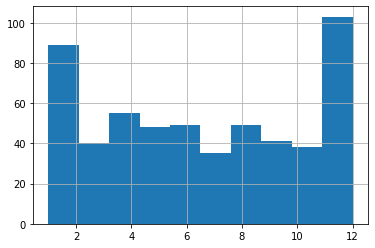

In [94]:
mimic_iii_dataset["culture_month"].hist()

In [95]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_id                                                                                              int64
patient_gender                                                                                         object
patient_date_of_birth                                                                          datetime64[ns]
admission_id                                                                                            int64
admission_date                                                                                 datetime64[ns]
admission_date_of_last_admission                                                               datetime64[ns]
discharge_or_death_time                                                                                object
exitus                                                                                                 object
admission_type                                                                                         object
admission_

**IMPORTANT : dates of complete treatments with respect to the date of the culture and the date corresponding with 180 days before the culture**

There are 2 extreme situations that always need to be keep in mind to not forget them and to not make mistakes in the interpretation of the data:
  - Situation A: when the date of the culture is exactly equal to the date of start of a complete treatment, that complete treatment **WILL NOT BE INCLUDED** in the list of last complete treatments (the complete treatment in the last position of the list will be the previous one of that).
  - Situation B: when the date corresponding with 180 days before the culture is exactly equal to the date of of finish of a complete treatment, that complete treatment **WILL BE INCLUDED** in the list of last complete treatments in the last 180 days (the complete treatment in the first position of the list will be that).

### D. Transformation of the types of the attributes.

#### Attribute 'discharge_or_death_time' (from object to datetime).

In [96]:
# Head of attribute 'discharge_or_death_time '.
mimic_iii_dataset['discharge_or_death_time'].head()

0    2135-02-08 02:08:00
1    2166-02-01 06:55:00
2    2144-07-14 16:15:00
3    2200-07-08 11:30:00
4    2129-12-20 01:37:00
Name: discharge_or_death_time, dtype: object

In [97]:
# Convert 'discharge_or_death_time' to datetime.
mimic_iii_dataset['discharge_or_death_time'] = pd.to_datetime(mimic_iii_dataset['discharge_or_death_time'])

In [98]:
# Head of attribute 'discharge_or_death_time '.
mimic_iii_dataset['discharge_or_death_time'].head()

0   2135-02-08 02:08:00
1   2166-02-01 06:55:00
2   2144-07-14 16:15:00
3   2200-07-08 11:30:00
4   2129-12-20 01:37:00
Name: discharge_or_death_time, dtype: datetime64[ns]

In [99]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_id                                                                                              int64
patient_gender                                                                                         object
patient_date_of_birth                                                                          datetime64[ns]
admission_id                                                                                            int64
admission_date                                                                                 datetime64[ns]
admission_date_of_last_admission                                                               datetime64[ns]
discharge_or_death_time                                                                        datetime64[ns]
exitus                                                                                                 object
admission_type                                                                                         object
admission_

### E. Treatment of missing values.

#### Before the treatment.

In [100]:
# Missing values.
print("* Missing values per columns: ")
print(mimic_iii_dataset.isnull().sum(axis = 0))

* Missing values per columns: 
patient_id                                                                                       0
patient_gender                                                                                   0
patient_date_of_birth                                                                            0
admission_id                                                                                     0
admission_date                                                                                   0
admission_date_of_last_admission                                                               322
discharge_or_death_time                                                                          0
exitus                                                                                           0
admission_type                                                                                   0
admission_location                                                            

**IMPORTANT**

We only are going to care about attributes 'culture_mic' (and the rest of atributes related to it), 'service_when_culture' and 'icu_when_culture'. The rest of the attributes correspond with dates and they will be deleted later.

#### Attribute 'culture_mic' (and the rest of atributes related to it).

**VERY IMPORTANT**

The attribute 'culture_mic' is very important for our study and cannot be impute (because we cannot know and obtain the MIC if we do not know it previously). For this reason, these 16 rows will be deleted.

In [101]:
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

Number of columns: 41
Number of rows: 547


In [102]:
mimic_iii_dataset.dropna(subset=['culture_mic'], inplace=True)
# VERY IMPORTANT: I have to reset/regenerate the indexes after dropping the rows.
mimic_iii_dataset.reset_index(drop=True,inplace=True)

In [103]:
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

Number of columns: 41
Number of rows: 531


In [104]:
# IMPORTANT: We are going to check again the unique values and counts.
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_comparison'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_value'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=1'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=2'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=4'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=8'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=16'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=32'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=128'].value_counts(dropna=False))
print("-----------------------------------------------------------")
print(mimic_iii_dataset['culture_mic_<=256'].value_counts(dropna=False))
print("-----------------------------------------------------------")

-----------------------------------------------------------
=>32     366
<=1       92
1         41
<=0.5     16
=>128      8
4          2
2          2
=>16       2
8          1
>256       1
Name: culture_mic, dtype: int64
-----------------------------------------------------------
=>    376
<=    108
=      46
>       1
Name: culture_mic_comparison, dtype: int64
-----------------------------------------------------------
32.0     366
1.0      149
128.0      8
16.0       2
4.0        2
2.0        2
256        1
8.0        1
Name: culture_mic_value, dtype: int64
-----------------------------------------------------------
N    382
Y    149
Name: culture_mic_<=1, dtype: int64
-----------------------------------------------------------
N    380
Y    151
Name: culture_mic_<=2, dtype: int64
-----------------------------------------------------------
N    378
Y    153
Name: culture_mic_<=4, dtype: int64
-----------------------------------------------------------
N    377
Y    154
Name: culture

In [105]:
# After all changes, the attribute 'culture_mic_<=256' has only one value. So, we have to delete it.
mimic_iii_dataset.drop(columns=['culture_mic_<=256'], inplace=True)

In [106]:
# All columns of the dataset.
print(mimic_iii_dataset.columns)
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

Index(['patient_id', 'patient_gender', 'patient_date_of_birth', 'admission_id', 'admission_date', 'admission_date_of_last_admission', 'discharge_or_death_time', 'exitus', 'admission_type', 'admission_location', 'discharge_location', 'admission_date_of_first_icu', 'culture_date', 'culture_specimen_id', 'culture_specimen_type_description', 'culture_microorganism_id', 'culture_microorganism_name', 'isolate_number', 'culture_mic', 'culture_mic_comparison', 'culture_mic_value', 'culture_susceptibility', 'service_when_culture', 'icu_when_culture', 'culture_mic_<=1', 'culture_mic_<=2', 'culture_mic_<=4', 'culture_mic_<=8', 'culture_mic_<=16', 'culture_mic_<=32', 'culture_mic_<=128', 'patient_age', 'days_since_last_admission', 'days_between_admission_and_first_ICU', 'days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS', 'duration_of_last_vancomycin_treatment__ALL_ADMISSIONS', 'number_of_last_vancomycin_treatments__ALL_ADMISSIONS',
       'duration_in_natural_days_of_last_vancomy

#### Attribute 'service_when_culture'.

In [107]:
# Unique values and counts.
mimic_iii_dataset['service_when_culture'].value_counts(dropna=False)

MED      220
SURG     136
OMED      51
NaN       35
CSURG     24
CMED      21
TRAUM     15
VSURG      6
NMED       6
TSURG      5
NSURG      4
GU         3
ORTHO      2
ENT        2
DENT       1
Name: service_when_culture, dtype: int64

In [108]:
# Fill missing values.
mimic_iii_dataset['service_when_culture'].fillna('NO SERVICE', inplace=True)

In [109]:
# Unique values and counts.
mimic_iii_dataset['service_when_culture'].value_counts(dropna=False)

MED           220
SURG          136
OMED           51
NO SERVICE     35
CSURG          24
CMED           21
TRAUM          15
VSURG           6
NMED            6
TSURG           5
NSURG           4
GU              3
ORTHO           2
ENT             2
DENT            1
Name: service_when_culture, dtype: int64

#### Attribute 'icu_when_culture'.

In [110]:
# Unique values and counts.
mimic_iii_dataset['icu_when_culture'].value_counts(dropna=False)

NaN      200
MICU     159
SICU      80
TSICU     40
CSRU      29
CCU       23
Name: icu_when_culture, dtype: int64

In [111]:
# Fill missing values.
mimic_iii_dataset['icu_when_culture'].fillna('NO ICU', inplace=True)

In [112]:
# Unique values and counts.
mimic_iii_dataset['icu_when_culture'].value_counts(dropna=False)

NO ICU    200
MICU      159
SICU       80
TSICU      40
CSRU       29
CCU        23
Name: icu_when_culture, dtype: int64

#### After the treatment.

In [113]:
# Missing values.
print("* Missing values per columns: ")
print(mimic_iii_dataset.isnull().sum(axis = 0))

* Missing values per columns: 
patient_id                                                                                       0
patient_gender                                                                                   0
patient_date_of_birth                                                                            0
admission_id                                                                                     0
admission_date                                                                                   0
admission_date_of_last_admission                                                               312
discharge_or_death_time                                                                          0
exitus                                                                                           0
admission_type                                                                                   0
admission_location                                                            

## 2.4. Exploration and selection of attributes.

### A. Summarization, description and visualization of data.

In [114]:
# All columns of the dataset.
print(mimic_iii_dataset.columns)
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

Index(['patient_id', 'patient_gender', 'patient_date_of_birth', 'admission_id', 'admission_date', 'admission_date_of_last_admission', 'discharge_or_death_time', 'exitus', 'admission_type', 'admission_location', 'discharge_location', 'admission_date_of_first_icu', 'culture_date', 'culture_specimen_id', 'culture_specimen_type_description', 'culture_microorganism_id', 'culture_microorganism_name', 'isolate_number', 'culture_mic', 'culture_mic_comparison', 'culture_mic_value', 'culture_susceptibility', 'service_when_culture', 'icu_when_culture', 'culture_mic_<=1', 'culture_mic_<=2', 'culture_mic_<=4', 'culture_mic_<=8', 'culture_mic_<=16', 'culture_mic_<=32', 'culture_mic_<=128', 'patient_age', 'days_since_last_admission', 'days_between_admission_and_first_ICU', 'days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS', 'duration_of_last_vancomycin_treatment__ALL_ADMISSIONS', 'number_of_last_vancomycin_treatments__ALL_ADMISSIONS',
       'duration_in_natural_days_of_last_vancomy

In [115]:
# Types of the columns.
mimic_iii_dataset.dtypes

patient_id                                                                                              int64
patient_gender                                                                                         object
patient_date_of_birth                                                                          datetime64[ns]
admission_id                                                                                            int64
admission_date                                                                                 datetime64[ns]
admission_date_of_last_admission                                                               datetime64[ns]
discharge_or_death_time                                                                        datetime64[ns]
exitus                                                                                                 object
admission_type                                                                                         object
admission_

In [116]:
# Distribution of columns.
for i in mimic_iii_dataset.columns:
    print("** COLUMN " + i.upper() + " **")
    if ('id' not in i.lower()) and ('date' not in i.lower()) and ('time' not in i.lower()):
        print(mimic_iii_dataset[i].value_counts(dropna=False))

** COLUMN PATIENT_ID **
** COLUMN PATIENT_GENDER **
M    310
F    221
Name: patient_gender, dtype: int64
** COLUMN PATIENT_DATE_OF_BIRTH **
** COLUMN ADMISSION_ID **
** COLUMN ADMISSION_DATE **
** COLUMN ADMISSION_DATE_OF_LAST_ADMISSION **
** COLUMN DISCHARGE_OR_DEATH_TIME **
** COLUMN EXITUS **
N    339
Y    192
Name: exitus, dtype: int64
** COLUMN ADMISSION_TYPE **
EMERGENCY    495
ELECTIVE      36
Name: admission_type, dtype: int64
** COLUMN ADMISSION_LOCATION **
EMERGENCY ROOM ADMIT         205
TRANSFER FROM HOSP/EXTRAM    118
CLINIC REFERRAL/PREMATURE    113
PHYS REFERRAL/NORMAL DELI     89
TRANSFER FROM SKILLED NUR      5
TRANSFER FROM OTHER HEALT      1
Name: admission_location, dtype: int64
** COLUMN DISCHARGE_LOCATION **
DEAD/EXPIRED                 192
REHAB/DISTINCT PART HOSP     101
LONG TERM CARE HOSPITAL       74
HOME HEALTH CARE              58
SNF                           53
HOME                          21
HOSPICE-HOME                  11
HOSPICE-MEDICAL FACILITY     

In [117]:
# Function 'describe'.
mimic_iii_dataset.describe()

,patient_id,admission_id,culture_specimen_id,culture_microorganism_id,isolate_number,patient_age,days_since_last_admission,days_between_admission_and_first_ICU,days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS,duration_of_last_vancomycin_treatment__ALL_ADMISSIONS,number_of_last_vancomycin_treatments__ALL_ADMISSIONS,duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS,number_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS,culture_month
count,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.00000
mean,39421.489642,146747.600753,70028.128060,80187.303202,1.067797,61.391714,119.608286,6.461394,11.661017,-0.082863,0.529190,1.028249,0.436911,6.52919
std,30869.851682,28435.409694,30.288465,45.212124,0.266208,15.685501,360.418762,13.863619,59.881471,2.179819,1.088792,4.433699,0.895098,3.51769
min,21.000000,100449.000000,70003.000000,80168.000000,1.000000,18.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,1.00000
25%,13605.000000,123653.000000,70012.000000,80168.000000,1.000000,51.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,4.00000
50%,26912.000000,145069.000000,70012.000000,80168.000000,1.000000,63.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,6.00000
75%,65366.000000,171106.000000,70012.000000,80168.000000,1.000000,72.000000,52.000000,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,10.00000
max,99836.000000,199872.000000,70091.000000,80293.000000,3.000000,90.000000,2920.000000,136.000000,590.000000,14.000000,7.000000,29.000000,5.000000,12.00000


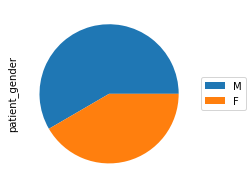

In [118]:
# Pie chart of attribute 'patient_gender'.
ax = mimic_iii_dataset['patient_gender'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['patient_gender'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

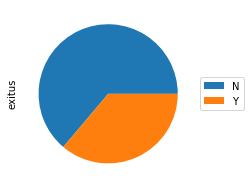

In [119]:
# Pie chart of attribute 'exitus'.
ax = mimic_iii_dataset['exitus'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['exitus'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

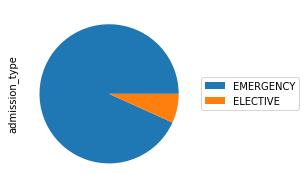

In [120]:
# Pie chart of attribute 'admission_type'.
ax = mimic_iii_dataset['admission_type'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['admission_type'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

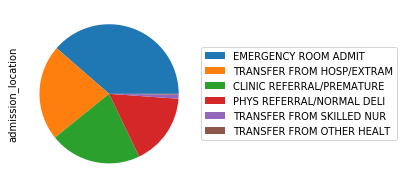

In [121]:
# Pie chart of attribute 'admission_location'.
ax = mimic_iii_dataset['admission_location'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['admission_location'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

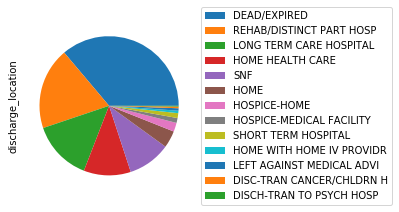

In [122]:
# Pie chart of attribute 'discharge_location'.
ax = mimic_iii_dataset['discharge_location'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['discharge_location'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

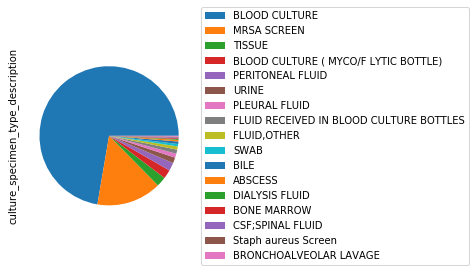

In [123]:
# Pie chart of attribute 'culture_specimen_type_description'.
ax = mimic_iii_dataset['culture_specimen_type_description'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['culture_specimen_type_description'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

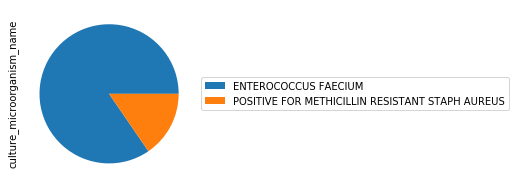

In [124]:
# Pie chart of attribute 'culture_microorganism_name'.
ax = mimic_iii_dataset['culture_microorganism_name'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['culture_microorganism_name'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

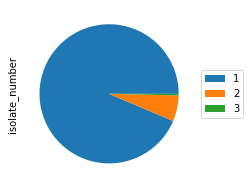

In [125]:
# Pie chart of attribute 'isolate_number'.
ax = mimic_iii_dataset['isolate_number'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['isolate_number'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

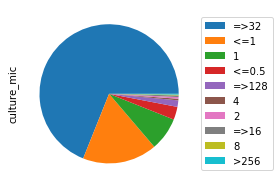

In [126]:
# Pie chart of attribute 'culture_mic'.
ax = mimic_iii_dataset['culture_mic'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['culture_mic'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

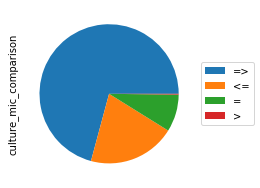

In [127]:
# Pie chart of attribute 'culture_mic'.
ax = mimic_iii_dataset['culture_mic_comparison'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['culture_mic_comparison'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

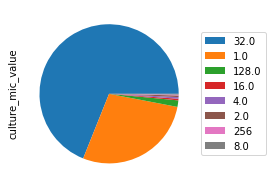

In [128]:
# Pie chart of attribute 'culture_mic'.
ax = mimic_iii_dataset['culture_mic_value'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['culture_mic_value'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

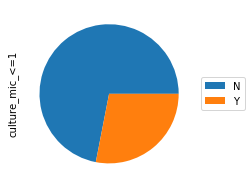

In [129]:
# Pie chart of attribute 'culture_mic'.
ax = mimic_iii_dataset['culture_mic_<=1'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['culture_mic_<=1'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

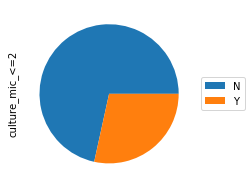

In [130]:
# Pie chart of attribute 'culture_mic'.
ax = mimic_iii_dataset['culture_mic_<=2'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['culture_mic_<=2'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

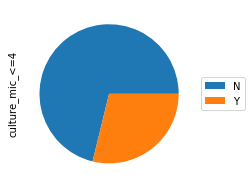

In [131]:
# Pie chart of attribute 'culture_mic'.
ax = mimic_iii_dataset['culture_mic_<=4'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['culture_mic_<=4'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

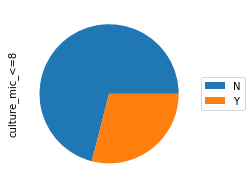

In [132]:
# Pie chart of attribute 'culture_mic'.
ax = mimic_iii_dataset['culture_mic_<=8'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['culture_mic_<=8'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

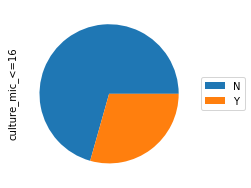

In [133]:
# Pie chart of attribute 'culture_mic'.
ax = mimic_iii_dataset['culture_mic_<=16'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['culture_mic_<=16'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

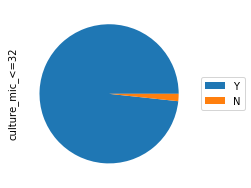

In [134]:
# Pie chart of attribute 'culture_mic'.
ax = mimic_iii_dataset['culture_mic_<=32'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['culture_mic_<=32'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

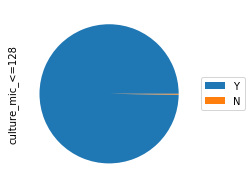

In [135]:
# Pie chart of attribute 'culture_mic'.
ax = mimic_iii_dataset['culture_mic_<=128'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['culture_mic_<=128'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

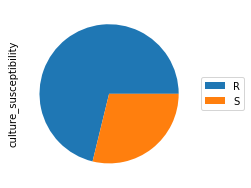

In [136]:
# Pie chart of attribute 'culture_susceptibility'.
ax = mimic_iii_dataset['culture_susceptibility'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['culture_susceptibility'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

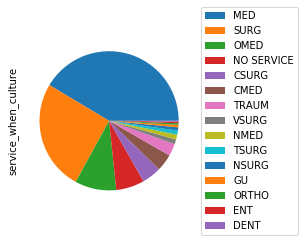

In [137]:
# Pie chart of attribute 'service_when_culture'.
ax = mimic_iii_dataset['service_when_culture'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['service_when_culture'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

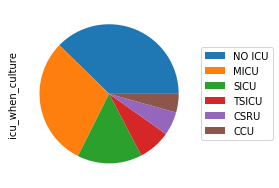

In [138]:
# Pie chart of attribute 'icu_when_culture'.
ax = mimic_iii_dataset['icu_when_culture'].value_counts(dropna=False).plot.pie(labels=None)
ax.set_position([ax.get_position().x0, ax.get_position().y0, ax.get_position().width * 0.8, ax.get_position().height])
ax.legend(loc='center left', labels=mimic_iii_dataset['icu_when_culture'].value_counts(dropna=False).index, bbox_to_anchor=(1, 0.5))

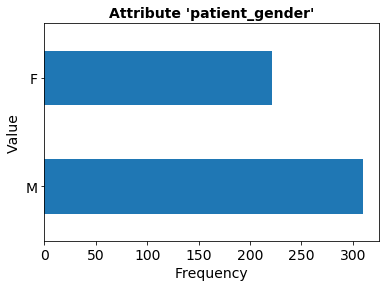

In [139]:
ax = mimic_iii_dataset['patient_gender'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'patient_gender'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

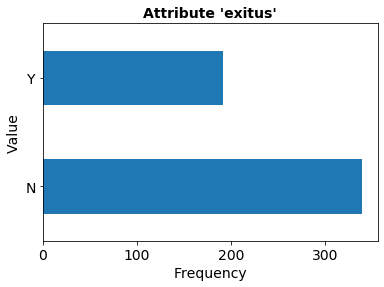

In [140]:
ax = mimic_iii_dataset['exitus'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'exitus'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

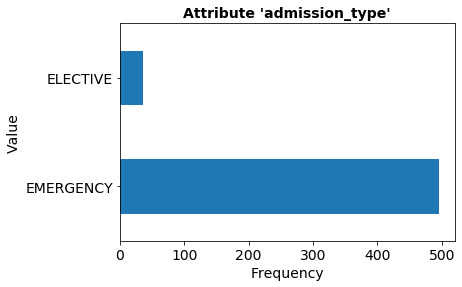

In [141]:
ax = mimic_iii_dataset['admission_type'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'admission_type'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

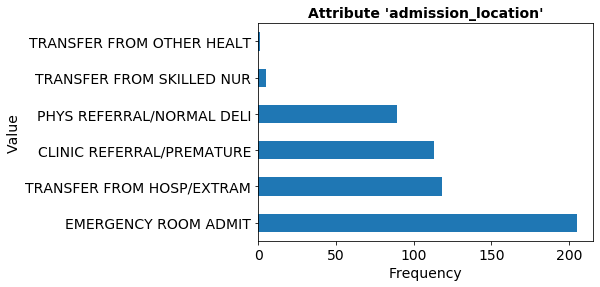

In [142]:
ax = mimic_iii_dataset['admission_location'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'admission_location'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

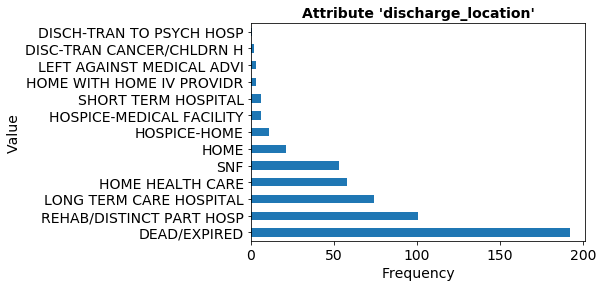

In [143]:
ax = mimic_iii_dataset['discharge_location'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'discharge_location'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

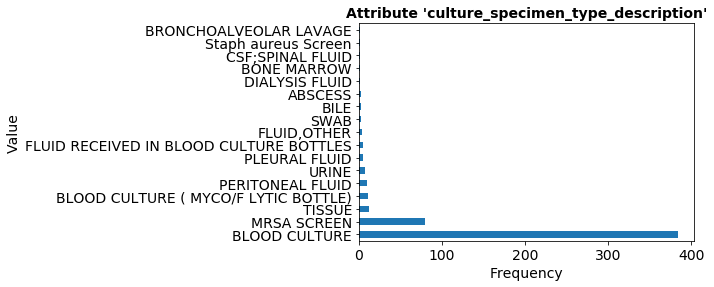

In [144]:
ax = mimic_iii_dataset['culture_specimen_type_description'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'culture_specimen_type_description'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

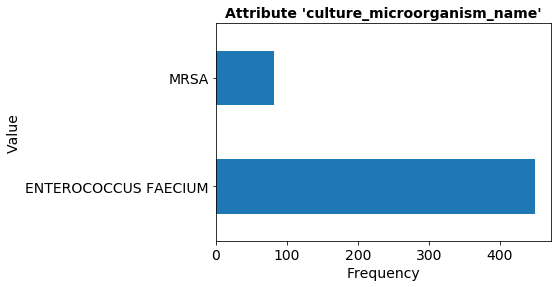

In [145]:
ax = mimic_iii_dataset['culture_microorganism_name'].replace({'POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS' : 'MRSA'}).value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'culture_microorganism_name'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

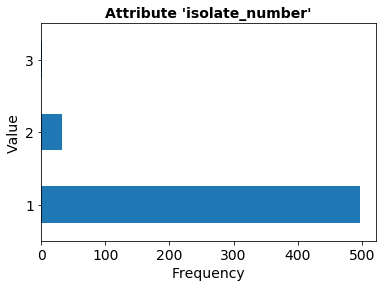

In [146]:
ax = mimic_iii_dataset['isolate_number'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'isolate_number'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

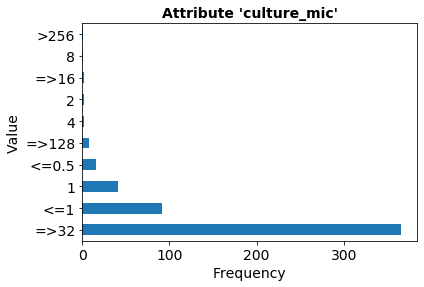

In [147]:
ax = mimic_iii_dataset['culture_mic'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'culture_mic'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

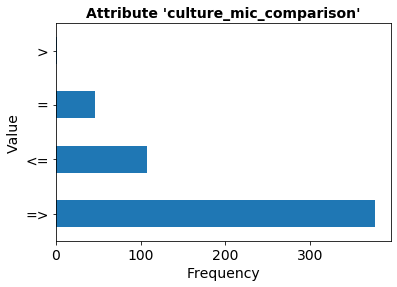

In [148]:
ax = mimic_iii_dataset['culture_mic_comparison'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'culture_mic_comparison'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

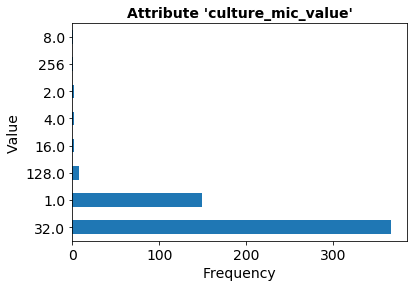

In [149]:
ax = mimic_iii_dataset['culture_mic_value'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'culture_mic_value'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

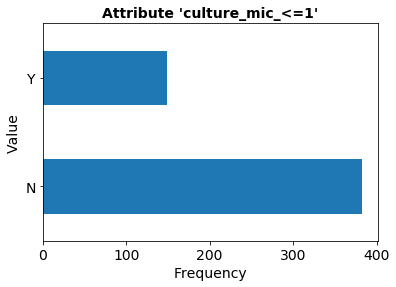

In [150]:
ax = mimic_iii_dataset['culture_mic_<=1'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'culture_mic_<=1'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

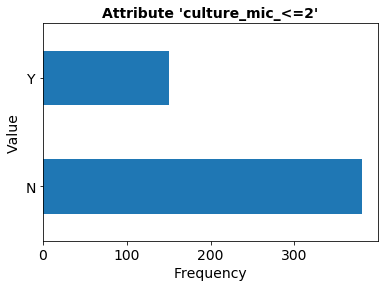

In [151]:
ax = mimic_iii_dataset['culture_mic_<=2'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'culture_mic_<=2'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

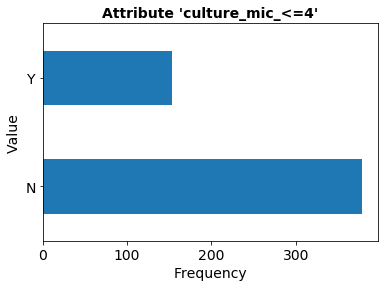

In [152]:
ax = mimic_iii_dataset['culture_mic_<=4'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'culture_mic_<=4'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

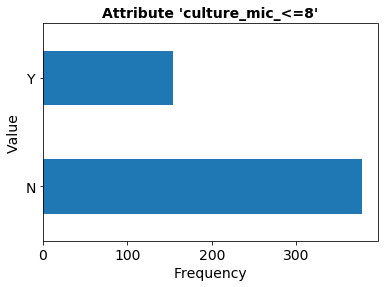

In [153]:
ax = mimic_iii_dataset['culture_mic_<=8'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'culture_mic_<=8'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

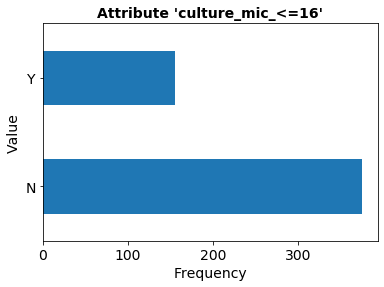

In [154]:
ax = mimic_iii_dataset['culture_mic_<=16'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'culture_mic_<=16'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

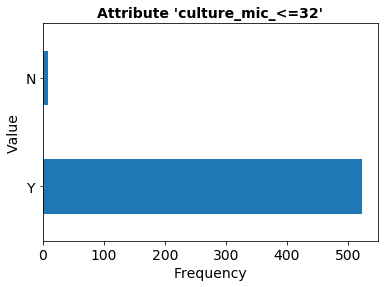

In [155]:
ax = mimic_iii_dataset['culture_mic_<=32'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'culture_mic_<=32'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

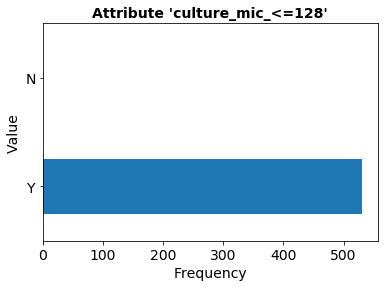

In [156]:
ax = mimic_iii_dataset['culture_mic_<=128'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'culture_mic_<=128'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

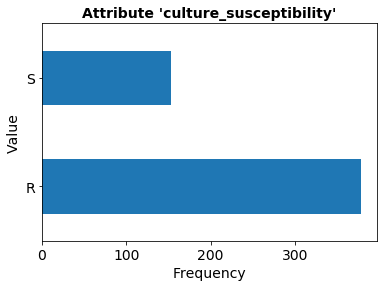

In [157]:
ax = mimic_iii_dataset['culture_susceptibility'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'culture_susceptibility'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

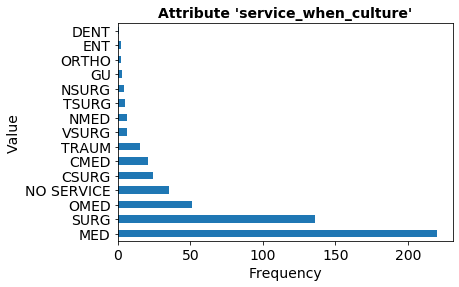

In [158]:
ax = mimic_iii_dataset['service_when_culture'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'service_when_culture'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

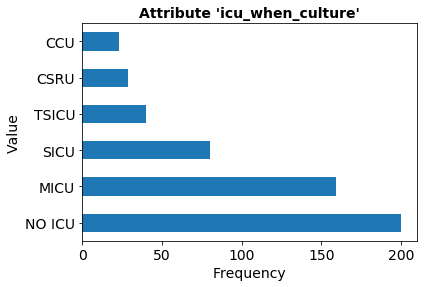

In [159]:
ax = mimic_iii_dataset['icu_when_culture'].value_counts(dropna=False).plot.barh()
ax.set_title("Attribute 'icu_when_culture'", fontsize=14, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)
ax.set_ylabel("Value", fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

### B. Selection of attributes.

**EXTREMELY IMPORTANT**

There are certain attributes in the dataset such as 'patient_id', 'admission_id', 'culture_specimen_id' or 'culture_microorganism_id' that are only needed for data trazability, but they are not needed for data mining algorithms. So, we are going to delete them.

Besides, at the same way, the attribute 'isolate_number' are only needed to identify different strains of the same type of microorganism. So, we can consider this as an ID and we can delete it. 

Moreover, we are going to delete all dates, because another attributes were created from them. At the same way, we are going to delete the attributes 'culture_mic', 'culture_mic_comparison' and 'culture_mic_value'.

In [160]:
# Despite of that, we are going to maintain the complete DataFrame with all the attributes.
mimic_iii_dataset_all_attributes = mimic_iii_dataset.copy()

In [161]:
# All columns of the dataset.
print(mimic_iii_dataset.columns)
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

Index(['patient_id', 'patient_gender', 'patient_date_of_birth', 'admission_id', 'admission_date', 'admission_date_of_last_admission', 'discharge_or_death_time', 'exitus', 'admission_type', 'admission_location', 'discharge_location', 'admission_date_of_first_icu', 'culture_date', 'culture_specimen_id', 'culture_specimen_type_description', 'culture_microorganism_id', 'culture_microorganism_name', 'isolate_number', 'culture_mic', 'culture_mic_comparison', 'culture_mic_value', 'culture_susceptibility', 'service_when_culture', 'icu_when_culture', 'culture_mic_<=1', 'culture_mic_<=2', 'culture_mic_<=4', 'culture_mic_<=8', 'culture_mic_<=16', 'culture_mic_<=32', 'culture_mic_<=128', 'patient_age', 'days_since_last_admission', 'days_between_admission_and_first_ICU', 'days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS', 'duration_of_last_vancomycin_treatment__ALL_ADMISSIONS', 'number_of_last_vancomycin_treatments__ALL_ADMISSIONS',
       'duration_in_natural_days_of_last_vancomy

In [162]:
# Types of the columns.
mimic_iii_dataset.dtypes

patient_id                                                                                              int64
patient_gender                                                                                         object
patient_date_of_birth                                                                          datetime64[ns]
admission_id                                                                                            int64
admission_date                                                                                 datetime64[ns]
admission_date_of_last_admission                                                               datetime64[ns]
discharge_or_death_time                                                                        datetime64[ns]
exitus                                                                                                 object
admission_type                                                                                         object
admission_

In [163]:
# Delete columns.
mimic_iii_dataset.drop(columns=['patient_id', 'admission_id', 'culture_specimen_id', 'culture_microorganism_id', 'isolate_number' ,'patient_date_of_birth', 'admission_date', 'admission_date_of_last_admission', 'discharge_or_death_time', 'admission_date_of_first_icu', 'culture_date', 'culture_mic', 'culture_mic_comparison', 'culture_mic_value'], inplace=True)

In [164]:
# All columns of the dataset.
print(mimic_iii_dataset.columns)
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

Index(['patient_gender', 'exitus', 'admission_type', 'admission_location', 'discharge_location', 'culture_specimen_type_description', 'culture_microorganism_name', 'culture_susceptibility', 'service_when_culture', 'icu_when_culture', 'culture_mic_<=1', 'culture_mic_<=2', 'culture_mic_<=4', 'culture_mic_<=8', 'culture_mic_<=16', 'culture_mic_<=32', 'culture_mic_<=128', 'patient_age', 'days_since_last_admission', 'days_between_admission_and_first_ICU', 'days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS', 'duration_of_last_vancomycin_treatment__ALL_ADMISSIONS', 'number_of_last_vancomycin_treatments__ALL_ADMISSIONS', 'duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS', 'number_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS', 'culture_month'], dtype='object')
Number of columns: 26
Number of rows: 531


In [165]:
# Types of the columns.
mimic_iii_dataset.dtypes

patient_gender                                                                                 object
exitus                                                                                         object
admission_type                                                                                 object
admission_location                                                                             object
discharge_location                                                                             object
culture_specimen_type_description                                                              object
culture_microorganism_name                                                                     object
culture_susceptibility                                                                         object
service_when_culture                                                                           object
icu_when_culture                                                                  

### C. Storing the results in files (optional)

In [166]:
path_of_the_preprocessed_datasets = "C:/Users/Public/Documents/"

In [167]:
# Write the dataset with all attributes.
write_dataset = False
if write_dataset:
    mimic_iii_dataset_all_attributes.to_csv(path_of_the_preprocessed_datasets + "/mimic-iii-preprocessed-all-attributes-db.csv", index=False)

In [168]:
# Write the dataset.
write_dataset = False
if write_dataset:
    mimic_iii_dataset.to_csv(path_of_the_preprocessed_datasets + "/mimic-iii-preprocessed-db.csv", index=False)

# 3. Experiments.

Preprocessed dataset with all the attributes (variable 'mimic_iii_dataset_all_attributes'):
  - This dataset could contain attributes with missing values.
  - This dataset will not be used in the clustering process (it is only useful to view the final results).
  
Proprocessed dataset (variable 'mimic_iii_dataset'):
  - This dataset does not contain attributes with missing values (it is, in fact, the mining view).
  - All the attributes from this dataset will be transformed to numerical type (numerical mining view) and, then, it will be used in the clustering process.

In [169]:
# All columns of the dataset.
print(mimic_iii_dataset.columns)
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

Index(['patient_gender', 'exitus', 'admission_type', 'admission_location', 'discharge_location', 'culture_specimen_type_description', 'culture_microorganism_name', 'culture_susceptibility', 'service_when_culture', 'icu_when_culture', 'culture_mic_<=1', 'culture_mic_<=2', 'culture_mic_<=4', 'culture_mic_<=8', 'culture_mic_<=16', 'culture_mic_<=32', 'culture_mic_<=128', 'patient_age', 'days_since_last_admission', 'days_between_admission_and_first_ICU', 'days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS', 'duration_of_last_vancomycin_treatment__ALL_ADMISSIONS', 'number_of_last_vancomycin_treatments__ALL_ADMISSIONS', 'duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS', 'number_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS', 'culture_month'], dtype='object')
Number of columns: 26
Number of rows: 531


In [170]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_gender                                                                                 object
exitus                                                                                         object
admission_type                                                                                 object
admission_location                                                                             object
discharge_location                                                                             object
culture_specimen_type_description                                                              object
culture_microorganism_name                                                                     object
culture_susceptibility                                                                         object
service_when_culture                                                                           object
icu_when_culture                                                                  

In [171]:
# Values of the columns and distribution of them.
for i in mimic_iii_dataset.columns:
    print("** COLUMN " + i.upper() + " **")
    print(mimic_iii_dataset[i].value_counts(dropna=False))

** COLUMN PATIENT_GENDER **
M    310
F    221
Name: patient_gender, dtype: int64
** COLUMN EXITUS **
N    339
Y    192
Name: exitus, dtype: int64
** COLUMN ADMISSION_TYPE **
EMERGENCY    495
ELECTIVE      36
Name: admission_type, dtype: int64
** COLUMN ADMISSION_LOCATION **
EMERGENCY ROOM ADMIT         205
TRANSFER FROM HOSP/EXTRAM    118
CLINIC REFERRAL/PREMATURE    113
PHYS REFERRAL/NORMAL DELI     89
TRANSFER FROM SKILLED NUR      5
TRANSFER FROM OTHER HEALT      1
Name: admission_location, dtype: int64
** COLUMN DISCHARGE_LOCATION **
DEAD/EXPIRED                 192
REHAB/DISTINCT PART HOSP     101
LONG TERM CARE HOSPITAL       74
HOME HEALTH CARE              58
SNF                           53
HOME                          21
HOSPICE-HOME                  11
HOSPICE-MEDICAL FACILITY       6
SHORT TERM HOSPITAL            6
HOME WITH HOME IV PROVIDR      3
LEFT AGAINST MEDICAL ADVI      3
DISC-TRAN CANCER/CHLDRN H      2
DISCH-TRAN TO PSYCH HOSP       1
Name: discharge_location, d

In [172]:
# Missing values.
print("* Missing values per columns: ")
print(mimic_iii_dataset.isnull().sum(axis = 0))

* Missing values per columns: 
patient_gender                                                                                 0
exitus                                                                                         0
admission_type                                                                                 0
admission_location                                                                             0
discharge_location                                                                             0
culture_specimen_type_description                                                              0
culture_microorganism_name                                                                     0
culture_susceptibility                                                                         0
service_when_culture                                                                           0
icu_when_culture                                                                               0

**IMPORTANT**

In the clinical context, it is important to know that: (1) if a strain is sensible to a certain antibiotic, that bacterial strain has a low value of MIC for that antibiotic and (b) if it is resistant to a certain antibiotic, that bacterial strain has a high value of MIC for that antibiotic. This means that the susceptibility of a culture can be explained almost completely with the MIC. For this reason, for these experiments, we remove the 7 attributes related to the MIC of the initial mining view.

In [173]:
# Delete columns.
mimic_iii_dataset.drop(columns=['culture_mic_<=1', 'culture_mic_<=2', 'culture_mic_<=4', 'culture_mic_<=8', 'culture_mic_<=16', 'culture_mic_<=32', 'culture_mic_<=128'], inplace=True)

In [174]:
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

Number of columns: 19
Number of rows: 531


In [175]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_gender                                                                                 object
exitus                                                                                         object
admission_type                                                                                 object
admission_location                                                                             object
discharge_location                                                                             object
culture_specimen_type_description                                                              object
culture_microorganism_name                                                                     object
culture_susceptibility                                                                         object
service_when_culture                                                                           object
icu_when_culture                                                                  

## 3.1. Transformation of the attributes to numeric types.

Some type of techniques (that we will apply here) need that all attributes of the dataset are of numeric types. Depending on the attribute and its values, we will use different methods.

### Attribute 'patient_gender'.

In [176]:
# Before transformation.
print(mimic_iii_dataset['patient_gender'].value_counts(dropna=False))

M    310
F    221
Name: patient_gender, dtype: int64


In [177]:
# Transformation.
mimic_iii_dataset['patient_gender'].replace({"M" : 0, "F" : 1}, inplace=True)
mimic_iii_dataset['patient_gender'] = pd.to_numeric(mimic_iii_dataset['patient_gender'])

In [178]:
# After transformation.
print(mimic_iii_dataset['patient_gender'].value_counts(dropna=False))

0    310
1    221
Name: patient_gender, dtype: int64


In [179]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_gender                                                                                  int64
exitus                                                                                         object
admission_type                                                                                 object
admission_location                                                                             object
discharge_location                                                                             object
culture_specimen_type_description                                                              object
culture_microorganism_name                                                                     object
culture_susceptibility                                                                         object
service_when_culture                                                                           object
icu_when_culture                                                                  

### Attribute 'exitus'.

In [180]:
# Before transformation.
print(mimic_iii_dataset['exitus'].value_counts(dropna=False))

N    339
Y    192
Name: exitus, dtype: int64


In [181]:
# Transformation.
mimic_iii_dataset['exitus'].replace({"N" : 0, "Y" : 1}, inplace=True)
mimic_iii_dataset['exitus'] = pd.to_numeric(mimic_iii_dataset['exitus'])

In [182]:
# After transformation.
print(mimic_iii_dataset['exitus'].value_counts(dropna=False))

0    339
1    192
Name: exitus, dtype: int64


In [183]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_gender                                                                                  int64
exitus                                                                                          int64
admission_type                                                                                 object
admission_location                                                                             object
discharge_location                                                                             object
culture_specimen_type_description                                                              object
culture_microorganism_name                                                                     object
culture_susceptibility                                                                         object
service_when_culture                                                                           object
icu_when_culture                                                                  

### Attribute 'admission_type'.

In [184]:
# Before transformation.
print(mimic_iii_dataset['admission_type'].value_counts(dropna=False))

EMERGENCY    495
ELECTIVE      36
Name: admission_type, dtype: int64


In [185]:
# Transformation.
mimic_iii_dataset['admission_type'].replace({"EMERGENCY" : 0, "ELECTIVE" : 1}, inplace=True)
mimic_iii_dataset['admission_type'] = pd.to_numeric(mimic_iii_dataset['admission_type'])

In [186]:
# After transformation.
print(mimic_iii_dataset['admission_type'].value_counts(dropna=False))

0    495
1     36
Name: admission_type, dtype: int64


In [187]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_gender                                                                                  int64
exitus                                                                                          int64
admission_type                                                                                  int64
admission_location                                                                             object
discharge_location                                                                             object
culture_specimen_type_description                                                              object
culture_microorganism_name                                                                     object
culture_susceptibility                                                                         object
service_when_culture                                                                           object
icu_when_culture                                                                  

### Attribute 'admission_location'.

In [188]:
# Before transformation.
print(mimic_iii_dataset['admission_location'].value_counts(dropna=False))

EMERGENCY ROOM ADMIT         205
TRANSFER FROM HOSP/EXTRAM    118
CLINIC REFERRAL/PREMATURE    113
PHYS REFERRAL/NORMAL DELI     89
TRANSFER FROM SKILLED NUR      5
TRANSFER FROM OTHER HEALT      1
Name: admission_location, dtype: int64


When an attribute has more than 2 values, we will use the method 'one hot encoding'.

In [189]:
# First, we have to have a list that contains one list per row (i.e. every element in the column in an independent list).
list_of_lists = [ [ v ] for v in mimic_iii_dataset['admission_location'].values ]
print(list_of_lists)

[['EMERGENCY ROOM ADMIT'], ['TRANSFER FROM HOSP/EXTRAM'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['TRANSFER FROM HOSP/EXTRAM'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['PHYS REFERRAL/NORMAL DELI'], ['TRANSFER FROM HOSP/EXTRAM'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['TRANSFER FROM HOSP/EXTRAM'], ['EMERGENCY ROOM ADMIT'], ['TRANSFER FROM HOSP/EXTRAM'], ['PHYS REFERRAL/NORMAL DELI'], ['EMERGENCY ROOM ADMIT'], ['TRANSFER FROM HOSP/EXTRAM'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['EMERGENCY ROOM ADMIT'], ['PHYS REFERRAL/NORMAL DELI'], ['PHYS REFERRAL/NO

In [190]:
# IMPORTANT: we are going to specify the order of the categories (the same that at the beginning).
values_as_list = ['EMERGENCY ROOM ADMIT',
                  'TRANSFER FROM HOSP/EXTRAM',
                  'CLINIC REFERRAL/PREMATURE',
                  'PHYS REFERRAL/NORMAL DELI',
                  'TRANSFER FROM SKILLED NUR',
                  'TRANSFER FROM OTHER HEALT']

In [191]:
# Now, we apply 'one hot encoding'.
enc = OneHotEncoder(categories=[ values_as_list ], sparse=False) 
result = enc.fit_transform(list_of_lists)
print(result)
print(enc.categories_)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]
[array(['EMERGENCY ROOM ADMIT', 'TRANSFER FROM HOSP/EXTRAM',
       'CLINIC REFERRAL/PREMATURE', 'PHYS REFERRAL/NORMAL DELI',
       'TRANSFER FROM SKILLED NUR', 'TRANSFER FROM OTHER HEALT'],
      dtype=object)]


In [192]:
# Finally, we create the new attributes of the dataframe from the result obtained above.
for new_attribute_index in range(len(enc.categories_[0])):
    new_attribute_name = enc.categories_[0][new_attribute_index].replace(' ', '_').replace('/', '_').replace('-','_').upper()
    print('admission_location_'+new_attribute_name)
    new_attribute_value = [ int(v[new_attribute_index]) for v in result ]
    mimic_iii_dataset['admission_location_'+new_attribute_name] = pd.Series(new_attribute_value)
# And delete the original attribute.
mimic_iii_dataset.drop(columns=['admission_location'],inplace=True)

admission_location_EMERGENCY_ROOM_ADMIT
admission_location_TRANSFER_FROM_HOSP_EXTRAM
admission_location_CLINIC_REFERRAL_PREMATURE
admission_location_PHYS_REFERRAL_NORMAL_DELI
admission_location_TRANSFER_FROM_SKILLED_NUR
admission_location_TRANSFER_FROM_OTHER_HEALT


In [193]:
# After transformation.
print(mimic_iii_dataset['admission_location_EMERGENCY_ROOM_ADMIT'].value_counts(dropna=False))
print(mimic_iii_dataset['admission_location_TRANSFER_FROM_HOSP_EXTRAM'].value_counts(dropna=False))
print(mimic_iii_dataset['admission_location_CLINIC_REFERRAL_PREMATURE'].value_counts(dropna=False))
print(mimic_iii_dataset['admission_location_PHYS_REFERRAL_NORMAL_DELI'].value_counts(dropna=False))
print(mimic_iii_dataset['admission_location_TRANSFER_FROM_SKILLED_NUR'].value_counts(dropna=False))
print(mimic_iii_dataset['admission_location_TRANSFER_FROM_OTHER_HEALT'].value_counts(dropna=False))

0    326
1    205
Name: admission_location_EMERGENCY_ROOM_ADMIT, dtype: int64
0    413
1    118
Name: admission_location_TRANSFER_FROM_HOSP_EXTRAM, dtype: int64
0    418
1    113
Name: admission_location_CLINIC_REFERRAL_PREMATURE, dtype: int64
0    442
1     89
Name: admission_location_PHYS_REFERRAL_NORMAL_DELI, dtype: int64
0    526
1      5
Name: admission_location_TRANSFER_FROM_SKILLED_NUR, dtype: int64
0    530
1      1
Name: admission_location_TRANSFER_FROM_OTHER_HEALT, dtype: int64


In [194]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_gender                                                                                  int64
exitus                                                                                          int64
admission_type                                                                                  int64
discharge_location                                                                             object
culture_specimen_type_description                                                              object
culture_microorganism_name                                                                     object
culture_susceptibility                                                                         object
service_when_culture                                                                           object
icu_when_culture                                                                               object
patient_age                                                                       

### Attribute 'discharge_location'.

In [195]:
# Before transformation.
print(mimic_iii_dataset['discharge_location'].value_counts(dropna=False))

DEAD/EXPIRED                 192
REHAB/DISTINCT PART HOSP     101
LONG TERM CARE HOSPITAL       74
HOME HEALTH CARE              58
SNF                           53
HOME                          21
HOSPICE-HOME                  11
HOSPICE-MEDICAL FACILITY       6
SHORT TERM HOSPITAL            6
HOME WITH HOME IV PROVIDR      3
LEFT AGAINST MEDICAL ADVI      3
DISC-TRAN CANCER/CHLDRN H      2
DISCH-TRAN TO PSYCH HOSP       1
Name: discharge_location, dtype: int64


When an attribute has more than 2 values, we will use the method 'one hot encoding'.

In [196]:
# First, we have to have a list that contains one list per row (i.e. every element in the column in an independent list).
list_of_lists = [ [ v ] for v in mimic_iii_dataset['discharge_location'].values ]
print(list_of_lists)

[['DEAD/EXPIRED'], ['DEAD/EXPIRED'], ['REHAB/DISTINCT PART HOSP'], ['REHAB/DISTINCT PART HOSP'], ['DEAD/EXPIRED'], ['REHAB/DISTINCT PART HOSP'], ['REHAB/DISTINCT PART HOSP'], ['HOME HEALTH CARE'], ['HOME HEALTH CARE'], ['DEAD/EXPIRED'], ['REHAB/DISTINCT PART HOSP'], ['DEAD/EXPIRED'], ['HOME'], ['HOSPICE-HOME'], ['HOSPICE-HOME'], ['DEAD/EXPIRED'], ['DEAD/EXPIRED'], ['DEAD/EXPIRED'], ['DEAD/EXPIRED'], ['DEAD/EXPIRED'], ['DEAD/EXPIRED'], ['DEAD/EXPIRED'], ['DEAD/EXPIRED'], ['HOME HEALTH CARE'], ['REHAB/DISTINCT PART HOSP'], ['REHAB/DISTINCT PART HOSP'], ['HOME HEALTH CARE'], ['SNF'], ['REHAB/DISTINCT PART HOSP'], ['REHAB/DISTINCT PART HOSP'], ['SNF'], ['SHORT TERM HOSPITAL'], ['HOME'], ['DEAD/EXPIRED'], ['SNF'], ['REHAB/DISTINCT PART HOSP'], ['REHAB/DISTINCT PART HOSP'], ['DEAD/EXPIRED'], ['HOME HEALTH CARE'], ['HOME HEALTH CARE'], ['HOME HEALTH CARE'], ['REHAB/DISTINCT PART HOSP'], ['REHAB/DISTINCT PART HOSP'], ['HOME HEALTH CARE'], ['REHAB/DISTINCT PART HOSP'], ['SNF'], ['DEAD/EXPIRED']

In [197]:
# IMPORTANT: we are going to specify the order of the categories (the same that at the beginning).
values_as_list = ['DEAD/EXPIRED',
                  'REHAB/DISTINCT PART HOSP',
                  'LONG TERM CARE HOSPITAL',
                  'HOME HEALTH CARE',
                  'SNF',
                  'HOME',
                  'HOSPICE-HOME',
                  'SHORT TERM HOSPITAL',
                  'HOSPICE-MEDICAL FACILITY',
                  'LEFT AGAINST MEDICAL ADVI',
                  'HOME WITH HOME IV PROVIDR',
                  'DISC-TRAN CANCER/CHLDRN H',
                  'DISCH-TRAN TO PSYCH HOSP']

In [198]:
# Now, we apply 'one hot encoding'.
enc = OneHotEncoder(categories=[ values_as_list ], sparse=False) 
result = enc.fit_transform(list_of_lists)
print(result)
print(enc.categories_)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[array(['DEAD/EXPIRED', 'REHAB/DISTINCT PART HOSP',
       'LONG TERM CARE HOSPITAL', 'HOME HEALTH CARE', 'SNF', 'HOME',
       'HOSPICE-HOME', 'SHORT TERM HOSPITAL', 'HOSPICE-MEDICAL FACILITY',
       'LEFT AGAINST MEDICAL ADVI', 'HOME WITH HOME IV PROVIDR',
       'DISC-TRAN CANCER/CHLDRN H', 'DISCH-TRAN TO PSYCH HOSP'],
      dtype=object)]


In [199]:
# Finally, we create the new attributes of the dataframe from the result obtained above.
for new_attribute_index in range(len(enc.categories_[0])):
    new_attribute_name = enc.categories_[0][new_attribute_index].replace(' ', '_').replace('/', '_').replace('-','_').upper()
    print('discharge_location_'+new_attribute_name)
    new_attribute_value = [ int(v[new_attribute_index]) for v in result ]
    mimic_iii_dataset['discharge_location_'+new_attribute_name] = pd.Series(new_attribute_value)
# And delete the original attribute.
mimic_iii_dataset.drop(columns=['discharge_location'],inplace=True)

discharge_location_DEAD_EXPIRED
discharge_location_REHAB_DISTINCT_PART_HOSP
discharge_location_LONG_TERM_CARE_HOSPITAL
discharge_location_HOME_HEALTH_CARE
discharge_location_SNF
discharge_location_HOME
discharge_location_HOSPICE_HOME
discharge_location_SHORT_TERM_HOSPITAL
discharge_location_HOSPICE_MEDICAL_FACILITY
discharge_location_LEFT_AGAINST_MEDICAL_ADVI
discharge_location_HOME_WITH_HOME_IV_PROVIDR
discharge_location_DISC_TRAN_CANCER_CHLDRN_H
discharge_location_DISCH_TRAN_TO_PSYCH_HOSP


In [200]:
# After transformation.
print(mimic_iii_dataset['discharge_location_DEAD_EXPIRED'].value_counts(dropna=False))
print(mimic_iii_dataset['discharge_location_REHAB_DISTINCT_PART_HOSP'].value_counts(dropna=False))
print(mimic_iii_dataset['discharge_location_LONG_TERM_CARE_HOSPITAL'].value_counts(dropna=False))
print(mimic_iii_dataset['discharge_location_HOME_HEALTH_CARE'].value_counts(dropna=False))
print(mimic_iii_dataset['discharge_location_SNF'].value_counts(dropna=False))
print(mimic_iii_dataset['discharge_location_HOME'].value_counts(dropna=False))
print(mimic_iii_dataset['discharge_location_HOSPICE_HOME'].value_counts(dropna=False))
print(mimic_iii_dataset['discharge_location_SHORT_TERM_HOSPITAL'].value_counts(dropna=False))
print(mimic_iii_dataset['discharge_location_HOSPICE_MEDICAL_FACILITY'].value_counts(dropna=False))
print(mimic_iii_dataset['discharge_location_LEFT_AGAINST_MEDICAL_ADVI'].value_counts(dropna=False))
print(mimic_iii_dataset['discharge_location_HOME_WITH_HOME_IV_PROVIDR'].value_counts(dropna=False))
print(mimic_iii_dataset['discharge_location_DISC_TRAN_CANCER_CHLDRN_H'].value_counts(dropna=False))
print(mimic_iii_dataset['discharge_location_DISCH_TRAN_TO_PSYCH_HOSP'].value_counts(dropna=False))

0    339
1    192
Name: discharge_location_DEAD_EXPIRED, dtype: int64
0    430
1    101
Name: discharge_location_REHAB_DISTINCT_PART_HOSP, dtype: int64
0    457
1     74
Name: discharge_location_LONG_TERM_CARE_HOSPITAL, dtype: int64
0    473
1     58
Name: discharge_location_HOME_HEALTH_CARE, dtype: int64
0    478
1     53
Name: discharge_location_SNF, dtype: int64
0    510
1     21
Name: discharge_location_HOME, dtype: int64
0    520
1     11
Name: discharge_location_HOSPICE_HOME, dtype: int64
0    525
1      6
Name: discharge_location_SHORT_TERM_HOSPITAL, dtype: int64
0    525
1      6
Name: discharge_location_HOSPICE_MEDICAL_FACILITY, dtype: int64
0    528
1      3
Name: discharge_location_LEFT_AGAINST_MEDICAL_ADVI, dtype: int64
0    528
1      3
Name: discharge_location_HOME_WITH_HOME_IV_PROVIDR, dtype: int64
0    529
1      2
Name: discharge_location_DISC_TRAN_CANCER_CHLDRN_H, dtype: int64
0    530
1      1
Name: discharge_location_DISCH_TRAN_TO_PSYCH_HOSP, dtype: int64


In [201]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_gender                                                                                  int64
exitus                                                                                          int64
admission_type                                                                                  int64
culture_specimen_type_description                                                              object
culture_microorganism_name                                                                     object
culture_susceptibility                                                                         object
service_when_culture                                                                           object
icu_when_culture                                                                               object
patient_age                                                                                     int64
days_since_last_admission                                                         

### Attribute 'culture_specimen_type_description'.

In [202]:
# Before transformation.
print(mimic_iii_dataset['culture_specimen_type_description'].value_counts(dropna=False))

BLOOD CULTURE                              384
MRSA SCREEN                                 80
TISSUE                                      12
BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)        11
PERITONEAL FLUID                            10
URINE                                        7
PLEURAL FLUID                                5
FLUID RECEIVED IN BLOOD CULTURE BOTTLES      5
FLUID,OTHER                                  4
SWAB                                         3
BILE                                         3
ABSCESS                                      2
DIALYSIS FLUID                               1
BONE MARROW                                  1
CSF;SPINAL FLUID                             1
Staph aureus Screen                          1
BRONCHOALVEOLAR LAVAGE                       1
Name: culture_specimen_type_description, dtype: int64


When an attribute has more than 2 values, we will use the method 'one hot encoding'.

In [203]:
# First, we have to have a list that contains one list per row (i.e. every element in the column in an independent list).
list_of_lists = [ [ v ] for v in mimic_iii_dataset['culture_specimen_type_description'].values ]
print(list_of_lists)

[['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['PLEURAL FLUID'], ['PLEURAL FLUID'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['MRSA SCREEN'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BILE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['TISSUE'], ['TISSUE'], ['BLOOD CULTURE'], ['BONE MARROW'], ['BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['CSF;SPINAL FLUID'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['BLOOD CULTURE'], ['TISSUE'], ['BLOOD CULTURE'], ['PERITONEAL FLUID'], ['PERITONEAL FLU

In [204]:
# IMPORTANT: we are going to specify the order of the categories (the same that at the beginning).
values_as_list = ['BLOOD CULTURE',
                  'MRSA SCREEN',
                  'TISSUE',
                  'BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)',
                  'PERITONEAL FLUID',
                  'URINE',
                  'PLEURAL FLUID',
                  'FLUID RECEIVED IN BLOOD CULTURE BOTTLES',
                  'FLUID,OTHER',
                  'BILE',
                  'SWAB',
                  'ABSCESS',
                  'BONE MARROW',
                  'BRONCHOALVEOLAR LAVAGE',
                  'DIALYSIS FLUID',
                  'CSF;SPINAL FLUID',
                  'Staph aureus Screen']

In [205]:
# Now, we apply 'one hot encoding'.
enc = OneHotEncoder(categories=[ values_as_list ], sparse=False) 
result = enc.fit_transform(list_of_lists)
print(result)
print(enc.categories_)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[array(['BLOOD CULTURE', 'MRSA SCREEN', 'TISSUE',
       'BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)', 'PERITONEAL FLUID',
       'URINE', 'PLEURAL FLUID',
       'FLUID RECEIVED IN BLOOD CULTURE BOTTLES', 'FLUID,OTHER', 'BILE',
       'SWAB', 'ABSCESS', 'BONE MARROW', 'BRONCHOALVEOLAR LAVAGE',
       'DIALYSIS FLUID', 'CSF;SPINAL FLUID', 'Staph aureus Screen'],
      dtype=object)]


In [206]:
# Finally, we create the new attributes of the dataframe from the result obtained above.
for new_attribute_index in range(len(enc.categories_[0])):
    new_attribute_name = enc.categories_[0][new_attribute_index].replace(' ( ', '_').replace(')', '').replace(' ', '_').replace('/', '_').replace('-','_').replace(';', '_').replace(',', '_').upper()
    print('culture_specimen_type_description_'+new_attribute_name)
    new_attribute_value = [ int(v[new_attribute_index]) for v in result ]
    mimic_iii_dataset['culture_specimen_type_description_'+new_attribute_name] = pd.Series(new_attribute_value)
# And delete the original attribute.
mimic_iii_dataset.drop(columns=['culture_specimen_type_description'],inplace=True)

culture_specimen_type_description_BLOOD_CULTURE
culture_specimen_type_description_MRSA_SCREEN
culture_specimen_type_description_TISSUE
culture_specimen_type_description_BLOOD_CULTURE_MYCO_F_LYTIC_BOTTLE
culture_specimen_type_description_PERITONEAL_FLUID
culture_specimen_type_description_URINE
culture_specimen_type_description_PLEURAL_FLUID
culture_specimen_type_description_FLUID_RECEIVED_IN_BLOOD_CULTURE_BOTTLES
culture_specimen_type_description_FLUID_OTHER
culture_specimen_type_description_BILE
culture_specimen_type_description_SWAB
culture_specimen_type_description_ABSCESS
culture_specimen_type_description_BONE_MARROW
culture_specimen_type_description_BRONCHOALVEOLAR_LAVAGE
culture_specimen_type_description_DIALYSIS_FLUID
culture_specimen_type_description_CSF_SPINAL_FLUID
culture_specimen_type_description_STAPH_AUREUS_SCREEN


In [207]:
# After transformation.
print(mimic_iii_dataset['culture_specimen_type_description_BLOOD_CULTURE'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_MRSA_SCREEN'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_TISSUE'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_BLOOD_CULTURE_MYCO_F_LYTIC_BOTTLE'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_PERITONEAL_FLUID'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_URINE'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_PLEURAL_FLUID'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_FLUID_RECEIVED_IN_BLOOD_CULTURE_BOTTLES'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_FLUID_OTHER'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_BILE'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_SWAB'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_ABSCESS'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_BONE_MARROW'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_BRONCHOALVEOLAR_LAVAGE'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_DIALYSIS_FLUID'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_CSF_SPINAL_FLUID'].value_counts(dropna=False))
print(mimic_iii_dataset['culture_specimen_type_description_STAPH_AUREUS_SCREEN'].value_counts(dropna=False))

1    384
0    147
Name: culture_specimen_type_description_BLOOD_CULTURE, dtype: int64
0    451
1     80
Name: culture_specimen_type_description_MRSA_SCREEN, dtype: int64
0    519
1     12
Name: culture_specimen_type_description_TISSUE, dtype: int64
0    520
1     11
Name: culture_specimen_type_description_BLOOD_CULTURE_MYCO_F_LYTIC_BOTTLE, dtype: int64
0    521
1     10
Name: culture_specimen_type_description_PERITONEAL_FLUID, dtype: int64
0    524
1      7
Name: culture_specimen_type_description_URINE, dtype: int64
0    526
1      5
Name: culture_specimen_type_description_PLEURAL_FLUID, dtype: int64
0    526
1      5
Name: culture_specimen_type_description_FLUID_RECEIVED_IN_BLOOD_CULTURE_BOTTLES, dtype: int64
0    527
1      4
Name: culture_specimen_type_description_FLUID_OTHER, dtype: int64
0    528
1      3
Name: culture_specimen_type_description_BILE, dtype: int64
0    528
1      3
Name: culture_specimen_type_description_SWAB, dtype: int64
0    529
1      2
Name: culture_specimen_t

In [208]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_gender                                                                                  int64
exitus                                                                                          int64
admission_type                                                                                  int64
culture_microorganism_name                                                                     object
culture_susceptibility                                                                         object
service_when_culture                                                                           object
icu_when_culture                                                                               object
patient_age                                                                                     int64
days_since_last_admission                                                                       int64
days_between_admission_and_first_ICU                                              

### Attribute 'culture_microorganism_name'.

In [209]:
# Before transformation.
print(mimic_iii_dataset['culture_microorganism_name'].value_counts(dropna=False))

ENTEROCOCCUS FAECIUM                               449
POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS     82
Name: culture_microorganism_name, dtype: int64


In [210]:
# Transformation.
mimic_iii_dataset['culture_microorganism_name'].replace({"ENTEROCOCCUS FAECIUM" : 0, "POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS" : 1}, inplace=True)
mimic_iii_dataset['culture_microorganism_name'] = pd.to_numeric(mimic_iii_dataset['culture_microorganism_name'])

In [211]:
# Before transformation.
print(mimic_iii_dataset['culture_microorganism_name'].value_counts(dropna=False))

0    449
1     82
Name: culture_microorganism_name, dtype: int64


In [212]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_gender                                                                                  int64
exitus                                                                                          int64
admission_type                                                                                  int64
culture_microorganism_name                                                                      int64
culture_susceptibility                                                                         object
service_when_culture                                                                           object
icu_when_culture                                                                               object
patient_age                                                                                     int64
days_since_last_admission                                                                       int64
days_between_admission_and_first_ICU                                              

### Attribute 'culture_susceptibility'.

In [213]:
# Before transformation.
print(mimic_iii_dataset['culture_susceptibility'].value_counts(dropna=False))

R    378
S    153
Name: culture_susceptibility, dtype: int64


In [214]:
# Transformation.
mimic_iii_dataset['culture_susceptibility'].replace({"R" : 0, "S" : 1}, inplace=True)
mimic_iii_dataset['culture_susceptibility'] = pd.to_numeric(mimic_iii_dataset['culture_susceptibility'])

In [215]:
# After transformation.
print(mimic_iii_dataset['culture_susceptibility'].value_counts(dropna=False))

0    378
1    153
Name: culture_susceptibility, dtype: int64


In [216]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_gender                                                                                  int64
exitus                                                                                          int64
admission_type                                                                                  int64
culture_microorganism_name                                                                      int64
culture_susceptibility                                                                          int64
service_when_culture                                                                           object
icu_when_culture                                                                               object
patient_age                                                                                     int64
days_since_last_admission                                                                       int64
days_between_admission_and_first_ICU                                              

### Attribute 'service_when_culture'.

In [217]:
# Before transformation.
print(mimic_iii_dataset['service_when_culture'].value_counts(dropna=False))

MED           220
SURG          136
OMED           51
NO SERVICE     35
CSURG          24
CMED           21
TRAUM          15
VSURG           6
NMED            6
TSURG           5
NSURG           4
GU              3
ORTHO           2
ENT             2
DENT            1
Name: service_when_culture, dtype: int64


When an attribute has more than 2 values, we will use the method 'one hot encoding'.

In [218]:
# First, we have to have a list that contains one list per row (i.e. every element in the column in an independent list).
list_of_lists = [ [ v ] for v in mimic_iii_dataset['service_when_culture'].values ]
print(list_of_lists)

[['NO SERVICE'], ['SURG'], ['VSURG'], ['MED'], ['NO SERVICE'], ['MED'], ['MED'], ['SURG'], ['MED'], ['MED'], ['SURG'], ['MED'], ['NMED'], ['MED'], ['MED'], ['OMED'], ['OMED'], ['OMED'], ['OMED'], ['OMED'], ['OMED'], ['MED'], ['MED'], ['MED'], ['NO SERVICE'], ['MED'], ['MED'], ['MED'], ['SURG'], ['SURG'], ['NO SERVICE'], ['MED'], ['MED'], ['MED'], ['NO SERVICE'], ['SURG'], ['SURG'], ['MED'], ['OMED'], ['OMED'], ['OMED'], ['SURG'], ['TRAUM'], ['NO SERVICE'], ['TRAUM'], ['MED'], ['MED'], ['MED'], ['SURG'], ['MED'], ['MED'], ['MED'], ['MED'], ['OMED'], ['VSURG'], ['SURG'], ['MED'], ['NO SERVICE'], ['MED'], ['CMED'], ['OMED'], ['MED'], ['MED'], ['MED'], ['MED'], ['SURG'], ['MED'], ['ORTHO'], ['MED'], ['SURG'], ['SURG'], ['MED'], ['SURG'], ['SURG'], ['SURG'], ['NO SERVICE'], ['SURG'], ['MED'], ['CMED'], ['CMED'], ['SURG'], ['NO SERVICE'], ['CMED'], ['TRAUM'], ['CSURG'], ['MED'], ['GU'], ['MED'], ['MED'], ['CMED'], ['MED'], ['MED'], ['MED'], ['MED'], ['MED'], ['CSURG'], ['NO SERVICE'], ['MED'

In [219]:
# IMPORTANT: we are going to specify the order of the categories (the same that at the beginning).
values_as_list = ['MED',
                  'SURG',
                  'OMED',
                  'NO SERVICE',
                  'CSURG',
                  'CMED',
                  'TRAUM',
                  'VSURG',
                  'NMED',
                  'TSURG',
                  'NSURG',
                  'GU',
                  'ORTHO',
                  'ENT',
                  'DENT']

In [220]:
# Now, we apply 'one hot encoding'.
enc = OneHotEncoder(categories=[ values_as_list ], sparse=False) 
result = enc.fit_transform(list_of_lists)
print(result)
print(enc.categories_)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[array(['MED', 'SURG', 'OMED', 'NO SERVICE', 'CSURG', 'CMED', 'TRAUM',
       'VSURG', 'NMED', 'TSURG', 'NSURG', 'GU', 'ORTHO', 'ENT', 'DENT'],
      dtype=object)]


In [221]:
# Finally, we create the new attributes of the dataframe from the result obtained above.
for new_attribute_index in range(len(enc.categories_[0])):
    new_attribute_name = enc.categories_[0][new_attribute_index].replace(' ', '_')
    print('service_when_culture_'+new_attribute_name)
    new_attribute_value = [ int(v[new_attribute_index]) for v in result ]
    mimic_iii_dataset['service_when_culture_'+new_attribute_name] = pd.Series(new_attribute_value)
# And delete the original attribute.
mimic_iii_dataset.drop(columns=['service_when_culture'],inplace=True)

service_when_culture_MED
service_when_culture_SURG
service_when_culture_OMED
service_when_culture_NO_SERVICE
service_when_culture_CSURG
service_when_culture_CMED
service_when_culture_TRAUM
service_when_culture_VSURG
service_when_culture_NMED
service_when_culture_TSURG
service_when_culture_NSURG
service_when_culture_GU
service_when_culture_ORTHO
service_when_culture_ENT
service_when_culture_DENT


In [222]:
# After transformation.
print(mimic_iii_dataset['service_when_culture_MED'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_SURG'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_OMED'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_NO_SERVICE'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_CSURG'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_CMED'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_TRAUM'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_VSURG'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_NMED'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_TSURG'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_NSURG'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_GU'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_ORTHO'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_ENT'].value_counts(dropna=False))
print(mimic_iii_dataset['service_when_culture_DENT'].value_counts(dropna=False))

0    311
1    220
Name: service_when_culture_MED, dtype: int64
0    395
1    136
Name: service_when_culture_SURG, dtype: int64
0    480
1     51
Name: service_when_culture_OMED, dtype: int64
0    496
1     35
Name: service_when_culture_NO_SERVICE, dtype: int64
0    507
1     24
Name: service_when_culture_CSURG, dtype: int64
0    510
1     21
Name: service_when_culture_CMED, dtype: int64
0    516
1     15
Name: service_when_culture_TRAUM, dtype: int64
0    525
1      6
Name: service_when_culture_VSURG, dtype: int64
0    525
1      6
Name: service_when_culture_NMED, dtype: int64
0    526
1      5
Name: service_when_culture_TSURG, dtype: int64
0    527
1      4
Name: service_when_culture_NSURG, dtype: int64
0    528
1      3
Name: service_when_culture_GU, dtype: int64
0    529
1      2
Name: service_when_culture_ORTHO, dtype: int64
0    529
1      2
Name: service_when_culture_ENT, dtype: int64
0    530
1      1
Name: service_when_culture_DENT, dtype: int64


In [223]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_gender                                                                                  int64
exitus                                                                                          int64
admission_type                                                                                  int64
culture_microorganism_name                                                                      int64
culture_susceptibility                                                                          int64
icu_when_culture                                                                               object
patient_age                                                                                     int64
days_since_last_admission                                                                       int64
days_between_admission_and_first_ICU                                                            int64
days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS                

### Attribute 'icu_when_culture'.

In [224]:
# Before transformation.
print(mimic_iii_dataset['icu_when_culture'].value_counts(dropna=False))

NO ICU    200
MICU      159
SICU       80
TSICU      40
CSRU       29
CCU        23
Name: icu_when_culture, dtype: int64


When an attribute has more than 2 values, we will use the method 'one hot encoding'.

In [225]:
# First, we have to have a list that contains one list per row (i.e. every element in the column in an independent list).
list_of_lists = [ [ v ] for v in mimic_iii_dataset['icu_when_culture'].values ]
print(list_of_lists)

[['NO ICU'], ['SICU'], ['SICU'], ['CSRU'], ['NO ICU'], ['SICU'], ['CSRU'], ['NO ICU'], ['NO ICU'], ['SICU'], ['TSICU'], ['MICU'], ['TSICU'], ['MICU'], ['MICU'], ['NO ICU'], ['NO ICU'], ['NO ICU'], ['MICU'], ['MICU'], ['MICU'], ['NO ICU'], ['NO ICU'], ['NO ICU'], ['NO ICU'], ['MICU'], ['SICU'], ['MICU'], ['CSRU'], ['SICU'], ['NO ICU'], ['MICU'], ['MICU'], ['MICU'], ['NO ICU'], ['SICU'], ['NO ICU'], ['MICU'], ['NO ICU'], ['NO ICU'], ['NO ICU'], ['NO ICU'], ['TSICU'], ['NO ICU'], ['CSRU'], ['NO ICU'], ['MICU'], ['MICU'], ['MICU'], ['MICU'], ['MICU'], ['MICU'], ['MICU'], ['NO ICU'], ['TSICU'], ['NO ICU'], ['NO ICU'], ['NO ICU'], ['NO ICU'], ['CCU'], ['NO ICU'], ['NO ICU'], ['TSICU'], ['MICU'], ['MICU'], ['NO ICU'], ['MICU'], ['MICU'], ['CCU'], ['NO ICU'], ['NO ICU'], ['NO ICU'], ['NO ICU'], ['NO ICU'], ['MICU'], ['NO ICU'], ['SICU'], ['NO ICU'], ['NO ICU'], ['NO ICU'], ['SICU'], ['NO ICU'], ['NO ICU'], ['TSICU'], ['CSRU'], ['SICU'], ['NO ICU'], ['MICU'], ['NO ICU'], ['CCU'], ['CCU'], ['NO 

In [226]:
# IMPORTANT: we are going to specify the order of the categories (the same that at the beginning).
values_as_list = ['NO ICU',
                  'MICU',
                  'SICU',
                  'TSICU',
                  'CSRU',
                  'CCU']

In [227]:
# Now, we apply 'one hot encoding'.
enc = OneHotEncoder(categories=[ values_as_list ], sparse=False) 
result = enc.fit_transform(list_of_lists)
print(result)
print(enc.categories_)

[[1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
[array(['NO ICU', 'MICU', 'SICU', 'TSICU', 'CSRU', 'CCU'], dtype=object)]


In [228]:
# Finally, we create the new attributes of the dataframe from the result obtained above.
for new_attribute_index in range(len(enc.categories_[0])):
    new_attribute_name = enc.categories_[0][new_attribute_index].replace(' ', '_')
    print('icu_when_culture_'+new_attribute_name)
    new_attribute_value = [ int(v[new_attribute_index]) for v in result ]
    mimic_iii_dataset['icu_when_culture_'+new_attribute_name] = pd.Series(new_attribute_value)
# And delete the original attribute.
mimic_iii_dataset.drop(columns=['icu_when_culture'],inplace=True)

icu_when_culture_NO_ICU
icu_when_culture_MICU
icu_when_culture_SICU
icu_when_culture_TSICU
icu_when_culture_CSRU
icu_when_culture_CCU


In [229]:
# After transformation.
print(mimic_iii_dataset['icu_when_culture_NO_ICU'].value_counts(dropna=False))
print(mimic_iii_dataset['icu_when_culture_MICU'].value_counts(dropna=False))
print(mimic_iii_dataset['icu_when_culture_SICU'].value_counts(dropna=False))
print(mimic_iii_dataset['icu_when_culture_TSICU'].value_counts(dropna=False))
print(mimic_iii_dataset['icu_when_culture_CSRU'].value_counts(dropna=False))
print(mimic_iii_dataset['icu_when_culture_CCU'].value_counts(dropna=False))

0    331
1    200
Name: icu_when_culture_NO_ICU, dtype: int64
0    372
1    159
Name: icu_when_culture_MICU, dtype: int64
0    451
1     80
Name: icu_when_culture_SICU, dtype: int64
0    491
1     40
Name: icu_when_culture_TSICU, dtype: int64
0    502
1     29
Name: icu_when_culture_CSRU, dtype: int64
0    508
1     23
Name: icu_when_culture_CCU, dtype: int64


In [230]:
# All columns of the dataset and their types.
mimic_iii_dataset.dtypes

patient_gender                                                                                 int64
exitus                                                                                         int64
admission_type                                                                                 int64
culture_microorganism_name                                                                     int64
culture_susceptibility                                                                         int64
patient_age                                                                                    int64
days_since_last_admission                                                                      int64
days_between_admission_and_first_ICU                                                           int64
days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS                             int64
duration_of_last_vancomycin_treatment__ALL_ADMISSIONS                                      

## 3.2. After all transformations of the types of the attributes.

In [231]:
# All columns of the dataset.
print(mimic_iii_dataset.columns)
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

Index(['patient_gender', 'exitus', 'admission_type', 'culture_microorganism_name', 'culture_susceptibility', 'patient_age', 'days_since_last_admission', 'days_between_admission_and_first_ICU', 'days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS', 'duration_of_last_vancomycin_treatment__ALL_ADMISSIONS', 'number_of_last_vancomycin_treatments__ALL_ADMISSIONS', 'duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS', 'number_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS', 'culture_month', 'admission_location_EMERGENCY_ROOM_ADMIT', 'admission_location_TRANSFER_FROM_HOSP_EXTRAM', 'admission_location_CLINIC_REFERRAL_PREMATURE', 'admission_location_PHYS_REFERRAL_NORMAL_DELI', 'admission_location_TRANSFER_FROM_SKILLED_NUR', 'admission_location_TRANSFER_FROM_OTHER_HEALT', 'discharge_location_DEAD_EXPIRED', 'discharge_location_REHAB_DISTINCT_PART_HOSP', 'discharge_location_LONG_TERM_CARE_HOSPITAL',
       'discharge_locati

In [232]:
# Types of the columns.
mimic_iii_dataset.dtypes

patient_gender                                                                                 int64
exitus                                                                                         int64
admission_type                                                                                 int64
culture_microorganism_name                                                                     int64
culture_susceptibility                                                                         int64
patient_age                                                                                    int64
days_since_last_admission                                                                      int64
days_between_admission_and_first_ICU                                                           int64
days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS                             int64
duration_of_last_vancomycin_treatment__ALL_ADMISSIONS                                      

In [233]:
# Values of the columns and distribution of them.
for i in mimic_iii_dataset.columns:
    print("** COLUMN " + i.upper() + " **")
    print(mimic_iii_dataset[i].value_counts(dropna=False))

** COLUMN PATIENT_GENDER **
0    310
1    221
Name: patient_gender, dtype: int64
** COLUMN EXITUS **
0    339
1    192
Name: exitus, dtype: int64
** COLUMN ADMISSION_TYPE **
0    495
1     36
Name: admission_type, dtype: int64
** COLUMN CULTURE_MICROORGANISM_NAME **
0    449
1     82
Name: culture_microorganism_name, dtype: int64
** COLUMN CULTURE_SUSCEPTIBILITY **
0    378
1    153
Name: culture_susceptibility, dtype: int64
** COLUMN PATIENT_AGE **
47    25
69    22
70    21
62    20
64    19
52    16
72    14
54    14
68    13
77    13
67    13
50    12
63    12
61    12
79    11
60    11
73    11
66    10
90    10
56    10
58    10
51    10
85    10
71     9
81     9
57     9
59     9
83     8
84     8
38     8
48     7
39     7
55     7
76     7
78     7
75     6
53     6
27     6
82     6
74     6
43     6
65     5
40     5
49     5
32     5
46     5
45     5
26     4
87     4
80     4
86     4
30     3
42     3
89     3
35     3
29     3
21     2
28     2
41     2
37     2
88    

0    311
1    220
Name: service_when_culture_MED, dtype: int64
** COLUMN SERVICE_WHEN_CULTURE_SURG **
0    395
1    136
Name: service_when_culture_SURG, dtype: int64
** COLUMN SERVICE_WHEN_CULTURE_OMED **
0    480
1     51
Name: service_when_culture_OMED, dtype: int64
** COLUMN SERVICE_WHEN_CULTURE_NO_SERVICE **
0    496
1     35
Name: service_when_culture_NO_SERVICE, dtype: int64
** COLUMN SERVICE_WHEN_CULTURE_CSURG **
0    507
1     24
Name: service_when_culture_CSURG, dtype: int64
** COLUMN SERVICE_WHEN_CULTURE_CMED **
0    510
1     21
Name: service_when_culture_CMED, dtype: int64
** COLUMN SERVICE_WHEN_CULTURE_TRAUM **
0    516
1     15
Name: service_when_culture_TRAUM, dtype: int64
** COLUMN SERVICE_WHEN_CULTURE_VSURG **
0    525
1      6
Name: service_when_culture_VSURG, dtype: int64
** COLUMN SERVICE_WHEN_CULTURE_NMED **
0    525
1      6
Name: service_when_culture_NMED, dtype: int64
** COLUMN SERVICE_WHEN_CULTURE_TSURG **
0    526
1      5
Name: service_when_culture_TSURG, dty

In [234]:
# Describe.
mimic_iii_dataset.describe()

,patient_gender,exitus,admission_type,culture_microorganism_name,culture_susceptibility,patient_age,days_since_last_admission,days_between_admission_and_first_ICU,days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS,duration_of_last_vancomycin_treatment__ALL_ADMISSIONS,number_of_last_vancomycin_treatments__ALL_ADMISSIONS,duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS,number_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS,culture_month,admission_location_EMERGENCY_ROOM_ADMIT,admission_location_TRANSFER_FROM_HOSP_EXTRAM,admission_location_CLINIC_REFERRAL_PREMATURE,admission_location_PHYS_REFERRAL_NORMAL_DELI,admission_location_TRANSFER_FROM_SKILLED_NUR,admission_location_TRANSFER_FROM_OTHER_HEALT,discharge_location_DEAD_EXPIRED,discharge_location_REHAB_DISTINCT_PART_HOSP,discharge_location_LONG_TERM_CARE_HOSPITAL,discharge_location_HOME_HEALTH_CARE,discharge_location_SNF,...,culture_specimen_type_description_BRONCHOALVEOLAR_LAVAGE,culture_specimen_type_description_DIALYSIS_FLUID,culture_specimen_type_description_CSF_SPINAL_FLUID,culture_specimen_type_description_STAPH_AUREUS_SCREEN,service_when_culture_MED,service_when_culture_SURG,service_when_culture_OMED,service_when_culture_NO_SERVICE,service_when_culture_CSURG,service_when_culture_CMED,service_when_culture_TRAUM,service_when_culture_VSURG,service_when_culture_NMED,service_when_culture_TSURG,service_when_culture_NSURG,service_when_culture_GU,service_when_culture_ORTHO,service_when_culture_ENT,service_when_culture_DENT,icu_when_culture_NO_ICU,icu_when_culture_MICU,icu_when_culture_SICU,icu_when_culture_TSICU,icu_when_culture_CSRU,icu_when_culture_CCU
count,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.00000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,...,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000,531.000000
mean,0.416196,0.361582,0.067797,0.154426,0.288136,61.391714,119.608286,6.461394,11.661017,-0.082863,0.529190,1.028249,0.436911,6.52919,0.386064,0.222222,0.212806,0.167608,0.009416,0.001883,0.361582,0.190207,0.139360,0.109228,0.099812,...,0.001883,0.001883,0.001883,0.001883,0.414313,0.256121,0.096045,0.065913,0.045198,0.039548,0.028249,0.011299,0.011299,0.009416,0.007533,0.005650,0.003766,0.003766,0.001883,0.376648,0.299435,0.150659,0.075330,0.054614,0.043315
std,0.493392,0.480912,0.251634,0.361697,0.453322,15.685501,360.418762,13.863619,59.881471,2.179819,1.088792,4.433699,0.895098,3.51769,0.487305,0.416132,0.409678,0.373870,0.096670,0.043396,0.480912,0.392835,0.346648,0.312219,0.300031,...,0.043396,0.043396,0.043396,0.043396,0.493067,0.436901,0.294931,0.248365,0.207933,0.195079,0.165838,0.105796,0.105796,0.096670,0.086547,0.075023,0.061314,0.061314,0.043396,0.485002,0.458442,0.358054,0.264171,0.227439,0.203756
min,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,51.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,4.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [235]:
# Missing values.
print("* Missing values per columns: ")
print(mimic_iii_dataset.isnull().sum(axis = 0))

* Missing values per columns: 
patient_gender                                                                                 0
exitus                                                                                         0
admission_type                                                                                 0
culture_microorganism_name                                                                     0
culture_susceptibility                                                                         0
patient_age                                                                                    0
days_since_last_admission                                                                      0
days_between_admission_and_first_ICU                                                           0
days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS                             0
duration_of_last_vancomycin_treatment__ALL_ADMISSIONS                                          0

### Correlation between the attributes.

In [236]:
mimic_iii_dataset.corr().abs()

,patient_gender,exitus,admission_type,culture_microorganism_name,culture_susceptibility,patient_age,days_since_last_admission,days_between_admission_and_first_ICU,days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS,duration_of_last_vancomycin_treatment__ALL_ADMISSIONS,number_of_last_vancomycin_treatments__ALL_ADMISSIONS,duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS,number_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS,culture_month,admission_location_EMERGENCY_ROOM_ADMIT,admission_location_TRANSFER_FROM_HOSP_EXTRAM,admission_location_CLINIC_REFERRAL_PREMATURE,admission_location_PHYS_REFERRAL_NORMAL_DELI,admission_location_TRANSFER_FROM_SKILLED_NUR,admission_location_TRANSFER_FROM_OTHER_HEALT,discharge_location_DEAD_EXPIRED,discharge_location_REHAB_DISTINCT_PART_HOSP,discharge_location_LONG_TERM_CARE_HOSPITAL,discharge_location_HOME_HEALTH_CARE,discharge_location_SNF,...,culture_specimen_type_description_BRONCHOALVEOLAR_LAVAGE,culture_specimen_type_description_DIALYSIS_FLUID,culture_specimen_type_description_CSF_SPINAL_FLUID,culture_specimen_type_description_STAPH_AUREUS_SCREEN,service_when_culture_MED,service_when_culture_SURG,service_when_culture_OMED,service_when_culture_NO_SERVICE,service_when_culture_CSURG,service_when_culture_CMED,service_when_culture_TRAUM,service_when_culture_VSURG,service_when_culture_NMED,service_when_culture_TSURG,service_when_culture_NSURG,service_when_culture_GU,service_when_culture_ORTHO,service_when_culture_ENT,service_when_culture_DENT,icu_when_culture_NO_ICU,icu_when_culture_MICU,icu_when_culture_SICU,icu_when_culture_TSICU,icu_when_culture_CSRU,icu_when_culture_CCU
patient_gender,1.000000,0.008671,0.030137,0.009219,0.002717,0.094456,0.019835,0.043574,0.014566,0.020504,0.038463,0.039885,0.049377,0.016360,0.026055,0.054117,0.046391,0.092480,0.036355,0.051445,0.008671,0.068491,0.002223,0.111941,0.139459,...,0.036676,0.051445,0.036676,0.036676,0.119725,0.119062,0.061901,0.006669,0.054966,0.073317,0.074780,0.017971,0.090468,0.042762,0.058998,0.038302,0.051916,0.072824,0.036676,0.013884,0.065272,0.028883,0.081758,0.068427,0.048281
exitus,0.008671,1.000000,0.078222,0.202295,0.149917,0.050723,0.087104,0.176990,0.052737,0.008837,0.044666,0.030596,0.044327,0.051746,0.071460,0.006285,0.001353,0.085849,0.032789,0.057718,1.000000,0.364735,0.302837,0.263533,0.250596,...,0.032690,0.032690,0.032690,0.032690,0.154781,0.226073,0.153770,0.026150,0.006076,0.008181,0.013633,0.043370,0.080454,0.032789,0.065566,0.047864,0.017714,0.046274,0.032690,0.026827,0.175512,0.141642,0.036584,0.008381,0.025347
admission_type,0.030137,0.078222,1.000000,0.092058,0.093075,0.002917,0.023219,0.017518,0.067142,0.041219,0.116724,0.059163,0.119549,0.096029,0.213854,0.144150,0.140217,0.600987,0.026293,0.011714,0.078222,0.117436,0.021997,0.049660,0.014825,...,0.161070,0.011714,0.011714,0.011714,0.150783,0.185003,0.011634,0.071638,0.085567,0.054723,0.045980,0.028830,0.028830,0.128836,0.063143,0.020328,0.105710,0.016582,0.011714,0.055027,0.094531,0.221483,0.020205,0.034085,0.057383
culture_microorganism_name,0.009219,0.202295,0.092058,1.000000,0.671713,0.032632,0.010611,0.160230,0.018363,0.053139,0.073752,0.092144,0.086408,0.106188,0.039150,0.052928,0.108868,0.003574,0.041665,0.018563,0.202295,0.140719,0.113954,0.117678,0.135883,...,0.101643,0.018563,0.018563,0.101643,0.010859,0.071661,0.139299,0.071514,0.107720,0.046985,0.021503,0.045686,0.250157,0.066258,0.083316,0.037320,0.026277,0.143881,0.101643,0.278411,0.039215,0.125963,0.154478,0.057836,0.088280
culture_susceptibility,0.002717,0.149917,0.093075,0.671713,1.000000,0.016735,0.066713,0.198924,0.063519,0.117088,0.087793,0.123279,0.110889,0.079315,0.093374,0.080016,0.024796,0.051701,0.018973,0.027635,0.149917,0.149410,0.044161,0.097157,0.121089,...,0.068275,0.027635,0.068275,0.068275,0.055799,0.106568,0.179154,0.032096,0.021713,0.062922,0.067211,0.068014,0.168034,0.067137,0.088847,0.007523,0.028764,0.096647

In [237]:
# If the value in the correlation matrix is greater or equal than 'threshold', delete one of both attributes.
def sizeAfterDeleteCorrelatedAttributes(dataset, threshold):
    correlation_matrix = dataset.corr().abs()
    list_of_attributes = correlation_matrix.columns.tolist().copy()
    for row_index in range(len(correlation_matrix.index)):
        column_index = row_index + 1
        while (column_index < len(correlation_matrix.columns)) and (correlation_matrix.loc[correlation_matrix.index[row_index],correlation_matrix.columns[column_index]] < threshold):
            column_index = column_index + 1
        if (column_index < len(correlation_matrix.columns)):
            assert(correlation_matrix.loc[correlation_matrix.index[row_index],correlation_matrix.columns[column_index]] >= threshold)
            print("--- " + correlation_matrix.index[row_index] + " and " + correlation_matrix.columns[column_index] + " ---")
            print("   -> Value: " + str(correlation_matrix.loc[correlation_matrix.index[row_index],correlation_matrix.columns[column_index]]))
            list_of_attributes = list_of_attributes[1:]
    return len(list_of_attributes)

In [238]:
print("==========================================================================================")
print("Number of columns of the original dataset")
print(len(mimic_iii_dataset.columns))
print("==========================================================================================")
print("#### threshold = 0.7 ####")
print("Number of columns after deleting correlated attributes: " + str(sizeAfterDeleteCorrelatedAttributes(mimic_iii_dataset, 0.7)))
print("==========================================================================================")
print("#### threshold = 0.8 ####")
print("Number of columns after deleting correlated attributes: " + str(sizeAfterDeleteCorrelatedAttributes(mimic_iii_dataset, 0.8)))
print("==========================================================================================")
print("#### threshold = 0.9 ####")
print("Number of columns after deleting correlated attributes: " + str(sizeAfterDeleteCorrelatedAttributes(mimic_iii_dataset, 0.9)))
print("==========================================================================================")

Number of columns of the original dataset
71
#### threshold = 0.7 ####
--- exitus and discharge_location_DEAD_EXPIRED ---
   -> Value: 1.0
--- culture_microorganism_name and culture_specimen_type_description_MRSA_SCREEN ---
   -> Value: 0.9855370754182419
--- duration_of_last_vancomycin_treatment__ALL_ADMISSIONS and duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS ---
   -> Value: 0.7071556138921725
--- number_of_last_vancomycin_treatments__ALL_ADMISSIONS and duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS ---
   -> Value: 0.7852473865814716
--- duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS and number_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS ---
   -> Value: 0.8759553691315232
--- discharge_location_HOME_WITH_HOME_IV_PROVIDR and culture_specimen_type_description_ABSCESS ---
   -> Value: 0.8157244799693129
--- service_when_culture

We delete an attribute if it has a value of correlation greater or equal than 0.8 or less or equal than -0.8 with another one.

Therefore, we delete the following attributes:

- discharge_location_DEAD_EXPIRED
- culture_specimen_type_description_MRSA_SCREEN
- number_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS
- duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS
- culture_specimen_type_description_ABSCESS
- icu_when_culture_CSRU

In [239]:
mimic_iii_dataset.drop(columns=["discharge_location_DEAD_EXPIRED","culture_specimen_type_description_MRSA_SCREEN","number_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS", "duration_in_natural_days_of_last_vancomycin_treatments_in_the_last_180_days__ALL_ADMISSIONS", "culture_specimen_type_description_ABSCESS","icu_when_culture_CSRU"], inplace=True)

In [240]:
# All columns of the dataset.
print(mimic_iii_dataset.dtypes)
# Number of columns and rows.
print("Number of columns: " + str(len(mimic_iii_dataset.columns)))
print("Number of rows: " + str(len(mimic_iii_dataset)))

patient_gender                                                               int64
exitus                                                                       int64
admission_type                                                               int64
culture_microorganism_name                                                   int64
culture_susceptibility                                                       int64
patient_age                                                                  int64
days_since_last_admission                                                    int64
days_between_admission_and_first_ICU                                         int64
days_between_last_vancomycin_treatment_and_culture__ALL_ADMISSIONS           int64
duration_of_last_vancomycin_treatment__ALL_ADMISSIONS                        int64
number_of_last_vancomycin_treatments__ALL_ADMISSIONS                         int64
culture_month                                                                int64
admi

## 3.3. Normalization.

Before applying any technique of clustering, the data must be normalized. In this case, we use min-max normalization.

In [241]:
# Normalization.
column_names_before_normalization = mimic_iii_dataset.columns
scaler = MinMaxScaler() # Min-Max Normalization.
mimic_iii_dataset = pd.DataFrame( scaler.fit_transform(mimic_iii_dataset) )
mimic_iii_dataset.columns = column_names_before_normalization # Restore column names.

## 3.4. Hopkins statistic.

After generating the dataset and before applying the algorithm of trace-based clustering, we are going to execute the Hopkins statistic in order to know if there are well defined clustered data in the dataset.

In [242]:
hopkins_statistic(mimic_iii_dataset)

0.8249083087886353

## 3.5. Optimal number of clusters.

There are many methods in order to try to find the optimal number of clusters in a dataset. In this case, we use the Hopkins statistic (that can be used to this too) and the elbow methos. Besides, we use K-Means clustering directly in this process.

### Hopkins statistic.

In [243]:
def hopkins_statistic_of_a_partition(dataset, k, random_state):
    if type(dataset) is not pd.DataFrame:
        raise TypeError("Parameter 'pandas_dataframe' must be a pandas DataFrame.")
    if type(k) is not int:
        raise TypeError("Parameter 'k' must be an int.")
    # Value of the Hopkins statistic for each cluster.
    hopkins_statistic_for_each_cluster = []
    # Create and run KMeans.
    km = KMeans(n_clusters=k, random_state=random_state).fit(dataset)
    # Iterate over all clusters of the partition.
    for cluster in range(0,k): # From 0 to k-1
        # Dataframe with only the elements/rows of the original pandas dataframe in the cluster number 'cluster'.
        sub_dataframe = dataset[km.labels_ == cluster]
        ## IMPORTANT ##
        # If the function 'hopkins_statistic' throw an exception with some cluster of the partition, we discharge only
        # this cluster, but not the complete partition.
        # This exception could mean that the elements of the cluster are extremely close, but the rest of the clusters
        # must be considered.
        try:
            # Append the value of the Hopkins statistic to the list.
            hopkins_value = hopkins_statistic(sub_dataframe)
            hopkins_statistic_for_each_cluster.append(hopkins_value)
        except:
            pass    
    return sum(hopkins_statistic_for_each_cluster)/len(hopkins_statistic_for_each_cluster)

In [244]:
# Hopkins statistic for all values of k.
first_value_of_k = 5
last_value_of_k = 400
step = 5
list_of_tuples_k_hopkins = [] # List of tuples with k and the Hopkins statistic with the partition related to that k.
range_of_values_of_k = range(first_value_of_k, last_value_of_k+1, step)
for i in range_of_values_of_k:
    try:
        list_of_tuples_k_hopkins.append( (i,hopkins_statistic_of_a_partition(mimic_iii_dataset,i, None)) )
    except:
        print("************")
        print("*** k=" + str(i) + " ***")
        print("************")
        print("except: " + str(sys.exc_info()))

[6.0, 4.0]


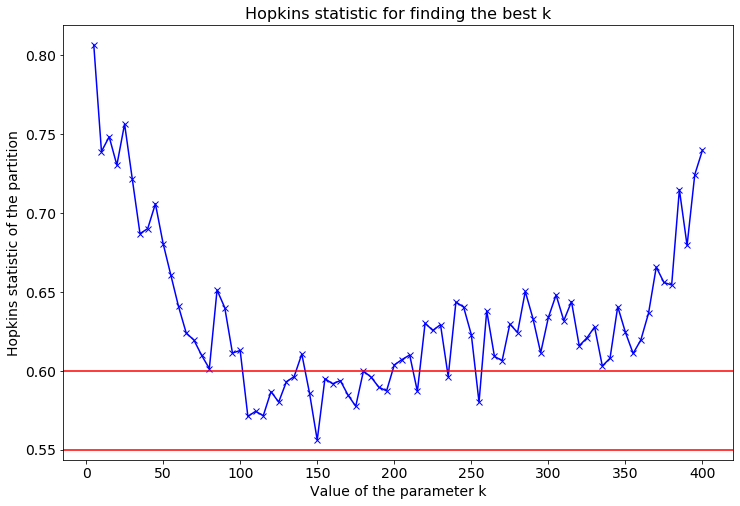

In [245]:
# Plot the results.
print(plt.rcParams["figure.figsize"])
plt.figure(figsize=(12,8))
plt.plot([t[0] for t in list_of_tuples_k_hopkins], [t[1] for t in list_of_tuples_k_hopkins], 'bx-')
plt.xlabel('Value of the parameter k', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Hopkins statistic of the partition', fontsize=14)
plt.yticks(fontsize=14)
plt.title('Hopkins statistic for finding the best k', fontsize=16)
plt.axhline(0.6, color="r")
plt.axhline(0.55, color="r")

In [246]:
list_of_tuples_k_hopkins__copy = list_of_tuples_k_hopkins.copy()
list_of_tuples_k_hopkins__copy.sort(key=lambda x : x[1])
list_of_tuples_k_hopkins__copy

[(150, 0.55611842584778),
 (105, 0.5710875567038175),
 (115, 0.5715325824519422),
 (110, 0.5743104170909903),
 (175, 0.5775154028894794),
 (255, 0.5801112683748464),
 (125, 0.580153098819099),
 (170, 0.5845298247615075),
 (145, 0.5858383951355444),
 (120, 0.5867810875652584),
 (215, 0.5869343626684109),
 (195, 0.5872372526383348),
 (190, 0.5895522762677833),
 (160, 0.5917448054094012),
 (130, 0.5930537448597968),
 (165, 0.5937464441890653),
 (155, 0.5949668170970859),
 (185, 0.5958846110496254),
 (135, 0.5962302711645764),
 (235, 0.5963350651639351),
 (180, 0.5998240308577214),
 (80, 0.6013559879708671),
 (335, 0.6029979664469524),
 (200, 0.6036636381756875),
 (270, 0.6064328887317892),
 (205, 0.6070704707883052),
 (340, 0.6079171784344993),
 (265, 0.6090537750851526),
 (75, 0.6097412955341932),
 (210, 0.6099577048086151),
 (140, 0.6105780987483141),
 (355, 0.6109476165669755),
 (95, 0.6112038144169413),
 (295, 0.611338942447083),
 (100, 0.6128287877906968),
 (320, 0.6158182263442156),

### Elbow method.

In [247]:
first_value_of_k = 5
last_value_of_k = 400
step = 5
range_of_values_of_k = range(first_value_of_k, last_value_of_k+1, step)
list_of_inertias = []
for i in range_of_values_of_k:
    kmeanModel = KMeans(n_clusters=i)
    kmeanModel.fit(mimic_iii_dataset)
    # intertia_  -> Sum of squared distances of samples to their closest cluster center.
    list_of_inertias.append(kmeanModel.inertia_)

[6.0, 4.0]


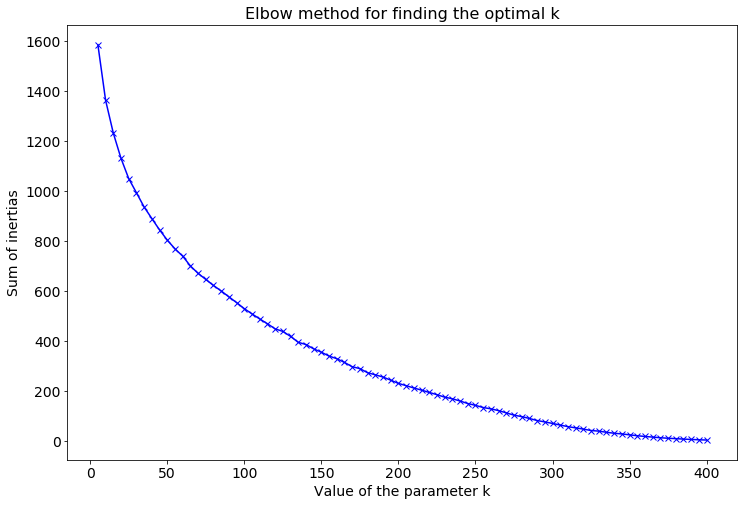

In [248]:
print(plt.rcParams["figure.figsize"])
plt.figure(figsize=(12,8))
plt.plot(range_of_values_of_k, list_of_inertias, 'bx-')
plt.xlabel('Value of the parameter k', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Sum of inertias', fontsize=14)
plt.yticks(fontsize=14)
plt.title('Elbow method for finding the optimal k', fontsize=16)
plt.show()

In [249]:
first_value_of_k = 5
last_value_of_k = 100
step = 5
range_of_values_of_k = range(first_value_of_k, last_value_of_k+1, step)
list_of_inertias = []
for i in range_of_values_of_k:
    kmeanModel = KMeans(n_clusters=i)
    kmeanModel.fit(mimic_iii_dataset)
    # intertia_  -> Sum of squared distances of samples to their closest cluster center.
    list_of_inertias.append(kmeanModel.inertia_)

[6.0, 4.0]


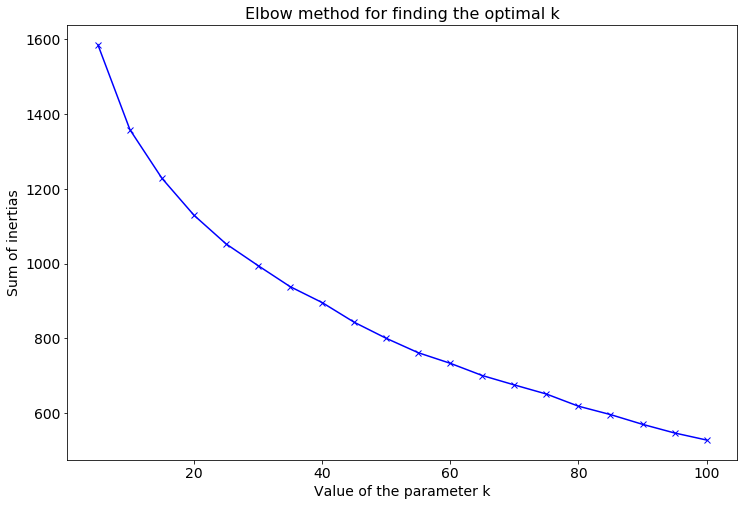

In [250]:
print(plt.rcParams["figure.figsize"])
plt.figure(figsize=(12,8))
plt.plot(range_of_values_of_k, list_of_inertias, 'bx-')
plt.xlabel('Value of the parameter k', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Sum of inertias', fontsize=14)
plt.yticks(fontsize=14)
plt.title('Elbow method for finding the optimal k', fontsize=16)
plt.show()

## 3.6. Trace-based clustering algorithm.

We are going the use the optimal values of $k$, which were obtained above: k=150, k=105 and k=115.

### Experiment 1: k = 150.

In [251]:
# Create the object.
tbc_algorithm_k_150 = TraceBasedClustering(k=150, clustering_algorithm="kmeans", match_function="dice", random_seed=123)

In [252]:
# Generate all partitions from k=2 to k=150.
all_partitions_k_150 = tbc_algorithm_k_150.generateSetOfPartitions(mimic_iii_dataset)

In [253]:
# Generate matrix of matches.
matrix_of_matches_k_150 = tbc_algorithm_k_150.generateMatrixOfMatches(all_partitions_k_150)

[6.0, 4.0]


<Figure size 432x288 with 0 Axes>

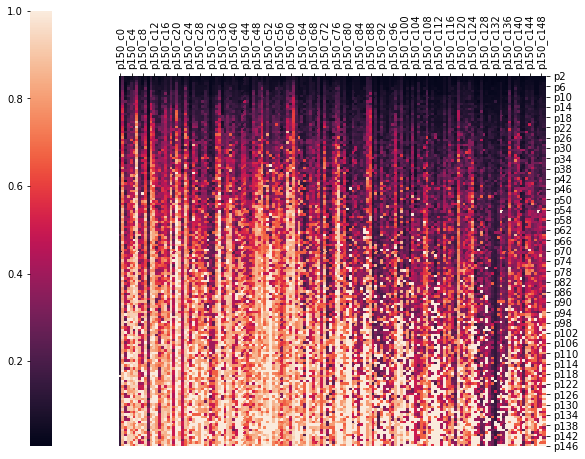

In [254]:
# Visualice matrix of matches.
print(plt.rcParams["figure.figsize"])
heat_map_k_150 = tbc_algorithm_k_150.visualizeMatrixOfMatches(matrix_of_matches_k_150, figsize=(12,8))
heat_map_k_150

#### Postfiltering.

In [255]:
# Number of candidates from mean=0.6 to mean=0.9 (no matter the median).
list_of_thresholds = [str(round(n,2)) for n in np.arange(0.6, 0.95, 0.05)]
list_of_number_of_candidates = []
for n in list_of_thresholds:
    print("Threshold: mean=" + str(n))
    candidates_k_150_n_only_mean = tbc_algorithm_k_150.selectClustersByMeanMedian(matrix_of_matches_k_150, mean_greater_or_equal_than=float(n), median_greater_or_equal_than=25.0, criterion='only_mean')
    list_of_number_of_candidates.append(len(candidates_k_150_n_only_mean))
    print("- Number of candidates: " + str(len(candidates_k_150_n_only_mean)))

Threshold: mean=0.6
- Number of candidates: 41
Threshold: mean=0.65
- Number of candidates: 25
Threshold: mean=0.7
- Number of candidates: 12
Threshold: mean=0.75
- Number of candidates: 8
Threshold: mean=0.8
- Number of candidates: 2
Threshold: mean=0.85
- Number of candidates: 0
Threshold: mean=0.9
- Number of candidates: 0


[6.0, 4.0]


(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 <a list of 10 Text yticklabel objects>)

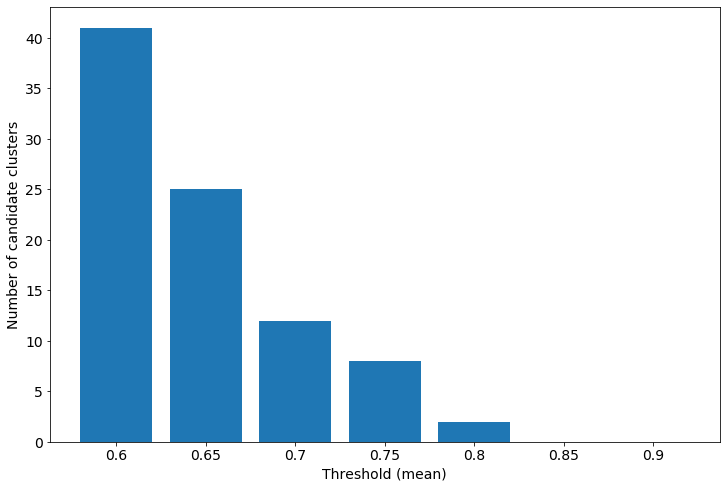

In [256]:
print(plt.rcParams["figure.figsize"])
plt.figure(figsize=(12,8))
plt.bar(list_of_thresholds, list_of_number_of_candidates)
plt.xlabel('Threshold (mean)', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Number of candidate clusters', fontsize=14)
plt.yticks(fontsize=14)

In [257]:
# Show the candidates after postfiltering step.
candidates_k_150 = tbc_algorithm_k_150.selectClustersByMeanMedian(matrix_of_matches_k_150, mean_greater_or_equal_than=0.75, median_greater_or_equal_than=25.0, criterion='only_mean')
candidates_k_150

[('partition150_cluster6',
  'mean=0.8421509027007269',
  'median=0.9230769230769231'),
 ('partition150_cluster11',
  'mean=0.7656345291290338',
  'median=0.8181818181818182'),
 ('partition150_cluster18', 'mean=0.7612699374279633', 'median=0.88'),
 ('partition150_cluster20',
  'mean=0.828874524096344',
  'median=0.9473684210526315'),
 ('partition150_cluster35',
  'mean=0.7898357222298188',
  'median=0.9230769230769231'),
 ('partition150_cluster50',
  'mean=0.759241703330064',
  'median=0.8181818181818182'),
 ('partition150_cluster61', 'mean=0.7967921721160662', 'median=0.88'),
 ('partition150_cluster77',
  'mean=0.7808451625740231',
  'median=0.9230769230769231')]

<Figure size 432x288 with 0 Axes>

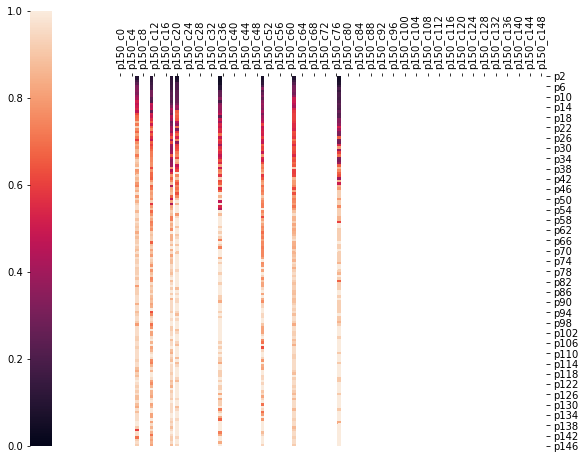

In [258]:
# Visualice matrix of matches after the postfiltering.
number_of_rows = 148
number_of_columns = 150

filtered_matrix_of_matches_k_150 = matrix_of_matches_k_150.copy()
# Mask.
mask = np.zeros_like(filtered_matrix_of_matches_k_150)
list_of_columns = list(range(number_of_columns))
list_of_columns.remove(6)
list_of_columns.remove(11)
list_of_columns.remove(18)
list_of_columns.remove(20)
list_of_columns.remove(35)
list_of_columns.remove(50)
list_of_columns.remove(61)
list_of_columns.remove(77)
list_of_new_values = [(-1, 'X')] * number_of_rows
for i in list_of_columns:
    filtered_matrix_of_matches_k_150['partition' + str(number_of_columns) + '_cluster'+str(i)] = list_of_new_values
    mask[:,i] = [True] * number_of_rows
# For each cell of the matrix of matches (tuple), we only need the first element (value of match).
filtered_matrix_of_matches_k_150 = filtered_matrix_of_matches_k_150.applymap( lambda value : value[0] )
# To avoid long names in the final heat map, we are going to change the names of the rows and the names of the columns.
filtered_matrix_of_matches_k_150.index = ['p'+str(i) for i in range(2,number_of_columns)] # From partition 2 (with 2 clusters) to partition k-1 (with k-1 clusters).
filtered_matrix_of_matches_k_150.columns = ['p'+str(number_of_columns)+'_c'+str(i) for i in range(0,number_of_columns)] # From cluster 0 to cluster 'number_of_clusters_of_partition_k - 1' ('number_of_clusters_of_partition_k' = k).
# Create the heat map.
plt.clf() # If there are previous data, clean them.
plt.figure(figsize=(12,8))
heat_map_axes = heatmap(filtered_matrix_of_matches_k_150, cbar_kws = dict(use_gridspec=False,location="left"), vmin=0, vmax=1, mask=mask)
heat_map_axes.set_position([heat_map_axes.get_position().x0, heat_map_axes.get_position().y0, heat_map_axes.get_position().width * 0.85, heat_map_axes.get_position().height * 0.85])
heat_map_axes.xaxis.tick_top()
heat_map_axes.yaxis.tick_right()
for tick in heat_map_axes.get_xticklabels():
    tick.set_rotation(90)
for tick in heat_map_axes.get_yticklabels():
    tick.set_rotation(0)
heat_map_axes

More information about the candidates shown above:

In [259]:
print("### partition150_cluster6 ###")
elements_partition150_cluster6 = mimic_iii_dataset.loc[all_partitions_k_150[150][6] , ]
print("Number of elements: " + str(len(elements_partition150_cluster6)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition150_cluster6["culture_susceptibility"].value_counts(dropna=False))

### partition150_cluster6 ###
Number of elements: 13
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    12
1.0     1
Name: culture_susceptibility, dtype: int64


In [260]:
print("### partition150_cluster11 ###")
elements_partition150_cluster11 = mimic_iii_dataset.loc[all_partitions_k_150[150][11] , ]
print("Number of elements: " + str(len(elements_partition150_cluster11)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition150_cluster11["culture_susceptibility"].value_counts(dropna=False))

### partition150_cluster11 ###
Number of elements: 12
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    9
1.0    3
Name: culture_susceptibility, dtype: int64


In [261]:
print("### partition150_cluster18 ###")
elements_partition150_cluster18 = mimic_iii_dataset.loc[all_partitions_k_150[150][18] , ]
print("Number of elements: " + str(len(elements_partition150_cluster18)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition150_cluster18["culture_susceptibility"].value_counts(dropna=False))

### partition150_cluster18 ###
Number of elements: 11
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    11
Name: culture_susceptibility, dtype: int64


In [262]:
print("### partition150_cluster20 ###")
elements_partition150_cluster20 = mimic_iii_dataset.loc[all_partitions_k_150[150][20] , ]
print("Number of elements: " + str(len(elements_partition150_cluster20)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition150_cluster20["culture_susceptibility"].value_counts(dropna=False))

### partition150_cluster20 ###
Number of elements: 9
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    9
Name: culture_susceptibility, dtype: int64


In [263]:
print("### partition150_cluster35 ###")
elements_partition150_cluster35 = mimic_iii_dataset.loc[all_partitions_k_150[150][35] , ]
print("Number of elements: " + str(len(elements_partition150_cluster35)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition150_cluster35["culture_susceptibility"].value_counts(dropna=False))

### partition150_cluster35 ###
Number of elements: 7
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
1.0    4
0.0    3
Name: culture_susceptibility, dtype: int64


In [264]:
print("### partition150_cluster50 ###")
elements_partition150_cluster50 = mimic_iii_dataset.loc[all_partitions_k_150[150][50] , ]
print("Number of elements: " + str(len(elements_partition150_cluster50)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition150_cluster50["culture_susceptibility"].value_counts(dropna=False))

### partition150_cluster50 ###
Number of elements: 9
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    8
1.0    1
Name: culture_susceptibility, dtype: int64


In [265]:
print("### partition150_cluster61 ###")
elements_partition150_cluster61 = mimic_iii_dataset.loc[all_partitions_k_150[150][61] , ]
print("Number of elements: " + str(len(elements_partition150_cluster61)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition150_cluster61["culture_susceptibility"].value_counts(dropna=False))

### partition150_cluster61 ###
Number of elements: 12
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    11
1.0     1
Name: culture_susceptibility, dtype: int64


In [266]:
print("### partition150_cluster77 ###")
elements_partition150_cluster77 = mimic_iii_dataset.loc[all_partitions_k_150[150][77] , ]
print("Number of elements: " + str(len(elements_partition150_cluster77)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition150_cluster77["culture_susceptibility"].value_counts(dropna=False))

### partition150_cluster77 ###
Number of elements: 6
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    6
Name: culture_susceptibility, dtype: int64


#### Evaluation based on Random Forest (all candidate names and 'other_cluster').

In [267]:
# Concatenate the needed elements.
X = (mimic_iii_dataset.loc[all_partitions_k_150[150][6] , ]).append( [(mimic_iii_dataset.loc[all_partitions_k_150[150][11] , ]), 
                                                    (mimic_iii_dataset.loc[all_partitions_k_150[150][18] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_150[150][20] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_150[150][35] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_150[150][50] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_150[150][61] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_150[150][77] , ])],
                                                                   ignore_index=False, verify_integrity=True, sort=False)
X_rest_indexes = list( set(mimic_iii_dataset.index).difference(set(X.index)) )
X = X.append(mimic_iii_dataset.loc[X_rest_indexes , ], ignore_index=False, verify_integrity=True, sort=False)

# Class.
y = ( ['partition150_cluster6'] * len(all_partitions_k_150[150][6]) ) + \
    ( ['partition150_cluster11'] * len(all_partitions_k_150[150][11]) ) + \
    ( ['partition150_cluster18'] * len(all_partitions_k_150[150][18]) ) + \
    ( ['partition150_cluster20'] * len(all_partitions_k_150[150][20]) ) + \
    ( ['partition150_cluster35'] * len(all_partitions_k_150[150][35]) ) + \
    ( ['partition150_cluster50'] * len(all_partitions_k_150[150][50]) ) + \
    ( ['partition150_cluster61'] * len(all_partitions_k_150[150][61]) ) + \
    ( ['partition150_cluster77'] * len(all_partitions_k_150[150][77]) ) + \
    ( ['other_cluster'] * len(X_rest_indexes) )

In [268]:
# Create and fit the classifier with stratified 10-folds.
skf = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(n_estimators=100, random_state=50)
list_of_accuracies = []
labels_for_the_confusion_matrix = ['other_cluster', 'partition150_cluster6', 'partition150_cluster11',
                                   'partition150_cluster18', 'partition150_cluster20', 'partition150_cluster35',
                                   'partition150_cluster50', 'partition150_cluster61', 'partition150_cluster77']
final_confusion_matrix = None
fold = 1
for train_index, validation_index in skf.split(X,y):
    X_train = X.iloc[train_index,]
    X_validation = X.iloc[validation_index,]  
    y_train = pd.DataFrame(y).iloc[train_index,0].values.tolist()
    y_validation = pd.DataFrame(y).iloc[validation_index,0].values.tolist()
    clf.fit(X_train, y_train)
    list_of_accuracies.append(clf.score(X_validation,y_validation))
    y_validation_pred = clf.predict(X_validation)
    print("Confusion matrix of the fold " + str(fold) + ".")
    conf_matrix = confusion_matrix(y_validation, y_validation_pred, labels=labels_for_the_confusion_matrix)
    print(conf_matrix)
    if final_confusion_matrix is None:
        final_confusion_matrix = conf_matrix
    else:
        final_confusion_matrix = final_confusion_matrix + conf_matrix
    fold = fold + 1
    print("#######################################")
print("Mean accuracy of the validation with 10-folds: " + str( round(sum(list_of_accuracies)/len(list_of_accuracies),2) ))
print("Final confusion matrix:")
print(final_confusion_matrix)

Confusion matrix of the fold 1.
[[46  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  1]]
#######################################
Confusion matrix of the fold 2.
[[46  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0]
 [ 2  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  1]]
#######################################


C:\Users\almc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Confusion matrix of the fold 3.
[[45  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  1]]
#######################################
Confusion matrix of the fold 4.
[[44  0  0  0  0  0  0  1  0]
 [ 0  1  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  1]]
#######################################
Confusion matrix of the fold 5.
[[45  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  1  0]
 [ 1  0  0  0  0  0  0  0  0]]
###########

#### Evaluation based on Random Forest ('candidate_cluster' and 'other_cluster').

In [269]:
# Concatenate the needed elements.
X = (mimic_iii_dataset.loc[all_partitions_k_150[150][6] , ]).append( [(mimic_iii_dataset.loc[all_partitions_k_150[150][11] , ]), 
                                                    (mimic_iii_dataset.loc[all_partitions_k_150[150][18] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_150[150][20] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_150[150][35] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_150[150][50] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_150[150][61] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_150[150][77] , ])],
                                                                   ignore_index=False, verify_integrity=True, sort=False)
X_rest_indexes = list( set(mimic_iii_dataset.index).difference(set(X.index)) )
X = X.append(mimic_iii_dataset.loc[X_rest_indexes , ], ignore_index=False, verify_integrity=True, sort=False)

# Class.
y = ( ['candidate_cluster'] * len(all_partitions_k_150[150][6]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_150[150][11]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_150[150][18]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_150[150][20]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_150[150][35]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_150[150][50]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_150[150][61]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_150[150][77]) ) + \
    ( ['other_cluster'] * len(X_rest_indexes) )

In [270]:
# Create and fit the classifier with stratified 10-folds.
skf = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(n_estimators=100, random_state=50)
list_of_accuracies = []
labels_for_the_confusion_matrix = ['other_cluster', 'candidate_cluster']
final_confusion_matrix = None
fold = 1
for train_index, validation_index in skf.split(X,y):
    X_train = X.iloc[train_index,]
    X_validation = X.iloc[validation_index,]  
    y_train = pd.DataFrame(y).iloc[train_index,0].values.tolist()
    y_validation = pd.DataFrame(y).iloc[validation_index,0].values.tolist()
    clf.fit(X_train, y_train)
    list_of_accuracies.append(clf.score(X_validation,y_validation))
    y_validation_pred = clf.predict(X_validation)
    print("Confusion matrix of the fold " + str(fold) + ".")
    conf_matrix = confusion_matrix(y_validation, y_validation_pred, labels=labels_for_the_confusion_matrix)
    print(conf_matrix)
    if final_confusion_matrix is None:
        final_confusion_matrix = conf_matrix
    else:
        final_confusion_matrix = final_confusion_matrix + conf_matrix
    fold = fold + 1
    print("#######################################")
print("Mean accuracy of the validation with 10-folds: " + str( round(sum(list_of_accuracies)/len(list_of_accuracies),2) ))
print("Final confusion matrix:")
print(final_confusion_matrix)

Confusion matrix of the fold 1.
[[46  0]
 [ 3  5]]
#######################################
Confusion matrix of the fold 2.
[[46  0]
 [ 3  5]]
#######################################
Confusion matrix of the fold 3.
[[44  1]
 [ 8  0]]
#######################################
Confusion matrix of the fold 4.
[[44  1]
 [ 7  1]]
#######################################
Confusion matrix of the fold 5.
[[45  0]
 [ 4  4]]
#######################################
Confusion matrix of the fold 6.
[[45  0]
 [ 6  2]]
#######################################
Confusion matrix of the fold 7.
[[45  0]
 [ 7  1]]
#######################################
Confusion matrix of the fold 8.
[[44  1]
 [ 4  4]]
#######################################
Confusion matrix of the fold 9.
[[45  0]
 [ 1  7]]
#######################################
Confusion matrix of the fold 10.
[[45  0]
 [ 7  0]]
#######################################
Mean accuracy of the validation with 10-folds: 0.9
Final confusion matrix:
[[449   3]
 [ 

#### Means per row of the matrix J.

In [271]:
matrix_of_matches_k_150_transposed = matrix_of_matches_k_150.T.applymap( lambda value : value[0] )
final_list_of_partitions = list(range(2,150))
final_list_of_means = []
for column in matrix_of_matches_k_150_transposed.columns:
    current_column = matrix_of_matches_k_150_transposed.loc[:, column]
    final_list_of_means.append(current_column.mean())

[6.0, 4.0]


Text(0.5, 1.0, 'Means per rows of the matrix J')

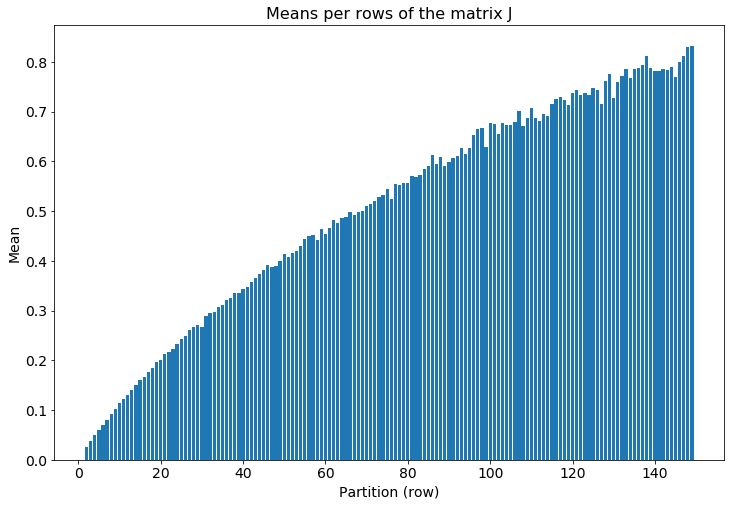

In [272]:
# Means PER ROWS.
print(plt.rcParams["figure.figsize"])
plt.figure(figsize=(12,8))
plt.bar(final_list_of_partitions, final_list_of_means) # IMPORTANT: PER ROWS, NOT PER COLUMNS.
plt.xlabel('Partition (row)', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Mean', fontsize=14)
plt.yticks(fontsize=14)
plt.title('Means per rows of the matrix J', fontsize=16)

#### Histogram of means (of each column) of the matrix J.

In [273]:
# All candidates.
all_candidates_k_150 = tbc_algorithm_k_150.selectClustersByMeanMedian(matrix_of_matches_k_150, mean_greater_or_equal_than=25.0, median_greater_or_equal_than=25.0, criterion='no_measure')
mean = [round(float(i[1].split("=")[1]), 2) for i in all_candidates_k_150]

[6.0, 4.0]


Text(0.5, 1.0, 'Histogram of means (of each column) of the matrix J')

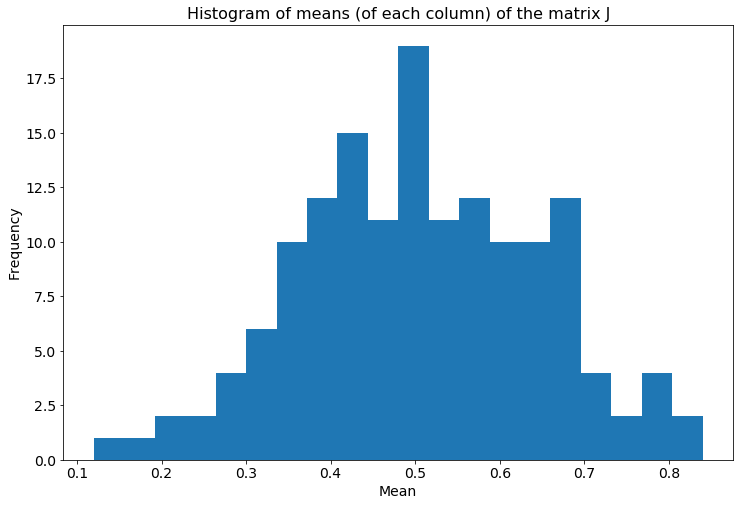

In [274]:
# Histogram of means.
print(plt.rcParams["figure.figsize"])
plt.figure(figsize=(12,8))
plt.hist(mean, density=False, bins=20)

plt.xlabel('Mean', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yticks(fontsize=14)
plt.title('Histogram of means (of each column) of the matrix J', fontsize=16)

### Experiment 2: k = 105.

In [275]:
# Create the object.
tbc_algorithm_k_105 = TraceBasedClustering(k=105, clustering_algorithm="kmeans", match_function="dice", random_seed=369)

In [276]:
# Generate all partitions from k=2 to k=105.
all_partitions_k_105 = tbc_algorithm_k_105.generateSetOfPartitions(mimic_iii_dataset)

In [277]:
# Generate matrix of matches.
matrix_of_matches_k_105 = tbc_algorithm_k_105.generateMatrixOfMatches(all_partitions_k_105)

[6.0, 4.0]


<Figure size 432x288 with 0 Axes>

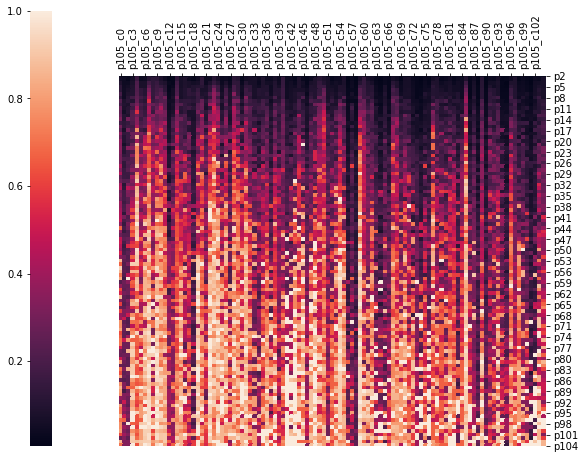

In [278]:
# Visualice matrix of matches.
print(plt.rcParams["figure.figsize"])
heat_map_k_105 = tbc_algorithm_k_105.visualizeMatrixOfMatches(matrix_of_matches_k_105, figsize=(12,8))
heat_map_k_105

#### Postfiltering.

In [279]:
# Number of candidates from mean=0.6 to mean=0.9 (no matter the median).
list_of_thresholds = [str(round(n,2)) for n in np.arange(0.6, 0.95, 0.05)]
list_of_number_of_candidates = []
for n in list_of_thresholds:
    print("Threshold: mean=" + str(n))
    candidates_k_105_n_only_mean = tbc_algorithm_k_105.selectClustersByMeanMedian(matrix_of_matches_k_105, mean_greater_or_equal_than=float(n), median_greater_or_equal_than=25.0, criterion='only_mean')
    list_of_number_of_candidates.append(len(candidates_k_105_n_only_mean))
    print("- Number of candidates: " + str(len(candidates_k_105_n_only_mean)))

Threshold: mean=0.6
- Number of candidates: 22
Threshold: mean=0.65
- Number of candidates: 13
Threshold: mean=0.7
- Number of candidates: 6
Threshold: mean=0.75
- Number of candidates: 3
Threshold: mean=0.8
- Number of candidates: 0
Threshold: mean=0.85
- Number of candidates: 0
Threshold: mean=0.9
- Number of candidates: 0


[6.0, 4.0]


(array([ 0.,  5., 10., 15., 20., 25.]), <a list of 6 Text yticklabel objects>)

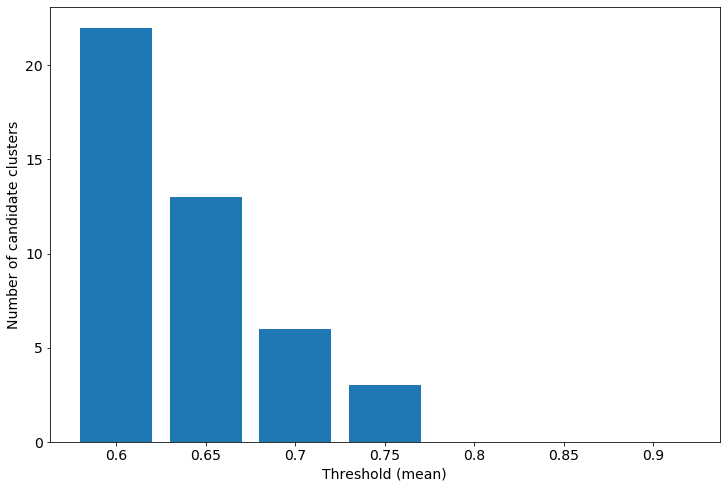

In [280]:
print(plt.rcParams["figure.figsize"])
plt.figure(figsize=(12,8))
plt.bar(list_of_thresholds, list_of_number_of_candidates)
plt.xlabel('Threshold (mean)', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Number of candidate clusters', fontsize=14)
plt.yticks(fontsize=14)

In [281]:
# Show the candidates after postfiltering step.
candidates_k_105 = tbc_algorithm_k_105.selectClustersByMeanMedian(matrix_of_matches_k_105, mean_greater_or_equal_than=0.70, median_greater_or_equal_than=25.0, criterion='only_mean')
candidates_k_105

[('partition105_cluster7',
  'mean=0.7707600731584641',
  'median=0.8461538461538461'),
 ('partition105_cluster9',
  'mean=0.7038488993201188',
  'median=0.8148148148148148'),
 ('partition105_cluster22',
  'mean=0.7253614946207297',
  'median=0.8333333333333334'),
 ('partition105_cluster23',
  'mean=0.7412399500320164',
  'median=0.7857142857142857'),
 ('partition105_cluster59',
  'mean=0.7732565087672499',
  'median=0.8888888888888888'),
 ('partition105_cluster85',
  'mean=0.7670069747704539',
  'median=0.8571428571428571')]

<Figure size 432x288 with 0 Axes>

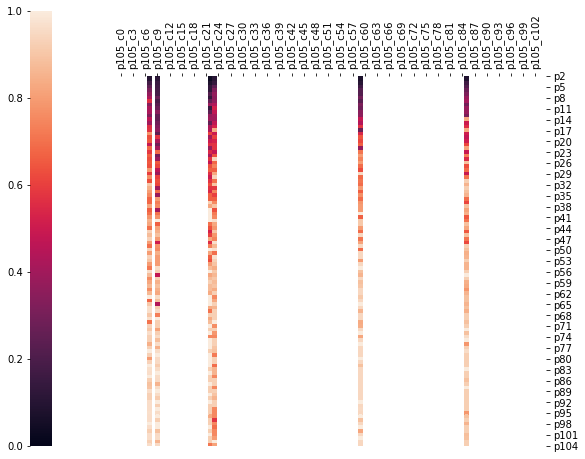

In [282]:
# Visualice matrix of matches after the postfiltering.
number_of_rows = 103
number_of_columns = 105

filtered_matrix_of_matches_k_105 = matrix_of_matches_k_105.copy()
# Mask.
mask = np.zeros_like(filtered_matrix_of_matches_k_105)
list_of_columns = list(range(number_of_columns))
list_of_columns.remove(7)
list_of_columns.remove(9)
list_of_columns.remove(22)
list_of_columns.remove(23)
list_of_columns.remove(59)
list_of_columns.remove(85)
list_of_new_values = [(-1, 'X')] * number_of_rows
for i in list_of_columns:
    filtered_matrix_of_matches_k_105['partition' + str(number_of_columns) + '_cluster'+str(i)] = list_of_new_values
    mask[:,i] = [True] * number_of_rows
# For each cell of the matrix of matches (tuple), we only need the first element (value of match).
filtered_matrix_of_matches_k_105 = filtered_matrix_of_matches_k_105.applymap( lambda value : value[0] )
# To avoid long names in the final heat map, we are going to change the names of the rows and the names of the columns.
filtered_matrix_of_matches_k_105.index = ['p'+str(i) for i in range(2,number_of_columns)] # From partition 2 (with 2 clusters) to partition k-1 (with k-1 clusters).
filtered_matrix_of_matches_k_105.columns = ['p'+str(number_of_columns)+'_c'+str(i) for i in range(0,number_of_columns)] # From cluster 0 to cluster 'number_of_clusters_of_partition_k - 1' ('number_of_clusters_of_partition_k' = k).
# Create the heat map.
plt.clf() # If there are previous data, clean them.
plt.figure(figsize=(12,8))
heat_map_axes = heatmap(filtered_matrix_of_matches_k_105, cbar_kws = dict(use_gridspec=False,location="left"), vmin=0, vmax=1, mask=mask)
heat_map_axes.set_position([heat_map_axes.get_position().x0, heat_map_axes.get_position().y0, heat_map_axes.get_position().width * 0.85, heat_map_axes.get_position().height * 0.85])
heat_map_axes.xaxis.tick_top()
heat_map_axes.yaxis.tick_right()
for tick in heat_map_axes.get_xticklabels():
    tick.set_rotation(90)
for tick in heat_map_axes.get_yticklabels():
    tick.set_rotation(0)
heat_map_axes

More information about the candidates shown above:

In [283]:
print("### partition105_cluster7 ###")
elements_partition105_cluster7 = mimic_iii_dataset.loc[all_partitions_k_105[105][7] , ]
print("Number of elements: " + str(len(elements_partition105_cluster7)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition105_cluster7["culture_susceptibility"].value_counts(dropna=False))

### partition105_cluster7 ###
Number of elements: 14
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    13
1.0     1
Name: culture_susceptibility, dtype: int64


In [284]:
print("### partition105_cluster9 ###")
elements_partition105_cluster9 = mimic_iii_dataset.loc[all_partitions_k_105[105][9] , ]
print("Number of elements: " + str(len(elements_partition105_cluster9)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition105_cluster9["culture_susceptibility"].value_counts(dropna=False))

### partition105_cluster9 ###
Number of elements: 12
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    12
Name: culture_susceptibility, dtype: int64


In [285]:
print("### partition105_cluster22 ###")
elements_partition105_cluster22 = mimic_iii_dataset.loc[all_partitions_k_105[105][22] , ]
print("Number of elements: " + str(len(elements_partition105_cluster22)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition105_cluster22["culture_susceptibility"].value_counts(dropna=False))

### partition105_cluster22 ###
Number of elements: 7
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    6
1.0    1
Name: culture_susceptibility, dtype: int64


In [286]:
print("### partition105_cluster23 ###")
elements_partition105_cluster23 = mimic_iii_dataset.loc[all_partitions_k_105[105][23] , ]
print("Number of elements: " + str(len(elements_partition105_cluster23)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition105_cluster23["culture_susceptibility"].value_counts(dropna=False))

### partition105_cluster23 ###
Number of elements: 15
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    14
1.0     1
Name: culture_susceptibility, dtype: int64


In [287]:
print("### partition105_cluster59 ###")
elements_partition105_cluster59 = mimic_iii_dataset.loc[all_partitions_k_105[105][59] , ]
print("Number of elements: " + str(len(elements_partition105_cluster59)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition105_cluster59["culture_susceptibility"].value_counts(dropna=False))

### partition105_cluster59 ###
Number of elements: 10
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    10
Name: culture_susceptibility, dtype: int64


In [288]:
print("### partition105_cluster85 ###")
elements_partition105_cluster85 = mimic_iii_dataset.loc[all_partitions_k_105[105][85] , ]
print("Number of elements: " + str(len(elements_partition105_cluster85)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition105_cluster85["culture_susceptibility"].value_counts(dropna=False))

### partition105_cluster85 ###
Number of elements: 12
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    10
1.0     2
Name: culture_susceptibility, dtype: int64


#### Evaluation based on Random Forest (all candidate names and 'other_cluster').

In [289]:
# Concatenate the needed elements.
X = (mimic_iii_dataset.loc[all_partitions_k_105[105][7] , ]).append( [(mimic_iii_dataset.loc[all_partitions_k_105[105][9] , ]), 
                                                    (mimic_iii_dataset.loc[all_partitions_k_105[105][22] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_105[105][23] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_105[105][59] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_105[105][85] , ])],
                                                                   ignore_index=False, verify_integrity=True, sort=False)
X_rest_indexes = list( set(mimic_iii_dataset.index).difference(set(X.index)) )
X = X.append(mimic_iii_dataset.loc[X_rest_indexes , ], ignore_index=False, verify_integrity=True, sort=False)

# Class.
y = ( ['partition105_cluster7'] * len(all_partitions_k_105[105][7]) ) + \
    ( ['partition105_cluster9'] * len(all_partitions_k_105[105][9]) ) + \
    ( ['partition105_cluster22'] * len(all_partitions_k_105[105][22]) ) + \
    ( ['partition105_cluster23'] * len(all_partitions_k_105[105][23]) ) + \
    ( ['partition105_cluster59'] * len(all_partitions_k_105[105][59]) ) + \
    ( ['partition105_cluster85'] * len(all_partitions_k_105[105][85]) ) + \
    ( ['other_cluster'] * len(X_rest_indexes) )

In [290]:
# Create and fit the classifier with stratified 10-folds.
skf = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(n_estimators=100, random_state=50)
list_of_accuracies = []
labels_for_the_confusion_matrix = ['other_cluster', 'partition105_cluster7', 'partition105_cluster9',
                                   'partition105_cluster22', 'partition105_cluster23', 'partition105_cluster59',
                                   'partition105_cluster85']
final_confusion_matrix = None
fold = 1
for train_index, validation_index in skf.split(X,y):
    X_train = X.iloc[train_index,]
    X_validation = X.iloc[validation_index,]  
    y_train = pd.DataFrame(y).iloc[train_index,0].values.tolist()
    y_validation = pd.DataFrame(y).iloc[validation_index,0].values.tolist()
    clf.fit(X_train, y_train)
    list_of_accuracies.append(clf.score(X_validation,y_validation))
    y_validation_pred = clf.predict(X_validation)
    print("Confusion matrix of the fold " + str(fold) + ".")
    conf_matrix = confusion_matrix(y_validation, y_validation_pred, labels=labels_for_the_confusion_matrix)
    print(conf_matrix)
    if final_confusion_matrix is None:
        final_confusion_matrix = conf_matrix
    else:
        final_confusion_matrix = final_confusion_matrix + conf_matrix
    fold = fold + 1
    print("#######################################")
print("Mean accuracy of the validation with 10-folds: " + str( round(sum(list_of_accuracies)/len(list_of_accuracies),2) ))
print("Final confusion matrix:")
print(final_confusion_matrix)

Confusion matrix of the fold 1.
[[47  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0]
 [ 1  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  1  0  0]
 [ 1  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0]]
#######################################
Confusion matrix of the fold 2.


C:\Users\almc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[[46  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0]
 [ 0  0  2  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  0  2  0  0]
 [ 1  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0]]
#######################################
Confusion matrix of the fold 3.
[[46  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0]
 [ 0  0  1  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 1  0  0  0  1  0  0]
 [ 0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  1]]
#######################################
Confusion matrix of the fold 4.
[[44  2  0  0  0  0  0]
 [ 0  2  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  0  2  0  0]
 [ 0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  1]]
#######################################
Confusion matrix of the fold 5.
[[46  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0]
 [ 0  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0]
 [ 0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  1]]
#######################################
Confusion matrix of the fold 6.
[[46  0  0  0  0  0  0]
 [ 0  1  0  

#### Evaluation based on Random Forest ('candidate_cluster' and 'other_cluster').

In [291]:
# Concatenate the needed elements.
X = (mimic_iii_dataset.loc[all_partitions_k_105[105][7] , ]).append( [(mimic_iii_dataset.loc[all_partitions_k_105[105][9] , ]), 
                                                    (mimic_iii_dataset.loc[all_partitions_k_105[105][22] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_105[105][23] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_105[105][59] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_105[105][85] , ])],
                                                                   ignore_index=False, verify_integrity=True, sort=False)
X_rest_indexes = list( set(mimic_iii_dataset.index).difference(set(X.index)) )
X = X.append(mimic_iii_dataset.loc[X_rest_indexes , ], ignore_index=False, verify_integrity=True, sort=False)

# Class.
y = ( ['candidate_cluster'] * len(all_partitions_k_105[105][7]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_105[105][9]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_105[105][22]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_105[105][23]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_105[105][59]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_105[105][85]) ) + \
    ( ['other_cluster'] * len(X_rest_indexes) )

In [292]:
# Create and fit the classifier with stratified 10-folds.
skf = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(n_estimators=100, random_state=50)
list_of_accuracies = []
labels_for_the_confusion_matrix = ['other_cluster', 'candidate_cluster']
final_confusion_matrix = None
fold = 1
for train_index, validation_index in skf.split(X,y):
    X_train = X.iloc[train_index,]
    X_validation = X.iloc[validation_index,]  
    y_train = pd.DataFrame(y).iloc[train_index,0].values.tolist()
    y_validation = pd.DataFrame(y).iloc[validation_index,0].values.tolist()
    clf.fit(X_train, y_train)
    list_of_accuracies.append(clf.score(X_validation,y_validation))
    y_validation_pred = clf.predict(X_validation)
    print("Confusion matrix of the fold " + str(fold) + ".")
    conf_matrix = confusion_matrix(y_validation, y_validation_pred, labels=labels_for_the_confusion_matrix)
    print(conf_matrix)
    if final_confusion_matrix is None:
        final_confusion_matrix = conf_matrix
    else:
        final_confusion_matrix = final_confusion_matrix + conf_matrix
    fold = fold + 1
    print("#######################################")
print("Mean accuracy of the validation with 10-folds: " + str( round(sum(list_of_accuracies)/len(list_of_accuracies),2) ))
print("Final confusion matrix:")
print(final_confusion_matrix)

Confusion matrix of the fold 1.
[[47  0]
 [ 1  6]]
#######################################
Confusion matrix of the fold 2.
[[46  0]
 [ 2  5]]
#######################################
Confusion matrix of the fold 3.
[[46  0]
 [ 7  0]]
#######################################
Confusion matrix of the fold 4.
[[44  2]
 [ 3  4]]
#######################################
Confusion matrix of the fold 5.
[[46  0]
 [ 4  3]]
#######################################
Confusion matrix of the fold 6.
[[46  0]
 [ 6  1]]
#######################################
Confusion matrix of the fold 7.
[[46  0]
 [ 6  1]]
#######################################
Confusion matrix of the fold 8.
[[45  1]
 [ 7  0]]
#######################################
Confusion matrix of the fold 9.
[[46  0]
 [ 5  2]]
#######################################
Confusion matrix of the fold 10.
[[46  0]
 [ 0  7]]
#######################################
Mean accuracy of the validation with 10-folds: 0.92
Final confusion matrix:
[[458   3]
 [

### Experiment 3: k = 115.

In [293]:
# Create the object.
tbc_algorithm_k_115 = TraceBasedClustering(k=115, clustering_algorithm="kmeans", match_function="dice", random_seed=741)

In [294]:
# Generate all partitions from k=2 to k=115.
all_partitions_k_115 = tbc_algorithm_k_115.generateSetOfPartitions(mimic_iii_dataset)

In [295]:
# Generate matrix of matches.
matrix_of_matches_k_115 = tbc_algorithm_k_115.generateMatrixOfMatches(all_partitions_k_115)

[6.0, 4.0]


<Figure size 432x288 with 0 Axes>

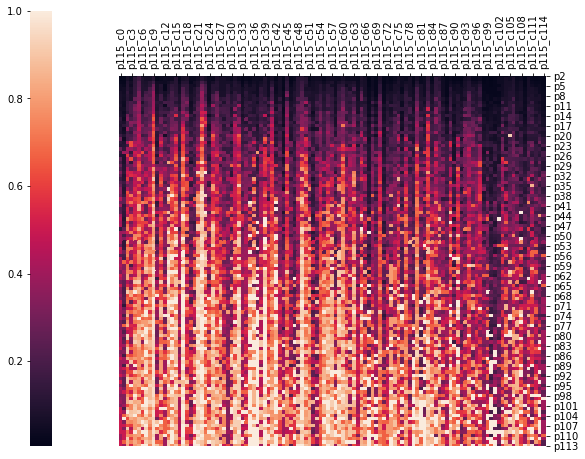

In [296]:
# Visualice matrix of matches.
print(plt.rcParams["figure.figsize"])
heat_map_k_115 = tbc_algorithm_k_115.visualizeMatrixOfMatches(matrix_of_matches_k_115, figsize=(12,8))
heat_map_k_115

#### Postfiltering.

In [297]:
# Number of candidates from mean=0.6 to mean=0.9 (no matter the median).
list_of_thresholds = [str(round(n,2)) for n in np.arange(0.6, 0.95, 0.05)]
list_of_number_of_candidates = []
for n in list_of_thresholds:
    print("Threshold: mean=" + str(n))
    candidates_k_115_n_only_mean = tbc_algorithm_k_115.selectClustersByMeanMedian(matrix_of_matches_k_115, mean_greater_or_equal_than=float(n), median_greater_or_equal_than=25.0, criterion='only_mean')
    list_of_number_of_candidates.append(len(candidates_k_115_n_only_mean))
    print("- Number of candidates: " + str(len(candidates_k_115_n_only_mean)))

Threshold: mean=0.6
- Number of candidates: 27
Threshold: mean=0.65
- Number of candidates: 13
Threshold: mean=0.7
- Number of candidates: 5
Threshold: mean=0.75
- Number of candidates: 3
Threshold: mean=0.8
- Number of candidates: 1
Threshold: mean=0.85
- Number of candidates: 0
Threshold: mean=0.9
- Number of candidates: 0


[6.0, 4.0]


(array([ 0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 7 Text yticklabel objects>)

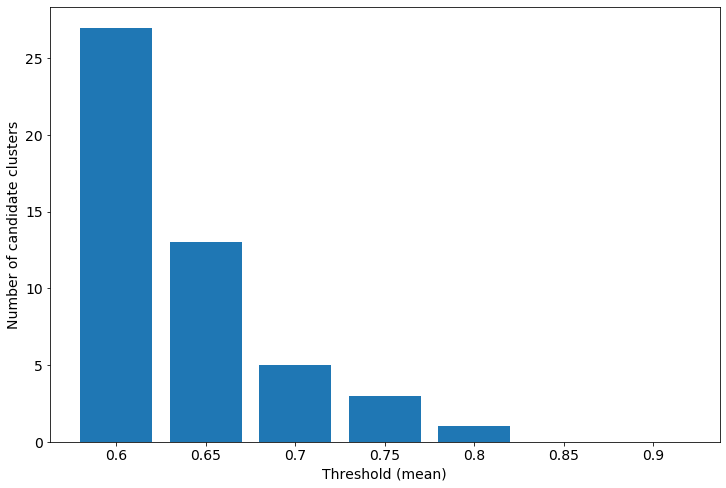

In [298]:
print(plt.rcParams["figure.figsize"])
plt.figure(figsize=(12,8))
plt.bar(list_of_thresholds, list_of_number_of_candidates)
plt.xlabel('Threshold (mean)', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Number of candidate clusters', fontsize=14)
plt.yticks(fontsize=14)

In [299]:
# Show the candidates after postfiltering step.
candidates_k_115 = tbc_algorithm_k_115.selectClustersByMeanMedian(matrix_of_matches_k_115, mean_greater_or_equal_than=0.7, median_greater_or_equal_than=25.0, criterion='only_mean')
candidates_k_115

[('partition115_cluster9',
  'mean=0.7974520585630802',
  'median=0.8888888888888888'),
 ('partition115_cluster17', 'mean=0.7813949710482857', 'median=0.9'),
 ('partition115_cluster22',
  'mean=0.8280744508956546',
  'median=0.9285714285714286'),
 ('partition115_cluster39',
  'mean=0.7189666657838094',
  'median=0.8571428571428571'),
 ('partition115_cluster49',
  'mean=0.7421778434726192',
  'median=0.8888888888888888')]

<Figure size 432x288 with 0 Axes>

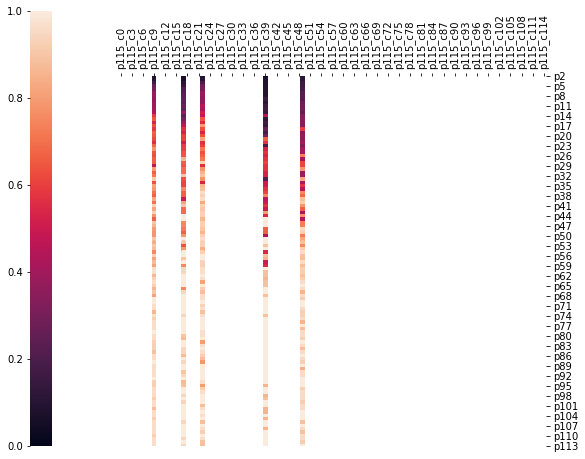

In [300]:
# Visualice matrix of matches after the postfiltering.
number_of_rows = 113
number_of_columns = 115

filtered_matrix_of_matches_k_115 = matrix_of_matches_k_115.copy()
# Mask.
mask = np.zeros_like(filtered_matrix_of_matches_k_115)
list_of_columns = list(range(number_of_columns))
list_of_columns.remove(9)
list_of_columns.remove(17)
list_of_columns.remove(22)
list_of_columns.remove(39)
list_of_columns.remove(49)
list_of_new_values = [(-1, 'X')] * number_of_rows
for i in list_of_columns:
    filtered_matrix_of_matches_k_115['partition' + str(number_of_columns) + '_cluster'+str(i)] = list_of_new_values
    mask[:,i] = [True] * number_of_rows
# For each cell of the matrix of matches (tuple), we only need the first element (value of match).
filtered_matrix_of_matches_k_115 = filtered_matrix_of_matches_k_115.applymap( lambda value : value[0] )
# To avoid long names in the final heat map, we are going to change the names of the rows and the names of the columns.
filtered_matrix_of_matches_k_115.index = ['p'+str(i) for i in range(2,number_of_columns)] # From partition 2 (with 2 clusters) to partition k-1 (with k-1 clusters).
filtered_matrix_of_matches_k_115.columns = ['p'+str(number_of_columns)+'_c'+str(i) for i in range(0,number_of_columns)] # From cluster 0 to cluster 'number_of_clusters_of_partition_k - 1' ('number_of_clusters_of_partition_k' = k).
# Create the heat map.
plt.clf() # If there are previous data, clean them.
plt.figure(figsize=(12,8))
heat_map_axes = heatmap(filtered_matrix_of_matches_k_115, cbar_kws = dict(use_gridspec=False,location="left"), vmin=0, vmax=1, mask=mask)
heat_map_axes.set_position([heat_map_axes.get_position().x0, heat_map_axes.get_position().y0, heat_map_axes.get_position().width * 0.85, heat_map_axes.get_position().height * 0.85])
heat_map_axes.xaxis.tick_top()
heat_map_axes.yaxis.tick_right()
for tick in heat_map_axes.get_xticklabels():
    tick.set_rotation(90)
for tick in heat_map_axes.get_yticklabels():
    tick.set_rotation(0)
heat_map_axes

More information about the candidates shown above:

In [301]:
print("### partition115_cluster9 ###")
elements_partition115_cluster9 = mimic_iii_dataset.loc[all_partitions_k_115[115][9] , ]
print("Number of elements: " + str(len(elements_partition115_cluster9)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition115_cluster9["culture_susceptibility"].value_counts(dropna=False))

### partition115_cluster9 ###
Number of elements: 14
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    13
1.0     1
Name: culture_susceptibility, dtype: int64


In [302]:
print("### partition115_cluster17 ###")
elements_partition115_cluster17 = mimic_iii_dataset.loc[all_partitions_k_115[115][17] , ]
print("Number of elements: " + str(len(elements_partition115_cluster17)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition115_cluster17["culture_susceptibility"].value_counts(dropna=False))

### partition115_cluster17 ###
Number of elements: 9
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    9
Name: culture_susceptibility, dtype: int64


In [303]:
print("### partition115_cluster22 ###")
elements_partition115_cluster22 = mimic_iii_dataset.loc[all_partitions_k_115[115][22] , ]
print("Number of elements: " + str(len(elements_partition115_cluster22)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition115_cluster22["culture_susceptibility"].value_counts(dropna=False))

### partition115_cluster22 ###
Number of elements: 14
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    12
1.0     2
Name: culture_susceptibility, dtype: int64


In [304]:
print("### partition115_cluster39 ###")
elements_partition115_cluster39 = mimic_iii_dataset.loc[all_partitions_k_115[115][39] , ]
print("Number of elements: " + str(len(elements_partition115_cluster39)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition115_cluster39["culture_susceptibility"].value_counts(dropna=False))

### partition115_cluster39 ###
Number of elements: 4
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
1.0    4
Name: culture_susceptibility, dtype: int64


In [305]:
print("### partition115_cluster49 ###")
elements_partition115_cluster49 = mimic_iii_dataset.loc[all_partitions_k_115[115][49] , ]
print("Number of elements: " + str(len(elements_partition115_cluster49)))
print("Value counts (0.0 -> Resistant ; 1.0 -> Sensible):")
print(elements_partition115_cluster49["culture_susceptibility"].value_counts(dropna=False))

### partition115_cluster49 ###
Number of elements: 12
Value counts (0.0 -> Resistant ; 1.0 -> Sensible):
0.0    12
Name: culture_susceptibility, dtype: int64


#### Evaluation based on Random Forest (all candidate names and 'other_cluster').

In [306]:
# Concatenate the needed elements.
X = (mimic_iii_dataset.loc[all_partitions_k_115[115][9] , ]).append( [(mimic_iii_dataset.loc[all_partitions_k_115[115][17] , ]), 
                                                    (mimic_iii_dataset.loc[all_partitions_k_115[115][22] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_115[115][39] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_115[115][49] , ])],
                                                                   ignore_index=False, verify_integrity=True, sort=False)
X_rest_indexes = list( set(mimic_iii_dataset.index).difference(set(X.index)) )
X = X.append(mimic_iii_dataset.loc[X_rest_indexes , ], ignore_index=False, verify_integrity=True, sort=False)

# Class.
y = ( ['partition115_cluster9'] * len(all_partitions_k_115[115][9]) ) + \
    ( ['partition115_cluster17'] * len(all_partitions_k_115[115][17]) ) + \
    ( ['partition115_cluster22'] * len(all_partitions_k_115[115][22]) ) + \
    ( ['partition115_cluster39'] * len(all_partitions_k_115[115][39]) ) + \
    ( ['partition115_cluster49'] * len(all_partitions_k_115[115][49]) ) + \
    ( ['other_cluster'] * len(X_rest_indexes) )

In [307]:
# Create and fit the classifier with stratified 10-folds.
skf = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(n_estimators=100, random_state=50)
list_of_accuracies = []
labels_for_the_confusion_matrix = ['other_cluster', 'partition115_cluster9', 'partition115_cluster17',
                                   'partition115_cluster22', 'partition115_cluster39', 'partition115_cluster49']
final_confusion_matrix = None
fold = 1
for train_index, validation_index in skf.split(X,y):
    X_train = X.iloc[train_index,]
    X_validation = X.iloc[validation_index,]  
    y_train = pd.DataFrame(y).iloc[train_index,0].values.tolist()
    y_validation = pd.DataFrame(y).iloc[validation_index,0].values.tolist()
    clf.fit(X_train, y_train)
    list_of_accuracies.append(clf.score(X_validation,y_validation))
    y_validation_pred = clf.predict(X_validation)
    print("Confusion matrix of the fold " + str(fold) + ".")
    conf_matrix = confusion_matrix(y_validation, y_validation_pred, labels=labels_for_the_confusion_matrix)
    print(conf_matrix)
    if final_confusion_matrix is None:
        final_confusion_matrix = conf_matrix
    else:
        final_confusion_matrix = final_confusion_matrix + conf_matrix
    fold = fold + 1
    print("#######################################")
print("Mean accuracy of the validation with 10-folds: " + str( round(sum(list_of_accuracies)/len(list_of_accuracies),2) ))
print("Final confusion matrix:")
print(final_confusion_matrix)

Confusion matrix of the fold 1.
[[48  0  0  0  0  0]
 [ 1  1  0  0  0  0]
 [ 1  0  0  0  0  0]
 [ 1  0  0  1  0  0]
 [ 1  0  0  0  0  0]
 [ 1  0  0  0  0  1]]
#######################################
Confusion matrix of the fold 2.
[[48  0  0  0  0  0]
 [ 0  2  0  0  0  0]
 [ 1  0  0  0  0  0]
 [ 0  2  0  0  0  0]
 [ 0  0  0  0  1  0]
 [ 2  0  0  0  0  0]]
#######################################


C:\Users\almc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Confusion matrix of the fold 3.
[[48  0  0  0  0  0]
 [ 0  2  0  0  0  0]
 [ 0  0  1  0  0  0]
 [ 2  0  0  0  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0  1]]
#######################################
Confusion matrix of the fold 4.
[[48  0  0  0  0  0]
 [ 0  2  0  0  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0  0  2  0  0]
 [ 1  0  0  0  0  0]
 [ 1  0  0  0  0  0]]
#######################################
Confusion matrix of the fold 5.
[[48  0  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  1]]
#######################################
Confusion matrix of the fold 6.
[[48  0  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  1]]
#######################################
Confusion matrix of the fold 7.
[[48  0  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  1]]
#######################################
Confu

#### Evaluation based on Random Forest ('candidate_cluster' and 'other_cluster').

In [308]:
# Concatenate the needed elements.
X = (mimic_iii_dataset.loc[all_partitions_k_115[115][9] , ]).append( [(mimic_iii_dataset.loc[all_partitions_k_115[115][17] , ]), 
                                                    (mimic_iii_dataset.loc[all_partitions_k_115[115][22] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_115[115][39] , ]),
                                                    (mimic_iii_dataset.loc[all_partitions_k_115[115][49] , ])],
                                                                   ignore_index=False, verify_integrity=True, sort=False)
X_rest_indexes = list( set(mimic_iii_dataset.index).difference(set(X.index)) )
X = X.append(mimic_iii_dataset.loc[X_rest_indexes , ], ignore_index=False, verify_integrity=True, sort=False)

# Class.
y = ( ['candidate_cluster'] * len(all_partitions_k_115[115][9]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_115[115][17]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_115[115][22]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_115[115][39]) ) + \
    ( ['candidate_cluster'] * len(all_partitions_k_115[115][49]) ) + \
    ( ['other_cluster'] * len(X_rest_indexes) )

In [309]:
# Create and fit the classifier with stratified 10-folds.
skf = StratifiedKFold(n_splits=10)
clf = RandomForestClassifier(n_estimators=100, random_state=50)
list_of_accuracies = []
labels_for_the_confusion_matrix = ['other_cluster', 'candidate_cluster']
final_confusion_matrix = None
fold = 1
for train_index, validation_index in skf.split(X,y):
    X_train = X.iloc[train_index,]
    X_validation = X.iloc[validation_index,]  
    y_train = pd.DataFrame(y).iloc[train_index,0].values.tolist()
    y_validation = pd.DataFrame(y).iloc[validation_index,0].values.tolist()
    clf.fit(X_train, y_train)
    list_of_accuracies.append(clf.score(X_validation,y_validation))
    y_validation_pred = clf.predict(X_validation)
    print("Confusion matrix of the fold " + str(fold) + ".")
    conf_matrix = confusion_matrix(y_validation, y_validation_pred, labels=labels_for_the_confusion_matrix)
    print(conf_matrix)
    if final_confusion_matrix is None:
        final_confusion_matrix = conf_matrix
    else:
        final_confusion_matrix = final_confusion_matrix + conf_matrix
    fold = fold + 1
    print("#######################################")
print("Mean accuracy of the validation with 10-folds: " + str( round(sum(list_of_accuracies)/len(list_of_accuracies),2) ))
print("Final confusion matrix:")
print(final_confusion_matrix)

Confusion matrix of the fold 1.
[[48  0]
 [ 1  5]]
#######################################
Confusion matrix of the fold 2.
[[48  0]
 [ 0  6]]
#######################################
Confusion matrix of the fold 3.
[[48  0]
 [ 5  1]]
#######################################
Confusion matrix of the fold 4.
[[48  0]
 [ 2  3]]
#######################################
Confusion matrix of the fold 5.
[[48  0]
 [ 2  3]]
#######################################
Confusion matrix of the fold 6.
[[48  0]
 [ 0  5]]
#######################################
Confusion matrix of the fold 7.
[[48  0]
 [ 1  4]]
#######################################
Confusion matrix of the fold 8.
[[48  0]
 [ 5  0]]
#######################################
Confusion matrix of the fold 9.
[[47  0]
 [ 5  0]]
#######################################
Confusion matrix of the fold 10.
[[47  0]
 [ 4  1]]
#######################################
Mean accuracy of the validation with 10-folds: 0.95
Final confusion matrix:
[[478   0]
 [

### Candidate clusters throughout the three experiments that contain the same elements.

In [310]:
p_150_candidates = [6,11,18,20,35,50,61,77]
p_105_candidates = [7,9,22,23,59,85]
p_115_candidates = [9,17,22,39,49]

Experiment 1 (k=150) and experiment 2 (k=105).

In [311]:
for x in p_150_candidates:
    current_cluster_of_p_150 = all_partitions_k_150[150][x].copy()
    current_cluster_of_p_150.sort()
    for y in p_105_candidates:
        current_cluster_of_p_105 = all_partitions_k_105[105][y].copy()
        current_cluster_of_p_105.sort()
        if ( current_cluster_of_p_150 == current_cluster_of_p_105 ):
            print("The elements of partition150_cluster" + str(x) + " and partition105_cluster" + str(y) + " are the same.")

Experiment 1 (k=150) and experiment 3 (k=115).

In [312]:
for x in p_150_candidates:
    current_cluster_of_p_150 = all_partitions_k_150[150][x].copy()
    current_cluster_of_p_150.sort()
    for y in p_115_candidates:
        current_cluster_of_p_115 = all_partitions_k_115[115][y].copy()
        current_cluster_of_p_115.sort()
        if ( current_cluster_of_p_150 == current_cluster_of_p_115 ):
            print("The elements of partition150_cluster" + str(x) + " and partition115_cluster" + str(y) + " are the same.")

The elements of partition150_cluster20 and partition115_cluster17 are the same.


Experiment 2 (k=105) and experiment 3 (k=115).

In [313]:
for x in p_105_candidates:
    current_cluster_of_p_105 = all_partitions_k_105[105][x].copy()
    current_cluster_of_p_105.sort()
    for y in p_115_candidates:
        current_cluster_of_p_115 = all_partitions_k_115[115][y].copy()
        current_cluster_of_p_115.sort()
        if ( current_cluster_of_p_105 == current_cluster_of_p_115 ):
            print("The elements of partition105_cluster" + str(x) + " and partition115_cluster" + str(y) + " are the same.")

The elements of partition105_cluster7 and partition115_cluster9 are the same.
The elements of partition105_cluster9 and partition115_cluster49 are the same.


## 3.7. Comparison with traditional algorithms in term of stability.

In [314]:
def number_of_elements_together__majority(list_of_cluster_numbers):
    df = pd.DataFrame(list_of_cluster_numbers)
    value_counts = df.value_counts()
    return max(value_counts)
    
# Tests.
print(number_of_elements_together__majority([0,0,0,1,2,3,4,4,4,5,10,10,10,10,10,10]))
print(number_of_elements_together__majority([0,0,0,1,2,3,4,4,4,5]))
print(number_of_elements_together__majority([0,1,2,3,4,4,5]))

6
3
2


In [315]:
## Experiment 1 (k = 150)

elements_p150_c6 = all_partitions_k_150[150][6]
elements_p150_c11 = all_partitions_k_150[150][11]
elements_p150_c18 = all_partitions_k_150[150][18]
elements_p150_c20 = all_partitions_k_150[150][20]
elements_p150_c35 = all_partitions_k_150[150][35]
elements_p150_c50 = all_partitions_k_150[150][50]
elements_p150_c61 = all_partitions_k_150[150][61]
elements_p150_c77 = all_partitions_k_150[150][77]

In [316]:
## Experiment 2 (k = 105)

elements_p105_c7 = all_partitions_k_105[105][7]
elements_p105_c9 = all_partitions_k_105[105][9]
elements_p105_c22 = all_partitions_k_105[105][22]
elements_p105_c23 = all_partitions_k_105[105][23]
elements_p105_c59 = all_partitions_k_105[105][59]
elements_p105_c85 = all_partitions_k_105[105][85]

In [317]:
## Experiment 3 (k = 115)

elements_p115_c9 = all_partitions_k_115[115][9]
elements_p115_c17 = all_partitions_k_115[115][17]
elements_p115_c22 = all_partitions_k_115[115][22]
elements_p115_c39 = all_partitions_k_115[115][39]
elements_p115_c49 = all_partitions_k_115[115][49]

### KMeans.

In [318]:
## Experiment 1 (k = 150)

k = 150
n_iter = 200

p150_c6_appears = []
p150_c11_appears = []
p150_c18_appears = []
p150_c20_appears = []
p150_c35_appears = []
p150_c50_appears = []
p150_c61_appears = []
p150_c77_appears = []

range_as_list = list(range(0, n_iter*10, 10))
assert(len(range_as_list) == n_iter)

for r in range_as_list:
    kmeans_result = KMeans(n_clusters=k, random_state=r).fit(mimic_iii_dataset)
    elements_p150_c6_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p150_c6])
    p150_c6_appears.append(elements_p150_c6_in_the_same_cluster / len(elements_p150_c6) * 100)
    elements_p150_c11_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p150_c11])
    p150_c11_appears.append(elements_p150_c11_in_the_same_cluster / len(elements_p150_c11) * 100)
    elements_p150_c18_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p150_c18])
    p150_c18_appears.append(elements_p150_c18_in_the_same_cluster / len(elements_p150_c18) * 100)
    elements_p150_c20_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p150_c20])
    p150_c20_appears.append(elements_p150_c20_in_the_same_cluster / len(elements_p150_c20) * 100)
    elements_p150_c35_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p150_c35])
    p150_c35_appears.append(elements_p150_c35_in_the_same_cluster / len(elements_p150_c35) * 100)
    elements_p150_c50_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p150_c50])
    p150_c50_appears.append(elements_p150_c50_in_the_same_cluster / len(elements_p150_c50) * 100)
    elements_p150_c61_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p150_c61])
    p150_c61_appears.append(elements_p150_c61_in_the_same_cluster / len(elements_p150_c61) * 100)
    elements_p150_c77_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p150_c77])
    p150_c77_appears.append(elements_p150_c77_in_the_same_cluster / len(elements_p150_c77) * 100)
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c6: " + str(sum(p150_c6_appears)/len(p150_c6_appears)) + "%")
print("p150_c6," + str(p150_c6_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c11: " + str(sum(p150_c11_appears)/len(p150_c11_appears)) + "%")
print("p150_c11," + str(p150_c11_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c18: " + str(sum(p150_c18_appears)/len(p150_c18_appears)) + "%")
print("p150_c18," + str(p150_c18_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c20: " + str(sum(p150_c20_appears)/len(p150_c20_appears)) + "%")
print("p150_c20," + str(p150_c20_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c35: " + str(sum(p150_c35_appears)/len(p150_c35_appears)) + "%")
print("p150_c35," + str(p150_c35_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c50: " + str(sum(p150_c50_appears)/len(p150_c50_appears)) + "%")
print("p150_c50," + str(p150_c50_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c61: " + str(sum(p150_c61_appears)/len(p150_c61_appears)) + "%")
print("p150_c61," + str(p150_c61_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c77: " + str(sum(p150_c77_appears)/len(p150_c77_appears)) + "%")
print("p150_c77," + str(p150_c77_appears))
print("-------------------------------------------------------")

-------------------------------------------------------
Experiment 1 (k = 150) - p150_c6: 90.11538461538449%
p150_c6,[92.3076923076923, 100.0, 100.0, 100.0, 84.61538461538461, 100.0, 100.0, 76.92307692307693, 76.92307692307693, 84.61538461538461, 100.0, 100.0, 100.0, 76.92307692307693, 100.0, 76.92307692307693, 100.0, 100.0, 76.92307692307693, 76.92307692307693, 84.61538461538461, 84.61538461538461, 84.61538461538461, 84.61538461538461, 76.92307692307693, 84.61538461538461, 100.0, 100.0, 100.0, 76.92307692307693, 100.0, 100.0, 84.61538461538461, 69.23076923076923, 84.61538461538461, 84.61538461538461, 84.61538461538461, 100.0, 100.0, 100.0, 100.0, 92.3076923076923, 84.61538461538461, 100.0, 100.0, 100.0, 84.61538461538461, 100.0, 84.61538461538461, 76.92307692307693, 100.0, 100.0, 92.3076923076923, 100.0, 84.61538461538461, 100.0, 76.92307692307693, 100.0, 84.61538461538461, 92.3076923076923, 76.92307692307693, 76.92307692307693, 100.0, 100.0, 100.0, 92.3076923076923, 76.92307692307693

In [319]:
## Experiment 2 (k = 105)

k = 105
n_iter = 200

p105_c7_appears = []
p105_c9_appears = []
p105_c22_appears = []
p105_c23_appears = []
p105_c59_appears = []
p105_c85_appears = []

range_as_list = list(range(0, n_iter*10, 10))
assert(len(range_as_list) == n_iter)

for r in range_as_list:
    kmeans_result = KMeans(n_clusters=k, random_state=r).fit(mimic_iii_dataset)
    elements_p105_c7_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p105_c7])
    p105_c7_appears.append(elements_p105_c7_in_the_same_cluster / len(elements_p105_c7) * 100)
    elements_p105_c9_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p105_c9])
    p105_c9_appears.append(elements_p105_c9_in_the_same_cluster / len(elements_p105_c9) * 100)
    elements_p105_c22_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p105_c22])
    p105_c22_appears.append(elements_p105_c22_in_the_same_cluster / len(elements_p105_c22) * 100)
    elements_p105_c23_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p105_c23])
    p105_c23_appears.append(elements_p105_c23_in_the_same_cluster / len(elements_p105_c23) * 100)
    elements_p105_c59_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p105_c59])
    p105_c59_appears.append(elements_p105_c59_in_the_same_cluster / len(elements_p105_c59) * 100)
    elements_p105_c85_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p105_c85])
    p105_c85_appears.append(elements_p105_c85_in_the_same_cluster / len(elements_p105_c85) * 100)
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c7: " + str(sum(p105_c7_appears)/len(p105_c7_appears)) + "%")
print("p105_c7," + str(p105_c7_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c9: " + str(sum(p105_c9_appears)/len(p105_c9_appears)) + "%")
print("p105_c9," + str(p105_c9_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c22: " + str(sum(p105_c22_appears)/len(p105_c22_appears)) + "%")
print("p105_c22," + str(p105_c22_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c23: " + str(sum(p105_c23_appears)/len(p105_c23_appears)) + "%")
print("p105_c23," + str(p105_c23_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c59: " + str(sum(p105_c59_appears)/len(p105_c59_appears)) + "%")
print("p105_c59," + str(p105_c59_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c85: " + str(sum(p105_c85_appears)/len(p105_c85_appears)) + "%")
print("p105_c85," + str(p105_c85_appears))
print("-------------------------------------------------------")

-------------------------------------------------------
Experiment 2 (k = 105) - p105_c7: 92.35714285714286%
p105_c7,[92.85714285714286, 92.85714285714286, 92.85714285714286, 71.42857142857143, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 100.0, 85.71428571428571, 100.0, 85.71428571428571, 92.85714285714286, 92.85714285714286, 92.85714285714286, 100.0, 92.85714285714286, 92.85714285714286, 78.57142857142857, 92.85714285714286, 85.71428571428571, 85.71428571428571, 92.85714285714286, 100.0, 92.85714285714286, 85.71428571428571, 92.85714285714286, 85.71428571428571, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 100.0, 100.0, 92.85714285714286, 85.71428571428571, 92.85714285714286, 92.85714285714286, 100.0, 100.0, 100.0, 92.85714285714286, 85.71428571428571, 92.85714285714286, 85.71428571428571, 92

In [320]:
## Experiment 3 (k = 115)

k = 115
n_iter = 200

p115_c9_appears = []
p115_c17_appears = []
p115_c22_appears = []
p115_c39_appears = []
p115_c49_appears = []

range_as_list = list(range(0, n_iter*10, 10))
assert(len(range_as_list) == n_iter)

for r in range_as_list:
    kmeans_result = KMeans(n_clusters=k, random_state=r).fit(mimic_iii_dataset)
    elements_p115_c9_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p115_c9])
    p115_c9_appears.append(elements_p115_c9_in_the_same_cluster / len(elements_p115_c9) * 100)
    elements_p115_c17_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p115_c17])
    p115_c17_appears.append(elements_p115_c17_in_the_same_cluster / len(elements_p115_c17) * 100)
    elements_p115_c22_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p115_c22])
    p115_c22_appears.append(elements_p115_c22_in_the_same_cluster / len(elements_p115_c22) * 100)
    elements_p115_c39_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p115_c39])
    p115_c39_appears.append(elements_p115_c39_in_the_same_cluster / len(elements_p115_c39) * 100)
    elements_p115_c49_in_the_same_cluster = number_of_elements_together__majority(kmeans_result.labels_[elements_p115_c49])
    p115_c49_appears.append(elements_p115_c49_in_the_same_cluster / len(elements_p115_c49) * 100)
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c9: " + str(sum(p115_c9_appears)/len(p115_c9_appears)) + "%")
print("p115_c9," + str(p115_c9_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c17: " + str(sum(p115_c17_appears)/len(p115_c17_appears)) + "%")
print("p115_c17," + str(p115_c17_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c22: " + str(sum(p115_c22_appears)/len(p115_c22_appears)) + "%")
print("p115_c22," + str(p115_c22_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c39: " + str(sum(p115_c39_appears)/len(p115_c39_appears)) + "%")
print("p115_c39," + str(p115_c39_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c49: " + str(sum(p115_c49_appears)/len(p115_c49_appears)) + "%")
print("p115_c49," + str(p115_c49_appears))
print("-------------------------------------------------------")

-------------------------------------------------------
Experiment 3 (k = 115) - p115_c9: 91.67857142857147%
p115_c9,[92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 100.0, 92.85714285714286, 92.85714285714286, 100.0, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 100.0, 100.0, 92.85714285714286, 100.0, 92.85714285714286, 85.71428571428571, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 100.0, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 85.71428571428571, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 78.57142857142857, 92.85714285714286, 92.85714285714286, 100.0, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.8571428571428

### MiniBatchKMeans.

In [321]:
## Experiment 1 (k = 150)

k = 150
n_iter = 200

p150_c6_appears = []
p150_c11_appears = []
p150_c18_appears = []
p150_c20_appears = []
p150_c35_appears = []
p150_c50_appears = []
p150_c61_appears = []
p150_c77_appears = []

range_as_list = list(range(0, n_iter*10, 10))
assert(len(range_as_list) == n_iter)

for r in range_as_list:
    mini_batch_kmeans_result = MiniBatchKMeans(n_clusters=k, random_state=r).fit(mimic_iii_dataset)
    elements_p150_c6_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p150_c6])
    p150_c6_appears.append(elements_p150_c6_in_the_same_cluster / len(elements_p150_c6) * 100)
    elements_p150_c11_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p150_c11])
    p150_c11_appears.append(elements_p150_c11_in_the_same_cluster / len(elements_p150_c11) * 100)
    elements_p150_c18_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p150_c18])
    p150_c18_appears.append(elements_p150_c18_in_the_same_cluster / len(elements_p150_c18) * 100)
    elements_p150_c20_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p150_c20])
    p150_c20_appears.append(elements_p150_c20_in_the_same_cluster / len(elements_p150_c20) * 100)
    elements_p150_c35_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p150_c35])
    p150_c35_appears.append(elements_p150_c35_in_the_same_cluster / len(elements_p150_c35) * 100)
    elements_p150_c50_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p150_c50])
    p150_c50_appears.append(elements_p150_c50_in_the_same_cluster / len(elements_p150_c50) * 100)
    elements_p150_c61_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p150_c61])
    p150_c61_appears.append(elements_p150_c61_in_the_same_cluster / len(elements_p150_c61) * 100)
    elements_p150_c77_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p150_c77])
    p150_c77_appears.append(elements_p150_c77_in_the_same_cluster / len(elements_p150_c77) * 100)
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c6: " + str(sum(p150_c6_appears)/len(p150_c6_appears)) + "%")
print("p150_c6," + str(p150_c6_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c11: " + str(sum(p150_c11_appears)/len(p150_c11_appears)) + "%")
print("p150_c11," + str(p150_c11_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c18: " + str(sum(p150_c18_appears)/len(p150_c18_appears)) + "%")
print("p150_c18," + str(p150_c18_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c20: " + str(sum(p150_c20_appears)/len(p150_c20_appears)) + "%")
print("p150_c20," + str(p150_c20_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c35: " + str(sum(p150_c35_appears)/len(p150_c35_appears)) + "%")
print("p150_c35," + str(p150_c35_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c50: " + str(sum(p150_c50_appears)/len(p150_c50_appears)) + "%")
print("p150_c50," + str(p150_c50_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c61: " + str(sum(p150_c61_appears)/len(p150_c61_appears)) + "%")
print("p150_c61," + str(p150_c61_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c77: " + str(sum(p150_c77_appears)/len(p150_c77_appears)) + "%")
print("p150_c77," + str(p150_c77_appears))
print("-------------------------------------------------------")

-------------------------------------------------------
Experiment 1 (k = 150) - p150_c6: 81.69230769230757%
p150_c6,[61.53846153846154, 100.0, 84.61538461538461, 76.92307692307693, 92.3076923076923, 76.92307692307693, 46.15384615384615, 92.3076923076923, 100.0, 76.92307692307693, 100.0, 61.53846153846154, 92.3076923076923, 61.53846153846154, 76.92307692307693, 84.61538461538461, 69.23076923076923, 76.92307692307693, 84.61538461538461, 92.3076923076923, 76.92307692307693, 53.84615384615385, 92.3076923076923, 84.61538461538461, 61.53846153846154, 100.0, 84.61538461538461, 76.92307692307693, 69.23076923076923, 100.0, 92.3076923076923, 100.0, 76.92307692307693, 92.3076923076923, 76.92307692307693, 76.92307692307693, 76.92307692307693, 76.92307692307693, 61.53846153846154, 84.61538461538461, 84.61538461538461, 100.0, 69.23076923076923, 69.23076923076923, 92.3076923076923, 84.61538461538461, 76.92307692307693, 61.53846153846154, 76.92307692307693, 76.92307692307693, 46.15384615384615, 100.0

In [322]:
## Experiment 2 (k = 105)

k = 105
n_iter = 200

p105_c7_appears = []
p105_c9_appears = []
p105_c22_appears = []
p105_c23_appears = []
p105_c59_appears = []
p105_c85_appears = []

range_as_list = list(range(0, n_iter*10, 10))
assert(len(range_as_list) == n_iter)

for r in range_as_list:
    mini_batch_kmeans_result = MiniBatchKMeans(n_clusters=k, random_state=r).fit(mimic_iii_dataset)
    elements_p105_c7_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p105_c7])
    p105_c7_appears.append(elements_p105_c7_in_the_same_cluster / len(elements_p105_c7) * 100)
    elements_p105_c9_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p105_c9])
    p105_c9_appears.append(elements_p105_c9_in_the_same_cluster / len(elements_p105_c9) * 100)
    elements_p105_c22_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p105_c22])
    p105_c22_appears.append(elements_p105_c22_in_the_same_cluster / len(elements_p105_c22) * 100)
    elements_p105_c23_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p105_c23])
    p105_c23_appears.append(elements_p105_c23_in_the_same_cluster / len(elements_p105_c23) * 100)
    elements_p105_c59_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p105_c59])
    p105_c59_appears.append(elements_p105_c59_in_the_same_cluster / len(elements_p105_c59) * 100)
    elements_p105_c85_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p105_c85])
    p105_c85_appears.append(elements_p105_c85_in_the_same_cluster / len(elements_p105_c85) * 100)
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c7: " + str(sum(p105_c7_appears)/len(p105_c7_appears)) + "%")
print("p105_c7," + str(p105_c7_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c9: " + str(sum(p105_c9_appears)/len(p105_c9_appears)) + "%")
print("p105_c9," + str(p105_c9_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c22: " + str(sum(p105_c22_appears)/len(p105_c22_appears)) + "%")
print("p105_c22," + str(p105_c22_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c23: " + str(sum(p105_c23_appears)/len(p105_c23_appears)) + "%")
print("p105_c23," + str(p105_c23_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c59: " + str(sum(p105_c59_appears)/len(p105_c59_appears)) + "%")
print("p105_c59," + str(p105_c59_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c85: " + str(sum(p105_c85_appears)/len(p105_c85_appears)) + "%")
print("p105_c85," + str(p105_c85_appears))
print("-------------------------------------------------------")

-------------------------------------------------------
Experiment 2 (k = 105) - p105_c7: 90.17857142857144%
p105_c7,[92.85714285714286, 100.0, 78.57142857142857, 71.42857142857143, 78.57142857142857, 78.57142857142857, 92.85714285714286, 100.0, 92.85714285714286, 100.0, 100.0, 92.85714285714286, 92.85714285714286, 92.85714285714286, 85.71428571428571, 100.0, 78.57142857142857, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 78.57142857142857, 100.0, 100.0, 78.57142857142857, 100.0, 100.0, 92.85714285714286, 92.85714285714286, 100.0, 100.0, 100.0, 71.42857142857143, 100.0, 92.85714285714286, 92.85714285714286, 85.71428571428571, 100.0, 100.0, 100.0, 85.71428571428571, 92.85714285714286, 85.71428571428571, 92.85714285714286, 78.57142857142857, 78.57142857142857, 92.85714285714286, 92.85714285714286, 100.0, 71.42857142857143, 78.57142857142857, 71.42857142857143, 78.57142857142857, 100.0, 85.71428571428571, 100.0, 71.42857142857143, 100.0, 85.71428571428571, 9

In [323]:
## Experiment 3 (k = 115)

k = 115
n_iter = 200

p115_c9_appears = []
p115_c17_appears = []
p115_c22_appears = []
p115_c39_appears = []
p115_c49_appears = []

range_as_list = list(range(0, n_iter*10, 10))
assert(len(range_as_list) == n_iter)

for r in range_as_list:
    mini_batch_kmeans_result = MiniBatchKMeans(n_clusters=k, random_state=r).fit(mimic_iii_dataset)
    elements_p115_c9_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p115_c9])
    p115_c9_appears.append(elements_p115_c9_in_the_same_cluster / len(elements_p115_c9) * 100)
    elements_p115_c17_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p115_c17])
    p115_c17_appears.append(elements_p115_c17_in_the_same_cluster / len(elements_p115_c17) * 100)
    elements_p115_c22_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p115_c22])
    p115_c22_appears.append(elements_p115_c22_in_the_same_cluster / len(elements_p115_c22) * 100)
    elements_p115_c39_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p115_c39])
    p115_c39_appears.append(elements_p115_c39_in_the_same_cluster / len(elements_p115_c39) * 100)
    elements_p115_c49_in_the_same_cluster = number_of_elements_together__majority(mini_batch_kmeans_result.labels_[elements_p115_c49])
    p115_c49_appears.append(elements_p115_c49_in_the_same_cluster / len(elements_p115_c49) * 100)
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c9: " + str(sum(p115_c9_appears)/len(p115_c9_appears)) + "%")
print("p115_c9," + str(p115_c9_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c17: " + str(sum(p115_c17_appears)/len(p115_c17_appears)) + "%")
print("p115_c17," + str(p115_c17_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c22: " + str(sum(p115_c22_appears)/len(p115_c22_appears)) + "%")
print("p115_c22," + str(p115_c22_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c39: " + str(sum(p115_c39_appears)/len(p115_c39_appears)) + "%")
print("p115_c39," + str(p115_c39_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c49: " + str(sum(p115_c49_appears)/len(p115_c49_appears)) + "%")
print("p115_c49," + str(p115_c49_appears))
print("-------------------------------------------------------")

-------------------------------------------------------
Experiment 3 (k = 115) - p115_c9: 90.2857142857143%
p115_c9,[100.0, 100.0, 92.85714285714286, 100.0, 92.85714285714286, 92.85714285714286, 92.85714285714286, 100.0, 100.0, 92.85714285714286, 85.71428571428571, 92.85714285714286, 92.85714285714286, 57.14285714285714, 78.57142857142857, 71.42857142857143, 71.42857142857143, 92.85714285714286, 92.85714285714286, 92.85714285714286, 100.0, 64.28571428571429, 78.57142857142857, 100.0, 100.0, 100.0, 92.85714285714286, 92.85714285714286, 92.85714285714286, 78.57142857142857, 100.0, 78.57142857142857, 64.28571428571429, 100.0, 100.0, 92.85714285714286, 100.0, 71.42857142857143, 100.0, 92.85714285714286, 92.85714285714286, 92.85714285714286, 85.71428571428571, 100.0, 78.57142857142857, 78.57142857142857, 100.0, 92.85714285714286, 100.0, 100.0, 78.57142857142857, 100.0, 92.85714285714286, 92.85714285714286, 92.85714285714286, 78.57142857142857, 71.42857142857143, 92.85714285714286, 64.285714

### Spectral clustering.

In [324]:
## Experiment 1 (k = 150)

k = 150
n_iter = 200

p150_c6_appears = []
p150_c11_appears = []
p150_c18_appears = []
p150_c20_appears = []
p150_c35_appears = []
p150_c50_appears = []
p150_c61_appears = []
p150_c77_appears = []

range_as_list = list(range(0, n_iter*10, 10))
assert(len(range_as_list) == n_iter)

for r in range_as_list:
    spectral_clustering_result = SpectralClustering(n_clusters=k, random_state=r).fit(mimic_iii_dataset)
    elements_p150_c6_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p150_c6])
    p150_c6_appears.append(elements_p150_c6_in_the_same_cluster / len(elements_p150_c6) * 100)
    elements_p150_c11_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p150_c11])
    p150_c11_appears.append(elements_p150_c11_in_the_same_cluster / len(elements_p150_c11) * 100)
    elements_p150_c18_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p150_c18])
    p150_c18_appears.append(elements_p150_c18_in_the_same_cluster / len(elements_p150_c18) * 100)
    elements_p150_c20_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p150_c20])
    p150_c20_appears.append(elements_p150_c20_in_the_same_cluster / len(elements_p150_c20) * 100)
    elements_p150_c35_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p150_c35])
    p150_c35_appears.append(elements_p150_c35_in_the_same_cluster / len(elements_p150_c35) * 100)
    elements_p150_c50_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p150_c50])
    p150_c50_appears.append(elements_p150_c50_in_the_same_cluster / len(elements_p150_c50) * 100)
    elements_p150_c61_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p150_c61])
    p150_c61_appears.append(elements_p150_c61_in_the_same_cluster / len(elements_p150_c61) * 100)
    elements_p150_c77_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p150_c77])
    p150_c77_appears.append(elements_p150_c77_in_the_same_cluster / len(elements_p150_c77) * 100)
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c6: " + str(sum(p150_c6_appears)/len(p150_c6_appears)) + "%")
print("p150_c6," + str(p150_c6_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c11: " + str(sum(p150_c11_appears)/len(p150_c11_appears)) + "%")
print("p150_c11," + str(p150_c11_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c18: " + str(sum(p150_c18_appears)/len(p150_c18_appears)) + "%")
print("p150_c18," + str(p150_c18_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c20: " + str(sum(p150_c20_appears)/len(p150_c20_appears)) + "%")
print("p150_c20," + str(p150_c20_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c35: " + str(sum(p150_c35_appears)/len(p150_c35_appears)) + "%")
print("p150_c35," + str(p150_c35_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c50: " + str(sum(p150_c50_appears)/len(p150_c50_appears)) + "%")
print("p150_c50," + str(p150_c50_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c61: " + str(sum(p150_c61_appears)/len(p150_c61_appears)) + "%")
print("p150_c61," + str(p150_c61_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c77: " + str(sum(p150_c77_appears)/len(p150_c77_appears)) + "%")
print("p150_c77," + str(p150_c77_appears))
print("-------------------------------------------------------")

-------------------------------------------------------
Experiment 1 (k = 150) - p150_c6: 60.076923076922974%
p150_c6,[61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 46.15384615384615, 61.53846153846154, 46.15384615384615, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 46.15384615384615, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.53846153846154, 61.5384

In [325]:
## Experiment 2 (k = 105)

k = 105
n_iter = 200

p105_c7_appears = []
p105_c9_appears = []
p105_c22_appears = []
p105_c23_appears = []
p105_c59_appears = []
p105_c85_appears = []

range_as_list = list(range(0, n_iter*10, 10))
assert(len(range_as_list) == n_iter)

for r in range_as_list:
    spectral_clustering_result = SpectralClustering(n_clusters=k, random_state=r).fit(mimic_iii_dataset)
    elements_p105_c7_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p105_c7])
    p105_c7_appears.append(elements_p105_c7_in_the_same_cluster / len(elements_p105_c7) * 100)
    elements_p105_c9_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p105_c9])
    p105_c9_appears.append(elements_p105_c9_in_the_same_cluster / len(elements_p105_c9) * 100)
    elements_p105_c22_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p105_c22])
    p105_c22_appears.append(elements_p105_c22_in_the_same_cluster / len(elements_p105_c22) * 100)
    elements_p105_c23_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p105_c23])
    p105_c23_appears.append(elements_p105_c23_in_the_same_cluster / len(elements_p105_c23) * 100)
    elements_p105_c59_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p105_c59])
    p105_c59_appears.append(elements_p105_c59_in_the_same_cluster / len(elements_p105_c59) * 100)
    elements_p105_c85_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p105_c85])
    p105_c85_appears.append(elements_p105_c85_in_the_same_cluster / len(elements_p105_c85) * 100)
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c7: " + str(sum(p105_c7_appears)/len(p105_c7_appears)) + "%")
print("p105_c7," + str(p105_c7_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c9: " + str(sum(p105_c9_appears)/len(p105_c9_appears)) + "%")
print("p105_c9," + str(p105_c9_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c22: " + str(sum(p105_c22_appears)/len(p105_c22_appears)) + "%")
print("p105_c22," + str(p105_c22_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c23: " + str(sum(p105_c23_appears)/len(p105_c23_appears)) + "%")
print("p105_c23," + str(p105_c23_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c59: " + str(sum(p105_c59_appears)/len(p105_c59_appears)) + "%")
print("p105_c59," + str(p105_c59_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c85: " + str(sum(p105_c85_appears)/len(p105_c85_appears)) + "%")
print("p105_c85," + str(p105_c85_appears))
print("-------------------------------------------------------")

-------------------------------------------------------
Experiment 2 (k = 105) - p105_c7: 92.57142857142856%
p105_c7,[92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 78.57142857142857, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714

In [326]:
## Experiment 3 (k = 115)

k = 115
n_iter = 200

p115_c9_appears = []
p115_c17_appears = []
p115_c22_appears = []
p115_c39_appears = []
p115_c49_appears = []

range_as_list = list(range(0, n_iter*10, 10))
assert(len(range_as_list) == n_iter)

for r in range_as_list:
    spectral_clustering_result = SpectralClustering(n_clusters=k, random_state=r).fit(mimic_iii_dataset)
    elements_p115_c9_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p115_c9])
    p115_c9_appears.append(elements_p115_c9_in_the_same_cluster / len(elements_p115_c9) * 100)
    elements_p115_c17_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p115_c17])
    p115_c17_appears.append(elements_p115_c17_in_the_same_cluster / len(elements_p115_c17) * 100)
    elements_p115_c22_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p115_c22])
    p115_c22_appears.append(elements_p115_c22_in_the_same_cluster / len(elements_p115_c22) * 100)
    elements_p115_c39_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p115_c39])
    p115_c39_appears.append(elements_p115_c39_in_the_same_cluster / len(elements_p115_c39) * 100)
    elements_p115_c49_in_the_same_cluster = number_of_elements_together__majority(spectral_clustering_result.labels_[elements_p115_c49])
    p115_c49_appears.append(elements_p115_c49_in_the_same_cluster / len(elements_p115_c49) * 100)
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c9: " + str(sum(p115_c9_appears)/len(p115_c9_appears)) + "%")
print("p115_c9," + str(p115_c9_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c17: " + str(sum(p115_c17_appears)/len(p115_c17_appears)) + "%")
print("p115_c17," + str(p115_c17_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c22: " + str(sum(p115_c22_appears)/len(p115_c22_appears)) + "%")
print("p115_c22," + str(p115_c22_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c39: " + str(sum(p115_c39_appears)/len(p115_c39_appears)) + "%")
print("p115_c39," + str(p115_c39_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c49: " + str(sum(p115_c49_appears)/len(p115_c49_appears)) + "%")
print("p115_c49," + str(p115_c49_appears))
print("-------------------------------------------------------")

-------------------------------------------------------
Experiment 3 (k = 115) - p115_c9: 92.17857142857142%
p115_c9,[92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 78.57142857142857, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 78.57142

### Our proposal (Trace-based clustering).

In [327]:
def format_transformation(result_of_generateSetOfPartitions, result_of_selectClustersByMeanMedian, k, dataset_len):
    """Transform from the format of the result of the function 'generateSetOfPartitions' to the format of the result of the scikit learn 'fit' function."""
    # We only consider the candidate clusters.
    result = [-1] * dataset_len
    for t in result_of_selectClustersByMeanMedian:
        cluster_number = int( t[0].split("_")[1][7:] )
        for elem in result_of_generateSetOfPartitions[k][cluster_number]:
            result[elem] = cluster_number
    return result

# Tests.
result_of_generateSetOfPartitions = {2 : [[0,1,2,3,4,5], [6,7,8,9]], 3 : [[0,2,4], [6,8,9], [1,3,5,7]], 4 : [[0,5,9], [2,3], [1,6], [4,7,8]]}
result_of_selectClustersByMeanMedian = [("partition4_cluster0", 1, 1), ("partition4_cluster1",1,1), ("partition4_cluster2",1,1), ("partition4_cluster3",1,1)]
k = 4
dataset_len = 10
print(format_transformation(result_of_generateSetOfPartitions, result_of_selectClustersByMeanMedian, k, dataset_len))

[0, 2, 1, 1, 3, 0, 2, 3, 3, 0]


In [328]:
def number_of_elements_together__majority__2(list_of_cluster_numbers):
    df = pd.DataFrame(list_of_cluster_numbers)
    value_counts = df.value_counts()
    first_index = value_counts.index.values[0][0]
    if (first_index == -1):
        value_counts = value_counts.iloc[1:]
    if len(value_counts) > 0:
        return max(value_counts)
    else:
        return 0

# Tests.
print(number_of_elements_together__majority__2([0,0,0,1,2,3,4,4,4,5,10,10,10,10,10,10]))
print(number_of_elements_together__majority__2([0,0,0,1,2,3,4,4,4,5]))
print(number_of_elements_together__majority__2([0,1,2,3,4,4,5]))

6
3
2


In [329]:
## Experiment 1 (k = 150)

k = 150
n_iter = 200
mean_greater_or_equal_than = 0.0

p150_c6_appears = []
p150_c11_appears = []
p150_c18_appears = []
p150_c20_appears = []
p150_c35_appears = []
p150_c50_appears = []
p150_c61_appears = []
p150_c77_appears = []

range_as_list = list(range(0, n_iter*10, 10))
assert(len(range_as_list) == n_iter)

for r in range_as_list:
    # Create the object.
    tbc_algorithm = TraceBasedClustering(k=k, clustering_algorithm="kmeans", match_function="dice", random_seed=r)
    # Generate all partitions.
    all_partitions = tbc_algorithm.generateSetOfPartitions(mimic_iii_dataset)
    # Generate matrix of matches.
    matrix_of_matches = tbc_algorithm.generateMatrixOfMatches(all_partitions)
    # Candidate clusters after postfiltering step.
    current_candidate_clusters = tbc_algorithm.selectClustersByMeanMedian(matrix_of_matches, mean_greater_or_equal_than=mean_greater_or_equal_than, median_greater_or_equal_than=25.0, criterion='only_mean')
    # Transform the format of the result.
    tbc_result = format_transformation(all_partitions, current_candidate_clusters, k, len(mimic_iii_dataset))
    # Check whether our candidate clusters appear in the result.
    elements_p150_c6_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p150_c6])
    p150_c6_appears.append(elements_p150_c6_in_the_same_cluster / len(elements_p150_c6) * 100)
    elements_p150_c11_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p150_c11])
    p150_c11_appears.append(elements_p150_c11_in_the_same_cluster / len(elements_p150_c11) * 100)
    elements_p150_c18_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p150_c18])
    p150_c18_appears.append(elements_p150_c18_in_the_same_cluster / len(elements_p150_c18) * 100)
    elements_p150_c20_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p150_c20])
    p150_c20_appears.append(elements_p150_c20_in_the_same_cluster / len(elements_p150_c20) * 100)
    elements_p150_c35_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p150_c35])
    p150_c35_appears.append(elements_p150_c35_in_the_same_cluster / len(elements_p150_c35) * 100)
    elements_p150_c50_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p150_c50])
    p150_c50_appears.append(elements_p150_c50_in_the_same_cluster / len(elements_p150_c50) * 100)
    elements_p150_c61_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p150_c61])
    p150_c61_appears.append(elements_p150_c61_in_the_same_cluster / len(elements_p150_c61) * 100)
    elements_p150_c77_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p150_c77])
    p150_c77_appears.append(elements_p150_c77_in_the_same_cluster / len(elements_p150_c77) * 100)
# Print the results.
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c6: " + str(sum(p150_c6_appears)/len(p150_c6_appears)) + "%")
print("p150_c6," + str(p150_c6_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c11: " + str(sum(p150_c11_appears)/len(p150_c11_appears)) + "%")
print("p150_c11," + str(p150_c11_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c18: " + str(sum(p150_c18_appears)/len(p150_c18_appears)) + "%")
print("p150_c18," + str(p150_c18_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c20: " + str(sum(p150_c20_appears)/len(p150_c20_appears)) + "%")
print("p150_c20," + str(p150_c20_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c35: " + str(sum(p150_c35_appears)/len(p150_c35_appears)) + "%")
print("p150_c35," + str(p150_c35_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c50: " + str(sum(p150_c50_appears)/len(p150_c50_appears)) + "%")
print("p150_c50," + str(p150_c50_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c61: " + str(sum(p150_c61_appears)/len(p150_c61_appears)) + "%")
print("p150_c61," + str(p150_c61_appears))
print("-------------------------------------------------------")
print("Experiment 1 (k = 150) - p150_c77: " + str(sum(p150_c77_appears)/len(p150_c77_appears)) + "%")
print("p150_c77," + str(p150_c77_appears))
print("-------------------------------------------------------")

-------------------------------------------------------
Experiment 1 (k = 150) - p150_c6: 89.15384615384608%
p150_c6,[76.92307692307693, 100.0, 100.0, 84.61538461538461, 76.92307692307693, 92.3076923076923, 84.61538461538461, 84.61538461538461, 84.61538461538461, 76.92307692307693, 92.3076923076923, 84.61538461538461, 100.0, 100.0, 100.0, 76.92307692307693, 76.92307692307693, 84.61538461538461, 100.0, 100.0, 100.0, 84.61538461538461, 69.23076923076923, 100.0, 100.0, 84.61538461538461, 100.0, 84.61538461538461, 100.0, 84.61538461538461, 76.92307692307693, 76.92307692307693, 84.61538461538461, 100.0, 69.23076923076923, 76.92307692307693, 100.0, 84.61538461538461, 76.92307692307693, 84.61538461538461, 92.3076923076923, 100.0, 100.0, 92.3076923076923, 84.61538461538461, 69.23076923076923, 61.53846153846154, 100.0, 84.61538461538461, 100.0, 100.0, 84.61538461538461, 92.3076923076923, 100.0, 76.92307692307693, 100.0, 100.0, 92.3076923076923, 84.61538461538461, 84.61538461538461, 84.615384615

In [330]:
## Experiment 2 (k = 105)

k = 105
n_iter = 200
mean_greater_or_equal_than = 0.0

p105_c7_appears = []
p105_c9_appears = []
p105_c22_appears = []
p105_c23_appears = []
p105_c59_appears = []
p105_c85_appears = []

range_as_list = list(range(0, n_iter*10, 10))
assert(len(range_as_list) == n_iter)

for r in range_as_list:
    # Create the object.
    tbc_algorithm = TraceBasedClustering(k=k, clustering_algorithm="kmeans", match_function="dice", random_seed=r)
    # Generate all partitions.
    all_partitions = tbc_algorithm.generateSetOfPartitions(mimic_iii_dataset)
    # Generate matrix of matches.
    matrix_of_matches = tbc_algorithm.generateMatrixOfMatches(all_partitions)
    # Candidate clusters after postfiltering step.
    current_candidate_clusters = tbc_algorithm.selectClustersByMeanMedian(matrix_of_matches, mean_greater_or_equal_than=mean_greater_or_equal_than, median_greater_or_equal_than=25.0, criterion='only_mean')
    # Transform the format of the result.
    tbc_result = format_transformation(all_partitions, current_candidate_clusters, k, len(mimic_iii_dataset))
    # Check whether our candidate clusters appear in the result.
    elements_p105_c7_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p105_c7])
    p105_c7_appears.append(elements_p105_c7_in_the_same_cluster / len(elements_p105_c7) * 100)
    elements_p105_c9_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p105_c9])
    p105_c9_appears.append(elements_p105_c9_in_the_same_cluster / len(elements_p105_c9) * 100)
    elements_p105_c22_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p105_c22])
    p105_c22_appears.append(elements_p105_c22_in_the_same_cluster / len(elements_p105_c22) * 100)
    elements_p105_c23_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p105_c23])
    p105_c23_appears.append(elements_p105_c23_in_the_same_cluster / len(elements_p105_c23) * 100)
    elements_p105_c59_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p105_c59])
    p105_c59_appears.append(elements_p105_c59_in_the_same_cluster / len(elements_p105_c59) * 100)
    elements_p105_c85_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p105_c85])
    p105_c85_appears.append(elements_p105_c85_in_the_same_cluster / len(elements_p105_c85) * 100)
# Print the results.
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c7: " + str(sum(p105_c7_appears)/len(p105_c7_appears)) + "%")
print("p105_c7," + str(p105_c7_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c9: " + str(sum(p105_c9_appears)/len(p105_c9_appears)) + "%")
print("p105_c9," + str(p105_c9_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c22: " + str(sum(p105_c22_appears)/len(p105_c22_appears)) + "%")
print("p105_c22," + str(p105_c22_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c23: " + str(sum(p105_c23_appears)/len(p105_c23_appears)) + "%")
print("p105_c23," + str(p105_c23_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c59: " + str(sum(p105_c59_appears)/len(p105_c59_appears)) + "%")
print("p105_c59," + str(p105_c59_appears))
print("-------------------------------------------------------")
print("Experiment 2 (k = 105) - p105_c85: " + str(sum(p105_c85_appears)/len(p105_c85_appears)) + "%")
print("p105_c85," + str(p105_c85_appears))
print("-------------------------------------------------------")

-------------------------------------------------------
Experiment 2 (k = 105) - p105_c7: 92.42857142857144%
p105_c7,[92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 100.0, 85.71428571428571, 85.71428571428571, 100.0, 92.85714285714286, 100.0, 92.85714285714286, 100.0, 92.85714285714286, 85.71428571428571, 85.71428571428571, 78.57142857142857, 92.85714285714286, 100.0, 92.85714285714286, 100.0, 92.85714285714286, 100.0, 100.0, 100.0, 92.85714285714286, 100.0, 92.85714285714286, 92.85714285714286, 92.85714285714286, 100.0, 100.0, 92.85714285714286, 85.71428571428571, 92.85714285714286, 92.85714285714286, 85.71428571428571, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 85.71428571428571, 92.85714285714286, 92.85714285714286, 71.42857142857143, 85.71428571428571, 78.57142857142857, 85.71428571428571, 100.0, 92.85714285714286, 100.0, 92.85714285714286, 92.85714285714286, 78.57

In [331]:
## Experiment 3 (k = 115)

k = 115
n_iter = 200
mean_greater_or_equal_than = 0.0

p115_c9_appears = []
p115_c17_appears = []
p115_c22_appears = []
p115_c39_appears = []
p115_c49_appears = []

range_as_list = list(range(0, n_iter*10, 10))
assert(len(range_as_list) == n_iter)

for r in range_as_list:
    # Create the object.
    tbc_algorithm = TraceBasedClustering(k=k, clustering_algorithm="kmeans", match_function="dice", random_seed=r)
    # Generate all partitions.
    all_partitions = tbc_algorithm.generateSetOfPartitions(mimic_iii_dataset)
    # Generate matrix of matches.
    matrix_of_matches = tbc_algorithm.generateMatrixOfMatches(all_partitions)
    # Candidate clusters after postfiltering step.
    current_candidate_clusters = tbc_algorithm.selectClustersByMeanMedian(matrix_of_matches, mean_greater_or_equal_than=mean_greater_or_equal_than, median_greater_or_equal_than=25.0, criterion='only_mean')
    # Transform the format of the result.
    tbc_result = format_transformation(all_partitions, current_candidate_clusters, k, len(mimic_iii_dataset))
    # Check whether our candidate clusters appear in the result.
    elements_p115_c9_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p115_c9])
    p115_c9_appears.append(elements_p115_c9_in_the_same_cluster / len(elements_p115_c9) * 100)
    elements_p115_c17_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p115_c17])
    p115_c17_appears.append(elements_p115_c17_in_the_same_cluster / len(elements_p115_c17) * 100)
    elements_p115_c22_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p115_c22])
    p115_c22_appears.append(elements_p115_c22_in_the_same_cluster / len(elements_p115_c22) * 100)
    elements_p115_c39_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p115_c39])
    p115_c39_appears.append(elements_p115_c39_in_the_same_cluster / len(elements_p115_c39) * 100)
    elements_p115_c49_in_the_same_cluster = number_of_elements_together__majority__2(np.array(tbc_result)[elements_p115_c49])
    p115_c49_appears.append(elements_p115_c49_in_the_same_cluster / len(elements_p115_c49) * 100)
# Print the results.
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c9: " + str(sum(p115_c9_appears)/len(p115_c9_appears)) + "%")
print("p115_c9," + str(p115_c9_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c17: " + str(sum(p115_c17_appears)/len(p115_c17_appears)) + "%")
print("p115_c17," + str(p115_c17_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c22: " + str(sum(p115_c22_appears)/len(p115_c22_appears)) + "%")
print("p115_c22," + str(p115_c22_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c39: " + str(sum(p115_c39_appears)/len(p115_c39_appears)) + "%")
print("p115_c39," + str(p115_c39_appears))
print("-------------------------------------------------------")
print("Experiment 3 (k = 115) - p115_c49: " + str(sum(p115_c49_appears)/len(p115_c49_appears)) + "%")
print("p115_c49," + str(p115_c49_appears))
print("-------------------------------------------------------")

-------------------------------------------------------
Experiment 3 (k = 115) - p115_c9: 91.42857142857147%
p115_c9,[92.85714285714286, 92.85714285714286, 85.71428571428571, 92.85714285714286, 85.71428571428571, 92.85714285714286, 92.85714285714286, 100.0, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 85.71428571428571, 92.85714285714286, 92.85714285714286, 92.85714285714286, 92.85714285714286, 85.71428571428571, 85.71428571428571, 92.85714285714286, 85.71428571428571, 92.85714285714286, 78.57142857142857, 92.85714285714286, 92.85714285714286, 85.71428571428571, 92.85714285714286, 85.71428571428571, 78.57142857142857, 92.85714285714286, 92.85714285714286, 78.57142857142857, 92.85714285714286, 92.85714285714286, 92.85714285714286, 100.0, 85.71428571428571, 92.85714285714286, 92.85714285714286, 100.0, 92.85714285714286, 92.85714285714286, 92.85714285714286, 100.0, 92.85714285714286, 92.85714285714286, 78.57142857142857,